## 프로젝트 - Movielens 영화 SBR

### 필요한 라이브러리 import

In [1]:
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### 데이터의 전처리

1) wget으로 데이터 다운로드   
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동   
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제   
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip

In [2]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

UserId  ItemId  Rating       Time
31            1    3186       4  978300019
22            1    1270       5  978300055
27            1    1721       4  978300055
37            1    1022       5  978300055
24            1    2340       3  978300103
...         ...     ...     ...        ...
1000019    6040    2917       4  997454429
999988     6040    1921       4  997454464
1000172    6040    1784       3  997454464
1000167    6040     161       3  997454486
1000042    6040    1221       4  998315055

[1000209 rows x 4 columns]

In [4]:
# Time column을 datetime 타입으로 변환

data['Time'] = pd.to_datetime(data['Time'],unit='s')

In [5]:
# Rating이 3 미만인 데이터들을 선호하지 않는 것으로 간주하고 제거

data = data[data['Rating'] >= 3]

In [6]:
# 유저 수와 아이템 수를 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

In [7]:
# UserId 당 데이터 수 확인
data_per_user = data.groupby('UserId').size()
data_per_user

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [8]:
# data_per_user의 중앙, 평균, 최소, 최대 값 확인

data_per_user.median(), data_per_user.mean(), data_per_user.min(), data_per_user.max()

(81.0, 138.51266766020865, 1, 1968)

In [9]:
data_per_user.quantile(0.999)

1118.8860000000013

In [10]:
max_user = data_per_user[data_per_user==1968].index[0]
data[data['UserId']==max_user]

UserId  ItemId  Rating                Time
696969    4169    1268       5 2000-08-03 20:09:52
697168    4169    2617       4 2000-08-03 20:09:52
697185    4169    2628       4 2000-08-03 20:09:52
697219    4169    2653       4 2000-08-03 20:09:52
697275    4169     423       3 2000-08-03 20:09:52
...        ...     ...     ...                 ...
697055    4169    3207       3 2002-06-15 20:23:26
695958    4169    3413       3 2002-06-15 20:33:11
695702    4169    1413       3 2002-06-15 21:03:51
697358    4169     494       4 2002-06-15 21:16:00
696446    4169    1548       3 2002-06-15 21:25:37

[1968 rows x 4 columns]

- Time은 1970년 1월 1일부터 경과된 초단위 시간인데, 초 단위까지 같은 시각에 여러 개의 영화를 평가했다는 것에 대한 적절한 해석이 필요할 듯 하다.   
- 각 UserId별 Time의 최대값 - 최소값의 시간 대비 row의 수가 특정 기준보다 많으면 제거를 할 필요도 있어보인다.

In [11]:
length_count = data_per_user.groupby(data_per_user).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

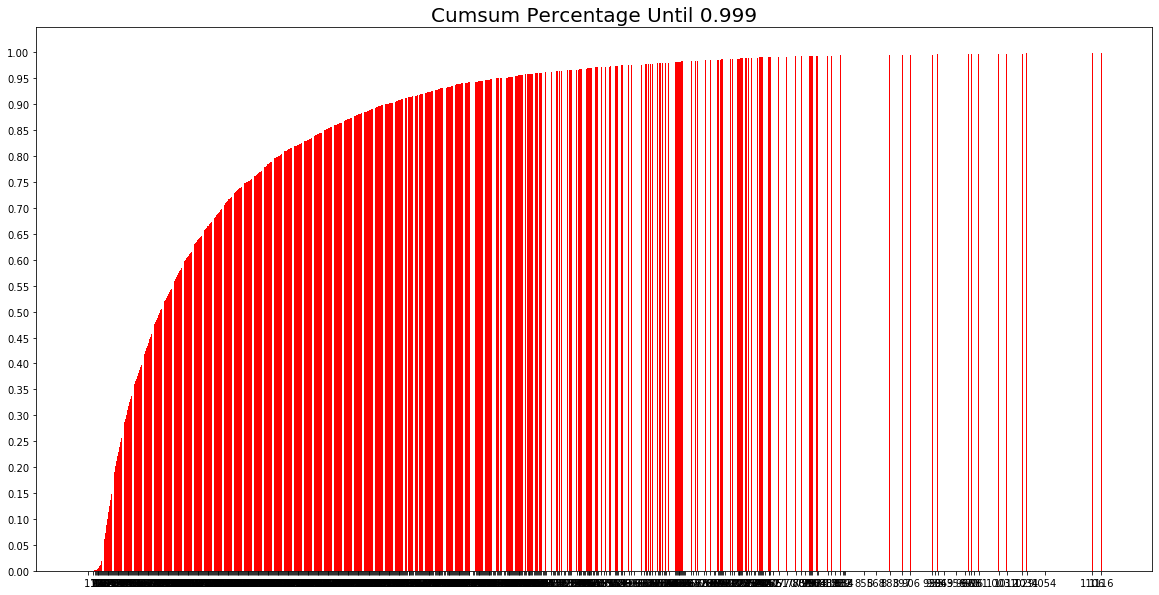

In [12]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

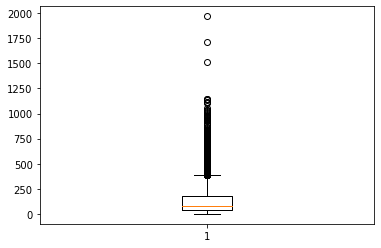

In [13]:
plt.boxplot(data_per_user)
plt.show()

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [15]:
# 가장 마지막 시각으로부터 특정 기간 동안의 데이터만 학습하려고 할 때 활용하는 코드

# specific = 30 # 가장 최근 30일
# d = latest - dt.timedelta(specific)  
# data = data[data['Time'] > d] 
# data

In [16]:
# 다음에 볼 영화를 추천하는 것이므로 영화를 하나만 평가한 User에 대한 데이터는 지우는 함수들
# 이 데이터에선 가장 적게 평가한 user도 20개 를 추천했으므로, 활용하지 않는다.

# def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
#     while True:
#         before_len = len(data)
#         data = cleanse_short_session(data, shortest)
#         data = cleanse_unpopular_item(data, least_click)
#         after_len = len(data)
#         if before_len == after_len:
#             break
#     return data


# def cleanse_short_session(data: pd.DataFrame, shortest):
#     session_len = data.groupby('UserId').size()
#     session_use = session_len[session_len >= shortest].index
#     data = data[data['UserId'].isin(session_use)]
#     return data


# def cleanse_unpopular_item(data: pd.DataFrame, least_click):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_click].index
#     data = data[data['ItemId'].isin(item_use)]
#     return data

기간에 따라 Train/ Validation/ Test로 데이터 분할

In [17]:
data.sort_values(['UserId', 'Time'], inplace = True)
print(data)

         UserId  ItemId  Rating                Time
31            1    3186       4 2000-12-31 22:00:19
22            1    1270       5 2000-12-31 22:00:55
27            1    1721       4 2000-12-31 22:00:55
37            1    1022       5 2000-12-31 22:00:55
24            1    2340       3 2000-12-31 22:01:43
...         ...     ...     ...                 ...
1000019    6040    2917       4 2001-08-10 14:40:29
999988     6040    1921       4 2001-08-10 14:41:04
1000172    6040    1784       3 2001-08-10 14:41:04
1000167    6040     161       3 2001-08-10 14:41:26
1000042    6040    1221       4 2001-08-20 13:44:15

[836478 rows x 4 columns]


In [18]:
data['Time'].max() - data['Time'].min()

Timedelta('1038 days 18:44:18')

In [19]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=1039 * 20 / 100)
tr, val = split_by_date(tr, n_days=1039 * 40 / 100)

len(tr), len(val), len(test), len(tr)+len(val)+len(test)

(603883, 114213, 118382, 836478)

In [21]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 603883
	 Users: 5215
	 Items: 3559
	 First Time : 2000-04-25 23:25:58
	 Last Time : 2001-06-15 02:38:30

* valid Set Stats Info
	 Events: 114213
	 Users: 475
	 Items: 3337
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-04 18:12:09

* test Set Stats Info
	 Events: 118382
	 Users: 349
	 Items: 3316
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
# 데이터 저장

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 미니 배치의 구성

In [25]:
class UserDataset:

    def __init__(self, data):
        self.df = data
        self.rating_offsets = self.get_rating_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())

    def get_rating_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating                Time  item_idx
31       1    3186       4 2000-12-31 22:00:19         0
22       1    1270       5 2000-12-31 22:00:55         1
27       1    1721       4 2000-12-31 22:00:55         2
37       1    1022       5 2000-12-31 22:00:55         3
24       1    2340       3 2000-12-31 22:01:43         4
36       1    1836       5 2000-12-31 22:02:52         5
3        1    3408       4 2000-12-31 22:04:35         6
7        1    2804       5 2000-12-31 22:11:59         7
47       1    1207       4 2000-12-31 22:11:59         8
0        1    1193       5 2000-12-31 22:12:40         9

In [27]:
tr_dataset.rating_offsets

array([     0,     53,    169, ..., 603746, 603764, 603883], dtype=int32)

In [28]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 5212, 5213, 5214])

In [29]:
class UserDataLoader:

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):

        start, end, mask, last_user, finished = self.initialize()

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_user = self.batch_size - 1
        start = self.dataset.rating_offsets[self.dataset.user_idx[first_iters]]
        end = self.dataset.rating_offsets[self.dataset.user_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]  

        for i, idx in enumerate(mask, start=1):
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:
                finished = True
                break
            start[idx] = self.dataset.rating_offsets[self.dataset.user_idx[new_user]]
            end[idx] = self.dataset.rating_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)
        return start, end, mask, last_user, finished

In [30]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

UserId  ItemId  Rating                Time  item_idx
31       1    3186       4 2000-12-31 22:00:19         0
22       1    1270       5 2000-12-31 22:00:55         1
27       1    1721       4 2000-12-31 22:00:55         2
37       1    1022       5 2000-12-31 22:00:55         3
24       1    2340       3 2000-12-31 22:01:43         4
36       1    1836       5 2000-12-31 22:02:52         5
3        1    3408       4 2000-12-31 22:04:35         6
7        1    2804       5 2000-12-31 22:11:59         7
47       1    1207       4 2000-12-31 22:11:59         8
0        1    1193       5 2000-12-31 22:12:40         9
21       1     720       3 2000-12-31 22:12:40        10
44       1     260       4 2000-12-31 22:12:40        11
9        1     919       4 2000-12-31 22:22:48        12
51       1     608       4 2000-12-31 22:23:18        13
43       1    2692       4 2000-12-31 22:26:10        14

In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### 모델 구성

**Evaluation Metric**

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

**Model Architecture**

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [36]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3559)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541650    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3559)               181509    
Total params: 723,159
Trainable params: 723,159
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [37]:
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):

    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=(total_step // args.batch_size), desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
train_model(model, args)

Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.53] 

	 - Recall@20 epoch 1: 0.121326
	 - MRR@20    epoch 1: 0.027859



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.85]

	 - Recall@20 epoch 2: 0.218434
	 - MRR@20    epoch 2: 0.054662



Evaluation:  53%|█████▎    | 235/444 [02:09<01:54,  1.82it/s]

	 - Recall@20 epoch 3: 0.265974
	 - MRR@20    epoch 3: 0.069978



### 모델 테스트

In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  40%|███▉      | 184/461 [01:42<02:34,  1.80it/s]

	 - Recall@20: 0.263269
	 - MRR@20: 0.069015



### 모델 변화 시도 1

위의 모델의 train_loss가 꾸준히 감소하고 있고, validation 관련 값들도 개선되고 있어서 epochs를 늘렸다.

In [42]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3559)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541650    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3559)               181509    
Total params: 723,159
Trainable params: 723,159
Non-trainable params: 0
_________________________________________________________________


In [43]:
train_model(model, args)

Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.51] 

	 - Recall@20 epoch 1: 0.119880
	 - MRR@20    epoch 1: 0.027547



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.71] 

	 - Recall@20 epoch 2: 0.226097
	 - MRR@20    epoch 2: 0.057359



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.47] 

	 - Recall@20 epoch 3: 0.268484
	 - MRR@20    epoch 3: 0.071421



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.34] 

	 - Recall@20 epoch 4: 0.288032
	 - MRR@20    epoch 4: 0.079697



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.33] 

	 - Recall@20 epoch 5: 0.301164
	 - MRR@20    epoch 5: 0.085165



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.22]  

	 - Recall@20 epoch 6: 0.309973
	 - MRR@20    epoch 6: 0.089450



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.06] 

	 - Recall@20 epoch 7: 0.315891
	 - MRR@20    epoch 7: 0.092624



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.15] 

	 - Recall@20 epoch 8: 0.320828
	 - MRR@20    epoch 8: 0.094920



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.2] 

	 - Recall@20 epoch 9: 0.324435
	 - MRR@20    epoch 9: 0.097058



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.1] 

	 - Recall@20 epoch 10: 0.325665
	 - MRR@20    epoch 10: 0.098282



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.99] 

	 - Recall@20 epoch 11: 0.327161
	 - MRR@20    epoch 11: 0.099065



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.09] 

	 - Recall@20 epoch 12: 0.328275
	 - MRR@20    epoch 12: 0.099809



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.03]

	 - Recall@20 epoch 13: 0.328989
	 - MRR@20    epoch 13: 0.100447



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.91]

	 - Recall@20 epoch 14: 0.329222
	 - MRR@20    epoch 14: 0.100983



Evaluation:  53%|█████▎    | 235/444 [02:16<02:01,  1.73it/s]

	 - Recall@20 epoch 15: 0.329920
	 - MRR@20    epoch 15: 0.101384



In [44]:
test_model(model, args, test)

Evaluation:  40%|███▉      | 184/461 [01:46<02:41,  1.72it/s]

	 - Recall@20: 0.320206
	 - MRR@20: 0.098006



### 모델 변화 시도 2

epochs를 늘려서 학습을 했을때도 모델이 잘 수렴해가고 있었지만, epochs를 늘리기 전보다는 학습과 테스트 결과값의 차이가 좀 벌어졌다.   
그래서 drop_rate를 0.1에서 0.15로 높이고, epochs를 25로 높였다.

In [45]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.15, lr=0.001, epochs=25, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3559)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541650    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3559)               181509    
Total params: 723,159
Trainable params: 723,159
Non-trainable params: 0
_________________________________________________________________


In [47]:
train_model(model, args)

Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.61] 

	 - Recall@20 epoch 1: 0.124551
	 - MRR@20    epoch 1: 0.028850



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.79]  

	 - Recall@20 epoch 2: 0.219033
	 - MRR@20    epoch 2: 0.055229



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.46] 

	 - Recall@20 epoch 3: 0.263597
	 - MRR@20    epoch 3: 0.069123



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.49] 

	 - Recall@20 epoch 4: 0.287184
	 - MRR@20    epoch 4: 0.077926



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.27] 

	 - Recall@20 epoch 5: 0.299684
	 - MRR@20    epoch 5: 0.083873



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.29] 

	 - Recall@20 epoch 6: 0.309491
	 - MRR@20    epoch 6: 0.088536



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.1] 

	 - Recall@20 epoch 7: 0.315376
	 - MRR@20    epoch 7: 0.091484



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.19] 

	 - Recall@20 epoch 8: 0.319116
	 - MRR@20    epoch 8: 0.093711



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.16]

	 - Recall@20 epoch 9: 0.322091
	 - MRR@20    epoch 9: 0.095006



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.07]

	 - Recall@20 epoch 10: 0.324003
	 - MRR@20    epoch 10: 0.096289



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.06]

	 - Recall@20 epoch 11: 0.326446
	 - MRR@20    epoch 11: 0.097633



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.07] 

	 - Recall@20 epoch 12: 0.327576
	 - MRR@20    epoch 12: 0.098643



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.04]

	 - Recall@20 epoch 13: 0.328424
	 - MRR@20    epoch 13: 0.099208



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.97] 

	 - Recall@20 epoch 14: 0.329089
	 - MRR@20    epoch 14: 0.100267



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5]     

	 - Recall@20 epoch 15: 0.328873
	 - MRR@20    epoch 15: 0.100524



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.08] 

	 - Recall@20 epoch 16: 0.329870
	 - MRR@20    epoch 16: 0.101022



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.96] 

	 - Recall@20 epoch 17: 0.330568
	 - MRR@20    epoch 17: 0.101352



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.07] 

	 - Recall@20 epoch 18: 0.329438
	 - MRR@20    epoch 18: 0.101299



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.01]

	 - Recall@20 epoch 19: 0.329820
	 - MRR@20    epoch 19: 0.101981



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.02]

	 - Recall@20 epoch 20: 0.329372
	 - MRR@20    epoch 20: 0.101864



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.99] 

	 - Recall@20 epoch 21: 0.329854
	 - MRR@20    epoch 21: 0.101987



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.95]

	 - Recall@20 epoch 22: 0.329638
	 - MRR@20    epoch 22: 0.102209



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.92] 

	 - Recall@20 epoch 23: 0.328989
	 - MRR@20    epoch 23: 0.102306



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.96]

	 - Recall@20 epoch 24: 0.328989
	 - MRR@20    epoch 24: 0.102198



Evaluation:  53%|█████▎    | 235/444 [02:13<01:58,  1.76it/s]

	 - Recall@20 epoch 25: 0.329272
	 - MRR@20    epoch 25: 0.102657



In [48]:
test_model(model, args, test)

Evaluation:  40%|███▉      | 184/461 [01:44<02:36,  1.77it/s]

	 - Recall@20: 0.319463
	 - MRR@20: 0.098892



### 모델 변화 시도 3

첫 번째 변화 시도 때 사용한 하이퍼파라미터 설정값에서 learning_rate를 늘려봤다.

In [58]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.15, lr=0.0025, epochs=15, k=20)
model = create_model(args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(256, 1, 3559)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    541650    
_________________________________________________________________
dropout_8 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_8 (Dense)              (256, 3559)               181509    
Total params: 723,159
Trainable params: 723,159
Non-trainable params: 0
_________________________________________________________________




Train:  32%|███▏      | 748/2338 [00:29<00:23, 68.84it/s, accuracy=0.00781, train_loss=6.92]

In [59]:
train_model(model, args)




Train:   0%|          | 0/2338 [00:00<?, ?it/s]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00391, train_loss=8.18]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0, train_loss=8.18]      


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00391, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0156, train_loss=8.17] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0, train_loss=8.16]      


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00391, train_loss=8.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00391, train_loss=8.14]


Train:   0%|

Train:   1%|          | 20/2338 [00:01<01:57, 19.71it/s, accuracy=0.00781, train_loss=7.39]


Train:   1%|          | 20/2338 [00:01<01:57, 19.71it/s, accuracy=0.0117, train_loss=7.32] 


Train:   1%|          | 20/2338 [00:01<01:57, 19.71it/s, accuracy=0.00391, train_loss=7.27]


Train:   1%|          | 20/2338 [00:01<01:57, 19.71it/s, accuracy=0.00781, train_loss=7.3] 


Train:   1%|          | 20/2338 [00:02<01:57, 19.71it/s, accuracy=0.00391, train_loss=7.43]


Train:   1%|          | 20/2338 [00:02<01:57, 19.71it/s, accuracy=0.00781, train_loss=7.29]


Train:   4%|▎         | 86/2338 [00:02<01:30, 24.95it/s, accuracy=0.00781, train_loss=7.29]


Train:   4%|▎         | 86/2338 [00:02<01:30, 24.95it/s, accuracy=0.0117, train_loss=7.33] 


Train:   4%|▎         | 86/2338 [00:02<01:30, 24.95it/s, accuracy=0.0156, train_loss=7.42]


Train:   4%|▎         | 86/2338 [00:02<01:30, 24.95it/s, accuracy=0.00781, train_loss=7.32]


Train:   4%|▎         | 86/2338 [00:02<01:30, 24.95it/s, accu

Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0, train_loss=7.32]      


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0, train_loss=7.17]


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0.00391, train_loss=7.18]


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0.00391, train_loss=7.19]


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0, train_loss=7.16]      


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0.00391, train_loss=7.18]


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0.00391, train_loss=7.26]


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0.0117, train_loss=7.25] 


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0, train_loss=7.27]     


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, accuracy=0.0117, train_loss=7.35]


Train:   7%|▋         | 154/2338 [00:03<01:10, 30.79it/s, 

Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00781, train_loss=7.15]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00781, train_loss=7.19]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00391, train_loss=7.39]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.0117, train_loss=7.28] 


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00781, train_loss=7.22]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00781, train_loss=7.19]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00391, train_loss=7.25]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00391, train_loss=7.32]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0.00391, train_loss=7.34]


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.96it/s, accuracy=0, train_loss=7.23]      


Train:  10%|▉         | 224/2338 [00:04<00:57, 36.

Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0, train_loss=7.32]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.00781, train_loss=7.26]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.0117, train_loss=7.14] 


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.00391, train_loss=7.29]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.00391, train_loss=7.32]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.00391, train_loss=7.2] 


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.00391, train_loss=7.23]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0.00391, train_loss=7.16]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0, train_loss=7.22]      


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accuracy=0, train_loss=7.22]


Train:  13%|█▎        | 296/2338 [00:05<00:47, 43.24it/s, accu

Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.00391, train_loss=7.36]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.00391, train_loss=7.16]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.00391, train_loss=7.12]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0, train_loss=7.18]      


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.00781, train_loss=7.2]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0, train_loss=7.22]     


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.0195, train_loss=7.07]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.00391, train_loss=7.23]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.00391, train_loss=7.14]


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06it/s, accuracy=0.0156, train_loss=7.12] 


Train:  16%|█▌        | 368/2338 [00:06<00:40, 49.06i

Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0.00391, train_loss=7.13]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0, train_loss=7.23]      


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0, train_loss=7.13]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0.0234, train_loss=7.16]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0.00781, train_loss=7.14]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0.00391, train_loss=7.21]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0, train_loss=7.15]      


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0, train_loss=7.18]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0, train_loss=7.13]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0.0195, train_loss=7.19]


Train:  19%|█▉        | 441/2338 [00:07<00:34, 54.25it/s, accuracy=0.0

Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.00781, train_loss=7.08]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.00781, train_loss=6.98]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.0117, train_loss=7.17] 


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0, train_loss=7.16]     


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.00391, train_loss=7.01]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0, train_loss=6.98]      


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.00781, train_loss=7]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.0117, train_loss=7.13]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.00781, train_loss=7.1]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s, accuracy=0.00391, train_loss=7.06]


Train:  22%|██▏       | 513/2338 [00:08<00:31, 58.52it/s

Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.00781, train_loss=7.13]


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.0156, train_loss=7]    


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.00391, train_loss=7.14]


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.0117, train_loss=7.07] 


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.0117, train_loss=7.15]


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.00781, train_loss=7.07]


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.0117, train_loss=7]    


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.0117, train_loss=7]


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.00781, train_loss=7.02]


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/s, accuracy=0.0156, train_loss=6.89] 


Train:  25%|██▍       | 584/2338 [00:09<00:28, 61.76it/

Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.0156, train_loss=6.86]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.0195, train_loss=6.85]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.00781, train_loss=6.86]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.00781, train_loss=6.99]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.00391, train_loss=6.79]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.0156, train_loss=6.87] 


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.0117, train_loss=6.87]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.0117, train_loss=6.83]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.0117, train_loss=6.89]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/s, accuracy=0.00781, train_loss=6.97]


Train:  28%|██▊       | 656/2338 [00:10<00:26, 64.47it/

Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0117, train_loss=6.75]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0117, train_loss=6.85]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0195, train_loss=6.81]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0156, train_loss=6.97]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.00391, train_loss=6.74]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0195, train_loss=6.77] 


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0234, train_loss=6.66]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.00781, train_loss=6.8]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0273, train_loss=6.74]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, accuracy=0.0195, train_loss=6.74]


Train:  31%|███       | 728/2338 [00:11<00:24, 66.44it/s, 

Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.00781, train_loss=6.72]


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.00781, train_loss=6.79]


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.00781, train_loss=6.83]


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.0234, train_loss=6.77] 


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.0117, train_loss=6.85]


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.0234, train_loss=6.63]


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.0156, train_loss=6.79]


Train:  34%|███▍      | 801/2338 [00:12<00:22, 68.17it/s, accuracy=0.00781, train_loss=6.63]


Train:  34%|███▍      | 801/2338 [00:13<00:22, 68.17it/s, accuracy=0.0195, train_loss=6.63] 


Train:  34%|███▍      | 801/2338 [00:13<00:22, 68.17it/s, accuracy=0.0156, train_loss=6.78]


Train:  34%|███▍      | 801/2338 [00:13<00:22, 68.17it

Train:  37%|███▋      | 875/2338 [00:13<00:21, 69.56it/s, accuracy=0.0156, train_loss=6.61]


Train:  37%|███▋      | 875/2338 [00:13<00:21, 69.56it/s, accuracy=0.0352, train_loss=6.76]


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.0156, train_loss=6.64]


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.00781, train_loss=6.8]


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.00391, train_loss=6.63]


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.0273, train_loss=6.56] 


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.00781, train_loss=6.66]


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.0312, train_loss=6.51] 


Train:  37%|███▋      | 875/2338 [00:14<00:21, 69.56it/s, accuracy=0.0117, train_loss=6.69]


Train:  41%|████      | 947/2338 [00:14<00:19, 70.27it/s, accuracy=0.0117, train_loss=6.69]


Train:  41%|████      | 947/2338 [00:14<00:19, 70.27it/s

Train:  41%|████      | 947/2338 [00:15<00:19, 70.27it/s, accuracy=0.00391, train_loss=6.76]


Train:  41%|████      | 947/2338 [00:15<00:19, 70.27it/s, accuracy=0.0273, train_loss=6.59] 


Train:  41%|████      | 947/2338 [00:15<00:19, 70.27it/s, accuracy=0.00781, train_loss=6.74]


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.00781, train_loss=6.74]


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.0156, train_loss=6.69] 


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.00781, train_loss=6.6]


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.0117, train_loss=6.6] 


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.0195, train_loss=6.71]


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.0273, train_loss=6.64]


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 70.66it/s, accuracy=0.0273, train_loss=6.58]


Train:  44%|████▎     | 1019/2338 [00:15<00:18, 

Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.00391, train_loss=6.56]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.00391, train_loss=6.61]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0117, train_loss=6.51] 


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0234, train_loss=6.56]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0156, train_loss=6.5] 


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0234, train_loss=6.6]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0156, train_loss=6.54]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0234, train_loss=6.53]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0117, train_loss=6.74]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 70.74it/s, accuracy=0.0117, train_loss=6.63]


Train:  47%|████▋     | 1091/2338 [00:16<00:17, 

Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0391, train_loss=6.4]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0312, train_loss=6.52]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0273, train_loss=6.58]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0195, train_loss=6.51]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.00781, train_loss=6.32]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0273, train_loss=6.48] 


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0352, train_loss=6.41]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0273, train_loss=6.5] 


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0117, train_loss=6.49]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 70.43it/s, accuracy=0.0312, train_loss=6.51]


Train:  50%|████▉     | 1163/2338 [00:17<00:16, 7

Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0273, train_loss=6.47]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0156, train_loss=6.53]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0117, train_loss=6.45]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0156, train_loss=6.63]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0117, train_loss=6.47]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0195, train_loss=6.67]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.00391, train_loss=6.39]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0234, train_loss=6.51] 


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0391, train_loss=6.38]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 70.85it/s, accuracy=0.0156, train_loss=6.59]


Train:  53%|█████▎    | 1235/2338 [00:18<00:15, 

Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0234, train_loss=6.34]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0195, train_loss=6.38]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.00781, train_loss=6.46]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0156, train_loss=6.42] 


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0156, train_loss=6.55]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0156, train_loss=6.33]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0117, train_loss=6.42]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0156, train_loss=6.47]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0508, train_loss=6.32]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 71.01it/s, accuracy=0.0195, train_loss=6.65]


Train:  56%|█████▌    | 1307/2338 [00:19<00:14, 

Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0117, train_loss=6.34]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0234, train_loss=6.39]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0391, train_loss=6.24]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.00781, train_loss=6.37]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0234, train_loss=6.38] 


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.00781, train_loss=6.39]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0234, train_loss=6.3]  


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0234, train_loss=6.47]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0273, train_loss=6.55]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13, 71.16it/s, accuracy=0.0352, train_loss=6.47]


Train:  59%|█████▉    | 1379/2338 [00:20<00:13

Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0273, train_loss=6.29]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.00391, train_loss=6.27]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0156, train_loss=6.27] 


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0234, train_loss=6.22]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.00781, train_loss=6.32]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0156, train_loss=6.21] 


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0156, train_loss=6.32]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0195, train_loss=6.34]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.00781, train_loss=6.5]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12, 70.91it/s, accuracy=0.0195, train_loss=6.37]


Train:  62%|██████▏   | 1451/2338 [00:21<00:12

Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0156, train_loss=6.21]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0352, train_loss=6.31]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0156, train_loss=6.15]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0352, train_loss=6.17]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0234, train_loss=6.19]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0312, train_loss=6.18]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0195, train_loss=6.26]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0273, train_loss=6.18]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.0195, train_loss=6.3] 


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 71.03it/s, accuracy=0.00391, train_loss=6.32]


Train:  65%|██████▌   | 1523/2338 [00:22<00:11, 7

Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0352, train_loss=6.29]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.043, train_loss=6.23] 


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0195, train_loss=6.4]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0234, train_loss=6.37]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0312, train_loss=6.46]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0352, train_loss=6.22]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0117, train_loss=6.43]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0234, train_loss=6.22]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0234, train_loss=6.27]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.20it/s, accuracy=0.0273, train_loss=6.28]


Train:  68%|██████▊   | 1595/2338 [00:23<00:10, 71.

Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0234, train_loss=6.43]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0195, train_loss=6.56]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0273, train_loss=6.37]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0234, train_loss=6.68]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0234, train_loss=6.5] 


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0117, train_loss=6.54]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0117, train_loss=6.41]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.00781, train_loss=6.62]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0156, train_loss=6.6]  


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 71.60it/s, accuracy=0.0312, train_loss=6.47]


Train:  71%|███████▏  | 1668/2338 [00:24<00:09, 

Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0195, train_loss=6.41]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0156, train_loss=6.31]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0156, train_loss=6.08]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0117, train_loss=6.3] 


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0117, train_loss=6.33]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0234, train_loss=6.31]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.00781, train_loss=6.07]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0156, train_loss=6.18] 


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.0117, train_loss=6.24]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08, 72.01it/s, accuracy=0.00781, train_loss=6.23]


Train:  74%|███████▍  | 1741/2338 [00:25<00:08,

Train:  78%|███████▊  | 1814/2338 [00:26<00:07, 72.00it/s, accuracy=0.0195, train_loss=6.14]


Train:  78%|███████▊  | 1814/2338 [00:26<00:07, 72.00it/s, accuracy=0.0273, train_loss=6.15]


Train:  78%|███████▊  | 1814/2338 [00:26<00:07, 72.00it/s, accuracy=0.0312, train_loss=6.15]


Train:  78%|███████▊  | 1814/2338 [00:26<00:07, 72.00it/s, accuracy=0.0117, train_loss=6.25]


Train:  78%|███████▊  | 1814/2338 [00:26<00:07, 72.00it/s, accuracy=0.0195, train_loss=6.12]


Train:  78%|███████▊  | 1814/2338 [00:26<00:07, 72.00it/s, accuracy=0.0156, train_loss=6.26]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 72.00it/s, accuracy=0.0273, train_loss=6.13]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 72.00it/s, accuracy=0.0234, train_loss=6.19]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 72.00it/s, accuracy=0.0195, train_loss=6.41]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 72.00it/s, accuracy=0.0273, train_loss=6.36]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 72

Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0273, train_loss=6.34]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0117, train_loss=6.31]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0117, train_loss=6.46]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0312, train_loss=6.28]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0312, train_loss=6.33]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0273, train_loss=6.13]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0352, train_loss=6.27]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0195, train_loss=6.37]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0117, train_loss=6.18]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71.40it/s, accuracy=0.0312, train_loss=6.28]


Train:  81%|████████  | 1887/2338 [00:28<00:06, 71

Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0312, train_loss=6.11]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0117, train_loss=6.15]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0312, train_loss=6.12]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0234, train_loss=6.05]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0273, train_loss=6.3] 


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0195, train_loss=6.16]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0312, train_loss=5.99]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0195, train_loss=6.26]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0117, train_loss=6.19]


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71.60it/s, accuracy=0.0352, train_loss=6.1] 


Train:  84%|████████▍ | 1960/2338 [00:29<00:05, 71

Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0234, train_loss=6.22]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0195, train_loss=6.16]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0234, train_loss=6.21]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0312, train_loss=5.9] 


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0312, train_loss=6.18]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0234, train_loss=6.36]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0312, train_loss=6.24]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0469, train_loss=6.18]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0352, train_loss=6.3] 


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71.58it/s, accuracy=0.0117, train_loss=6.23]


Train:  87%|████████▋ | 2032/2338 [00:30<00:04, 71

Train:  90%|████████▉ | 2104/2338 [00:31<00:03, 71.29it/s, accuracy=0.043, train_loss=5.95] 


Train:  90%|████████▉ | 2104/2338 [00:31<00:03, 71.29it/s, accuracy=0.0312, train_loss=5.93]


Train:  90%|████████▉ | 2104/2338 [00:31<00:03, 71.29it/s, accuracy=0.0312, train_loss=5.93]


Train:  90%|████████▉ | 2104/2338 [00:31<00:03, 71.29it/s, accuracy=0.0312, train_loss=5.81]


Train:  90%|████████▉ | 2104/2338 [00:31<00:03, 71.29it/s, accuracy=0.0195, train_loss=6.17]


Train:  90%|████████▉ | 2104/2338 [00:31<00:03, 71.29it/s, accuracy=0.043, train_loss=6.01] 


Train:  93%|█████████▎| 2176/2338 [00:31<00:02, 71.10it/s, accuracy=0.043, train_loss=6.01]


Train:  93%|█████████▎| 2176/2338 [00:31<00:02, 71.10it/s, accuracy=0.0273, train_loss=5.96]


Train:  93%|█████████▎| 2176/2338 [00:31<00:02, 71.10it/s, accuracy=0.0273, train_loss=6]   


Train:  93%|█████████▎| 2176/2338 [00:31<00:02, 71.10it/s, accuracy=0.0195, train_loss=6.12]


Train:  93%|█████████▎| 2176/2338 [00:31<00:02, 71.

Evaluation:  18%|█▊        | 80/444 [00:46<03:33,  1.71it/s]


Evaluation:  18%|█▊        | 82/444 [00:47<03:30,  1.72it/s]


Evaluation:  19%|█▉        | 84/444 [00:48<03:28,  1.72it/s]


Evaluation:  19%|█▉        | 86/444 [00:49<03:27,  1.72it/s]


Evaluation:  20%|█▉        | 88/444 [00:51<03:27,  1.72it/s]


Evaluation:  20%|██        | 90/444 [00:52<03:26,  1.71it/s]


Evaluation:  21%|██        | 92/444 [00:53<03:27,  1.70it/s]


Evaluation:  21%|██        | 94/444 [00:54<03:27,  1.69it/s]


Evaluation:  22%|██▏       | 96/444 [00:55<03:27,  1.68it/s]


Evaluation:  22%|██▏       | 98/444 [00:56<03:24,  1.69it/s]


Evaluation:  23%|██▎       | 100/444 [00:58<03:25,  1.68it/s]


Evaluation:  23%|██▎       | 102/444 [00:59<03:23,  1.68it/s]


Evaluation:  23%|██▎       | 104/444 [01:00<03:20,  1.69it/s]


Evaluation:  24%|██▍       | 106/444 [01:01<03:19,  1.70it/s]


Evaluation:  24%|██▍       | 108/444 [01:02<03:17,  1.71it/s]


Evaluation:  25%|██▍       | 110/444 [01:04<03:16,

	 - Recall@20 epoch 1: 0.238664
	 - MRR@20    epoch 1: 0.061396






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.71]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.75]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0195, train_loss=5.98]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0195, train_loss=5.74]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.75] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.79]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.96]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.9] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.95]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.97] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.89]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_lo

Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0508, train_loss=5.86]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0195, train_loss=5.92]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0391, train_loss=5.86]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0352, train_loss=5.93]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0195, train_loss=5.93]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.043, train_loss=5.79] 


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0195, train_loss=6.04]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0273, train_loss=6.07]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0156, train_loss=5.91]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.0352, train_loss=5.96]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.71it/s, accuracy=0.04

Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0469, train_loss=5.83]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0273, train_loss=5.88]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0312, train_loss=5.82]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0391, train_loss=5.72]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0508, train_loss=5.76]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0312, train_loss=5.93]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0195, train_loss=5.91]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0195, train_loss=6.02]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0273, train_loss=5.99]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, accuracy=0.0312, train_loss=5.94]


Train:   6%|▌         | 137/2338 [00:02<00:32, 68.26it/s, ac

Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0312, train_loss=5.88]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0234, train_loss=5.91]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0273, train_loss=5.78]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0273, train_loss=5.92]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.043, train_loss=5.79] 


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0273, train_loss=5.93]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0352, train_loss=5.75]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0312, train_loss=5.92]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.043, train_loss=5.78] 


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, accuracy=0.0352, train_loss=5.87]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.54it/s, ac

Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0156, train_loss=5.95]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0469, train_loss=5.9] 


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0469, train_loss=5.89]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0352, train_loss=5.96]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0312, train_loss=5.87]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0234, train_loss=6.07]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0312, train_loss=5.86]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0234, train_loss=6.17]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0234, train_loss=5.98]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, accuracy=0.0273, train_loss=5.92]


Train:  12%|█▏        | 274/2338 [00:04<00:30, 68.51it/s, ac

Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.043, train_loss=5.88] 


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0312, train_loss=5.89]


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0156, train_loss=5.98]


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0352, train_loss=5.82]


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0586, train_loss=5.84]


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0391, train_loss=5.73]


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0273, train_loss=5.9] 


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.043, train_loss=6]   


Train:  15%|█▍        | 347/2338 [00:05<00:28, 69.55it/s, accuracy=0.0391, train_loss=5.89]


Train:  15%|█▍        | 347/2338 [00:06<00:28, 69.55it/s, accuracy=0.0352, train_loss=5.88]


Train:  15%|█▍        | 347/2338 [00:06<00:28, 69.55it/s, acc

Train:  18%|█▊        | 420/2338 [00:06<00:27, 70.41it/s, accuracy=0.0352, train_loss=5.82]


Train:  18%|█▊        | 420/2338 [00:06<00:27, 70.41it/s, accuracy=0.043, train_loss=5.91] 


Train:  18%|█▊        | 420/2338 [00:06<00:27, 70.41it/s, accuracy=0.0469, train_loss=6.06]


Train:  18%|█▊        | 420/2338 [00:07<00:27, 70.41it/s, accuracy=0.0469, train_loss=5.79]


Train:  18%|█▊        | 420/2338 [00:07<00:27, 70.41it/s, accuracy=0.0156, train_loss=5.9] 


Train:  18%|█▊        | 420/2338 [00:07<00:27, 70.41it/s, accuracy=0.00781, train_loss=6.01]


Train:  18%|█▊        | 420/2338 [00:07<00:27, 70.41it/s, accuracy=0.0352, train_loss=5.71] 


Train:  21%|██        | 493/2338 [00:07<00:26, 70.96it/s, accuracy=0.0352, train_loss=5.71]


Train:  21%|██        | 493/2338 [00:07<00:26, 70.96it/s, accuracy=0.0352, train_loss=5.82]


Train:  21%|██        | 493/2338 [00:07<00:26, 70.96it/s, accuracy=0.0508, train_loss=5.85]


Train:  21%|██        | 493/2338 [00:07<00:26, 70.96it/s, 

Train:  21%|██        | 493/2338 [00:08<00:26, 70.96it/s, accuracy=0.0547, train_loss=5.81]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0547, train_loss=5.81]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0312, train_loss=5.72]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0508, train_loss=5.78]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0586, train_loss=5.82]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0391, train_loss=5.69]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0195, train_loss=5.97]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.043, train_loss=5.62] 


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0312, train_loss=5.98]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, accuracy=0.0195, train_loss=5.88]


Train:  24%|██▍       | 565/2338 [00:08<00:24, 71.15it/s, ac

Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.0391, train_loss=5.94]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.0547, train_loss=5.72]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.0508, train_loss=5.69]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.043, train_loss=5.84] 


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.0391, train_loss=5.96]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.0508, train_loss=5.95]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.0312, train_loss=5.96]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.043, train_loss=5.67] 


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.043, train_loss=5.84]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accuracy=0.043, train_loss=5.81]


Train:  27%|██▋       | 637/2338 [00:09<00:23, 71.40it/s, accu

Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0391, train_loss=5.81]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0273, train_loss=5.64]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.043, train_loss=5.87] 


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0391, train_loss=5.83]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0352, train_loss=5.76]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0508, train_loss=5.83]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0273, train_loss=5.93]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0312, train_loss=5.75]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0312, train_loss=5.78]


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, accuracy=0.0391, train_loss=6]   


Train:  30%|███       | 706/2338 [00:10<00:23, 69.25it/s, ac

Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0469, train_loss=5.96]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0352, train_loss=6]   


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0312, train_loss=5.88]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0117, train_loss=5.97]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0273, train_loss=5.91]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0156, train_loss=6.02]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0234, train_loss=5.96]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0352, train_loss=5.85]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0234, train_loss=5.85]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, accuracy=0.0391, train_loss=5.98]


Train:  33%|███▎      | 781/2338 [00:11<00:22, 70.51it/s, ac

Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0391, train_loss=5.93]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0352, train_loss=5.86]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0312, train_loss=5.84]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0469, train_loss=5.84]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0547, train_loss=5.81]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0234, train_loss=5.82]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0469, train_loss=5.78]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0508, train_loss=5.86]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0391, train_loss=5.8] 


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, accuracy=0.0312, train_loss=5.98]


Train:  36%|███▋      | 851/2338 [00:12<00:21, 70.03it/s, ac

Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0234, train_loss=5.84]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0234, train_loss=6.05]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0352, train_loss=5.89]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0273, train_loss=6.1] 


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.043, train_loss=6.03]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0195, train_loss=5.88]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0234, train_loss=5.87]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0508, train_loss=5.76]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.043, train_loss=5.76] 


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, accuracy=0.0508, train_loss=5.79]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.32it/s, acc

Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0352, train_loss=5.81]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0312, train_loss=6]   


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0625, train_loss=5.87]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0273, train_loss=5.8] 


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0547, train_loss=5.76]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0391, train_loss=6.04]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0234, train_loss=5.81]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0195, train_loss=5.91]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.0508, train_loss=5.89]


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71.99it/s, accuracy=0.043, train_loss=5.81] 


Train:  43%|████▎     | 1000/2338 [00:14<00:18, 71

Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0508, train_loss=5.93]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0469, train_loss=5.95]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0312, train_loss=6.04]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.043, train_loss=5.68] 


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0156, train_loss=6]  


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.043, train_loss=6.08]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0234, train_loss=5.84]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0352, train_loss=6.02]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0312, train_loss=5.68]


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.68it/s, accuracy=0.0352, train_loss=5.9] 


Train:  46%|████▌     | 1075/2338 [00:15<00:17, 72.6

Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0352, train_loss=5.96]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0352, train_loss=6]   


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0273, train_loss=5.95]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0156, train_loss=5.95]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0312, train_loss=5.85]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0391, train_loss=5.98]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0312, train_loss=5.95]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0234, train_loss=5.93]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0312, train_loss=5.79]


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73.47it/s, accuracy=0.0156, train_loss=6]   


Train:  49%|████▉     | 1151/2338 [00:16<00:16, 73

Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0195, train_loss=5.78]


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0352, train_loss=5.85]


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0625, train_loss=5.8] 


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.043, train_loss=5.89]


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0156, train_loss=5.99]


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0469, train_loss=5.8] 


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0234, train_loss=6]  


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0391, train_loss=5.88]


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0469, train_loss=5.66]


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.88it/s, accuracy=0.0195, train_loss=5.8] 


Train:  52%|█████▏    | 1225/2338 [00:17<00:15, 72.8

Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0312, train_loss=5.77]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0391, train_loss=5.68]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0273, train_loss=5.77]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0352, train_loss=5.82]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0273, train_loss=5.83]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.043, train_loss=5.78] 


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.00781, train_loss=5.95]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0273, train_loss=6.03] 


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0195, train_loss=6]   


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 72.32it/s, accuracy=0.0469, train_loss=5.87]


Train:  56%|█████▌    | 1298/2338 [00:18<00:14, 

Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.00781, train_loss=5.82]


Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.0391, train_loss=5.84] 


Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.0469, train_loss=5.69]


Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.0312, train_loss=5.7] 


Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.0391, train_loss=5.85]


Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.0625, train_loss=5.8] 


Train:  59%|█████▊    | 1371/2338 [00:19<00:13, 72.09it/s, accuracy=0.0391, train_loss=5.86]


Train:  59%|█████▊    | 1371/2338 [00:20<00:13, 72.09it/s, accuracy=0.043, train_loss=5.86] 


Train:  59%|█████▊    | 1371/2338 [00:20<00:13, 72.09it/s, accuracy=0.0508, train_loss=5.88]


Train:  59%|█████▊    | 1371/2338 [00:20<00:13, 72.09it/s, accuracy=0.0352, train_loss=5.94]


Train:  59%|█████▊    | 1371/2338 [00:20<00:13, 

Train:  62%|██████▏   | 1444/2338 [00:20<00:12, 71.95it/s, accuracy=0.0273, train_loss=5.97]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0312, train_loss=5.78]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0312, train_loss=5.75]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0234, train_loss=5.79]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.043, train_loss=5.78] 


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0273, train_loss=5.68]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0391, train_loss=5.89]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0508, train_loss=6.12]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.0391, train_loss=5.77]


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71.95it/s, accuracy=0.043, train_loss=5.85] 


Train:  62%|██████▏   | 1444/2338 [00:21<00:12, 71

Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0273, train_loss=5.82]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0273, train_loss=5.7] 


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0234, train_loss=6.02]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0508, train_loss=5.79]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0352, train_loss=5.9] 


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0391, train_loss=5.82]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0234, train_loss=5.76]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0234, train_loss=5.92]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0391, train_loss=5.72]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71.34it/s, accuracy=0.0547, train_loss=5.77]


Train:  65%|██████▍   | 1516/2338 [00:22<00:11, 71

Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0508, train_loss=5.83]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0352, train_loss=5.83]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0469, train_loss=5.73]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0352, train_loss=5.91]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0391, train_loss=5.92]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0312, train_loss=6.08]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0195, train_loss=5.99]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0312, train_loss=5.93]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0508, train_loss=5.86]


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71.66it/s, accuracy=0.0352, train_loss=5.9] 


Train:  68%|██████▊   | 1589/2338 [00:23<00:10, 71

Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0234, train_loss=6.09]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0508, train_loss=5.89]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0469, train_loss=6]   


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0273, train_loss=6.05]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0156, train_loss=6.29]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0156, train_loss=6.13]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.043, train_loss=5.85] 


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0352, train_loss=6.04]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0234, train_loss=6.01]


Train:  71%|███████   | 1662/2338 [00:24<00:09, 71.80it/s, accuracy=0.0391, train_loss=5.92]


Train:  74%|███████▍  | 1734/2338 [00:24<00:08, 70

Train:  74%|███████▍  | 1734/2338 [00:25<00:08, 70.66it/s, accuracy=0.0234, train_loss=6.02]


Train:  74%|███████▍  | 1734/2338 [00:25<00:08, 70.66it/s, accuracy=0.0156, train_loss=6.07]


Train:  74%|███████▍  | 1734/2338 [00:25<00:08, 70.66it/s, accuracy=0.043, train_loss=6.02] 


Train:  74%|███████▍  | 1734/2338 [00:25<00:08, 70.66it/s, accuracy=0.0195, train_loss=5.83]


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69.88it/s, accuracy=0.0195, train_loss=5.83]


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69.88it/s, accuracy=0.0273, train_loss=6]   


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69.88it/s, accuracy=0.0508, train_loss=5.86]


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69.88it/s, accuracy=0.0352, train_loss=5.66]


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69.88it/s, accuracy=0.0312, train_loss=5.92]


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69.88it/s, accuracy=0.0391, train_loss=5.75]


Train:  77%|███████▋  | 1805/2338 [00:25<00:07, 69

Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0273, train_loss=5.98]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0156, train_loss=6.02]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0547, train_loss=5.86]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0117, train_loss=6.08]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0156, train_loss=6.01]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0312, train_loss=5.99]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0273, train_loss=5.9] 


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0391, train_loss=6.05]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0195, train_loss=6.1] 


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69.44it/s, accuracy=0.0234, train_loss=5.99]


Train:  80%|████████  | 1875/2338 [00:26<00:06, 69

Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0312, train_loss=5.89]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0234, train_loss=5.92]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0312, train_loss=5.97]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0273, train_loss=5.91]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0273, train_loss=5.91]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0469, train_loss=5.76]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0195, train_loss=5.87]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0312, train_loss=5.88]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0391, train_loss=5.79]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68.80it/s, accuracy=0.0352, train_loss=6.04]


Train:  83%|████████▎ | 1945/2338 [00:27<00:05, 68

Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0273, train_loss=5.8] 


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0352, train_loss=5.79]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.043, train_loss=5.97] 


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0312, train_loss=5.88]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0352, train_loss=6.05]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0234, train_loss=6.13]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0547, train_loss=5.9] 


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0703, train_loss=5.95]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0273, train_loss=6.01]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68.80it/s, accuracy=0.0234, train_loss=5.83]


Train:  86%|████████▌ | 2014/2338 [00:28<00:04, 68

Train:  89%|████████▉ | 2083/2338 [00:29<00:03, 68.04it/s, accuracy=0.0234, train_loss=5.88]


Train:  89%|████████▉ | 2083/2338 [00:29<00:03, 68.04it/s, accuracy=0.0352, train_loss=5.97]


Train:  89%|████████▉ | 2083/2338 [00:29<00:03, 68.04it/s, accuracy=0.0312, train_loss=6.14]


Train:  89%|████████▉ | 2083/2338 [00:29<00:03, 68.04it/s, accuracy=0.043, train_loss=5.78] 


Train:  89%|████████▉ | 2083/2338 [00:29<00:03, 68.04it/s, accuracy=0.0312, train_loss=5.9]


Train:  89%|████████▉ | 2083/2338 [00:30<00:03, 68.04it/s, accuracy=0.0391, train_loss=6.02]


Train:  89%|████████▉ | 2083/2338 [00:30<00:03, 68.04it/s, accuracy=0.043, train_loss=5.89] 


Train:  89%|████████▉ | 2083/2338 [00:30<00:03, 68.04it/s, accuracy=0.0469, train_loss=5.88]


Train:  89%|████████▉ | 2083/2338 [00:30<00:03, 68.04it/s, accuracy=0.0391, train_loss=5.67]


Train:  89%|████████▉ | 2083/2338 [00:30<00:03, 68.04it/s, accuracy=0.0273, train_loss=5.91]


Train:  89%|████████▉ | 2083/2338 [00:30<00:03, 68.

Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0508, train_loss=5.58]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0312, train_loss=5.66]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0234, train_loss=5.56]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0352, train_loss=5.88]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0352, train_loss=5.7] 


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0273, train_loss=5.86]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0234, train_loss=5.96]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0352, train_loss=5.84]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0273, train_loss=5.8] 


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67.75it/s, accuracy=0.0234, train_loss=5.78]


Train:  92%|█████████▏| 2152/2338 [00:31<00:02, 67

Evaluation:  27%|██▋       | 122/444 [01:10<03:11,  1.68it/s]


Evaluation:  28%|██▊       | 124/444 [01:11<03:11,  1.68it/s]


Evaluation:  28%|██▊       | 126/444 [01:12<03:08,  1.69it/s]


Evaluation:  29%|██▉       | 128/444 [01:13<03:05,  1.70it/s]


Evaluation:  29%|██▉       | 130/444 [01:15<03:04,  1.71it/s]


Evaluation:  30%|██▉       | 132/444 [01:16<03:01,  1.72it/s]


Evaluation:  30%|███       | 134/444 [01:17<02:59,  1.73it/s]


Evaluation:  31%|███       | 136/444 [01:18<02:59,  1.71it/s]


Evaluation:  31%|███       | 138/444 [01:19<02:58,  1.71it/s]


Evaluation:  32%|███▏      | 140/444 [01:20<02:57,  1.71it/s]


Evaluation:  32%|███▏      | 142/444 [01:22<02:55,  1.72it/s]


Evaluation:  32%|███▏      | 144/444 [01:23<02:54,  1.71it/s]


Evaluation:  33%|███▎      | 146/444 [01:24<02:54,  1.71it/s]


Evaluation:  33%|███▎      | 148/444 [01:25<02:53,  1.71it/s]


Evaluation:  34%|███▍      | 150/444 [01:26<02:54,  1.69it/s]


Evaluation:  34%|███▍      | 152/444 [01

	 - Recall@20 epoch 2: 0.288780
	 - MRR@20    epoch 2: 0.080400






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0273, train_loss=5.52]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.41]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.43]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.44] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.63]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.57]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.61]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.69]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.63]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.48]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.72] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_lo

Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0391, train_loss=5.61]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0352, train_loss=5.63]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0195, train_loss=5.57]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0625, train_loss=5.49]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0273, train_loss=5.71]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0273, train_loss=5.82]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0547, train_loss=5.6] 


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0508, train_loss=5.67]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0508, train_loss=5.54]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.0352, train_loss=5.47]


Train:   3%|▎         | 76/2338 [00:01<00:30, 75.04it/s, accuracy=0.03

Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0352, train_loss=5.45]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0469, train_loss=5.52]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0469, train_loss=5.69]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0547, train_loss=5.56]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0391, train_loss=5.82]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.043, train_loss=5.73] 


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.043, train_loss=5.73]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0117, train_loss=5.86]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0352, train_loss=5.74]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, accuracy=0.0586, train_loss=5.68]


Train:   7%|▋         | 155/2338 [00:02<00:28, 75.88it/s, acc

Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0312, train_loss=5.63]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0469, train_loss=5.49]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.043, train_loss=5.62] 


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0586, train_loss=5.48]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0234, train_loss=5.62]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0664, train_loss=5.52]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0312, train_loss=5.57]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.0508, train_loss=5.69]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.043, train_loss=5.62] 


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, accuracy=0.043, train_loss=5.67]


Train:  10%|▉         | 232/2338 [00:03<00:27, 76.20it/s, acc

Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0312, train_loss=5.7] 


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0703, train_loss=5.63]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0547, train_loss=5.75]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0508, train_loss=5.54]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0195, train_loss=5.84]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0352, train_loss=5.7] 


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0469, train_loss=5.58]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0391, train_loss=5.77]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0273, train_loss=5.69]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, accuracy=0.0273, train_loss=5.63]


Train:  13%|█▎        | 309/2338 [00:04<00:26, 76.22it/s, ac

Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0586, train_loss=5.54]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0703, train_loss=5.51]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0508, train_loss=5.44]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0469, train_loss=5.63]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0391, train_loss=5.73]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0547, train_loss=5.65]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0352, train_loss=5.54]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0195, train_loss=5.74]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.043, train_loss=5.51] 


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, accuracy=0.0703, train_loss=5.34]


Train:  16%|█▋        | 380/2338 [00:05<00:26, 74.44it/s, ac

Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0586, train_loss=5.5] 


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0273, train_loss=5.6]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0508, train_loss=5.74]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.043, train_loss=5.41] 


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0547, train_loss=5.56]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0547, train_loss=5.62]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0742, train_loss=5.71]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0781, train_loss=5.59]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0547, train_loss=5.72]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, accuracy=0.0742, train_loss=5.41]


Train:  20%|█▉        | 461/2338 [00:06<00:24, 76.23it/s, acc

Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0781, train_loss=5.6] 


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0703, train_loss=5.45]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0312, train_loss=5.73]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0703, train_loss=5.43]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.043, train_loss=5.69] 


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0586, train_loss=5.62]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0352, train_loss=5.58]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0469, train_loss=5.67]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0586, train_loss=5.53]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, accuracy=0.0586, train_loss=5.47]


Train:  23%|██▎       | 544/2338 [00:07<00:22, 78.08it/s, ac

Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0547, train_loss=5.72]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0547, train_loss=5.69]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0352, train_loss=5.72]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0781, train_loss=5.47]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0547, train_loss=5.63]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.043, train_loss=5.6]  


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.043, train_loss=5.6]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0586, train_loss=5.58]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0547, train_loss=5.68]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accuracy=0.0664, train_loss=5.38]


Train:  27%|██▋       | 622/2338 [00:08<00:22, 77.88it/s, accu

Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.043, train_loss=5.51] 


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0547, train_loss=5.53]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0391, train_loss=5.65]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0312, train_loss=5.5] 


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0625, train_loss=5.46]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0508, train_loss=5.82]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0312, train_loss=5.72]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0977, train_loss=5.47]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0469, train_loss=5.46]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, accuracy=0.0625, train_loss=5.43]


Train:  30%|███       | 702/2338 [00:09<00:20, 78.32it/s, ac

Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0391, train_loss=5.77]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0156, train_loss=5.8] 


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.043, train_loss=5.8] 


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.043, train_loss=5.63]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0273, train_loss=5.64]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0352, train_loss=5.7] 


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0547, train_loss=5.56]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0312, train_loss=5.64]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0391, train_loss=5.62]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accuracy=0.0508, train_loss=5.75]


Train:  33%|███▎      | 781/2338 [00:10<00:19, 78.22it/s, accu

Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0469, train_loss=5.72]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0625, train_loss=5.55]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0547, train_loss=5.6] 


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0547, train_loss=5.67]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0586, train_loss=5.57]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0625, train_loss=5.74]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0469, train_loss=5.7] 


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0391, train_loss=5.61]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0195, train_loss=5.74]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, accuracy=0.0625, train_loss=5.71]


Train:  37%|███▋      | 858/2338 [00:11<00:19, 77.78it/s, ac

Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0352, train_loss=5.82]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0508, train_loss=5.65]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.043, train_loss=5.71] 


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0508, train_loss=5.57]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0469, train_loss=5.59]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0547, train_loss=5.57]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0508, train_loss=5.73]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0625, train_loss=5.52]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0352, train_loss=5.73]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, accuracy=0.0625, train_loss=5.51]


Train:  40%|███▉      | 935/2338 [00:12<00:18, 75.41it/s, ac

Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0625, train_loss=5.6]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0508, train_loss=5.9]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0547, train_loss=5.61]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0273, train_loss=5.76]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0586, train_loss=5.69]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0508, train_loss=5.75]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0469, train_loss=5.61]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0586, train_loss=5.67]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0391, train_loss=5.66]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.67it/s, accuracy=0.0352, train_loss=5.83]


Train:  43%|████▎     | 1012/2338 [00:13<00:17, 75.6

Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0469, train_loss=5.78]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0547, train_loss=5.86]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0586, train_loss=5.64]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0625, train_loss=5.8] 


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0586, train_loss=5.56]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0469, train_loss=5.75]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0625, train_loss=5.6] 


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0312, train_loss=5.7]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0469, train_loss=5.74]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.60it/s, accuracy=0.0547, train_loss=5.61]


Train:  47%|████▋     | 1091/2338 [00:14<00:16, 76.

Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.043, train_loss=5.72] 


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0508, train_loss=5.72]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0195, train_loss=5.76]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0352, train_loss=5.76]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0508, train_loss=5.65]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0312, train_loss=5.73]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0508, train_loss=5.58]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0508, train_loss=5.7] 


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0664, train_loss=5.59]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78.14it/s, accuracy=0.0664, train_loss=5.51]


Train:  50%|█████     | 1173/2338 [00:15<00:14, 78

Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0234, train_loss=5.86]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0469, train_loss=5.68]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0273, train_loss=5.76]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0469, train_loss=5.69]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0391, train_loss=5.53]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0312, train_loss=5.65]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0586, train_loss=5.75]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.043, train_loss=5.62] 


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0547, train_loss=5.61]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78.60it/s, accuracy=0.0352, train_loss=5.64]


Train:  54%|█████▎    | 1253/2338 [00:16<00:13, 78

Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0352, train_loss=5.54]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0742, train_loss=5.57]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0234, train_loss=5.86]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0312, train_loss=5.86]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0195, train_loss=5.8] 


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0508, train_loss=5.58]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0352, train_loss=5.69]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0508, train_loss=5.72]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0273, train_loss=5.69]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78.27it/s, accuracy=0.0508, train_loss=5.63]


Train:  57%|█████▋    | 1332/2338 [00:17<00:12, 78

Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0352, train_loss=5.65]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0391, train_loss=5.59]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.043, train_loss=5.71] 


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0938, train_loss=5.62]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0742, train_loss=5.73]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0469, train_loss=5.76]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0547, train_loss=5.64]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0469, train_loss=5.61]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0391, train_loss=5.73]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76.41it/s, accuracy=0.0586, train_loss=5.56]


Train:  60%|██████    | 1411/2338 [00:18<00:12, 76

Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0703, train_loss=5.6] 


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0469, train_loss=5.53]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0586, train_loss=5.72]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0586, train_loss=5.91]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0469, train_loss=5.66]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0469, train_loss=5.7] 


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0508, train_loss=5.62]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0195, train_loss=5.75]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0508, train_loss=5.53]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77.89it/s, accuracy=0.0273, train_loss=5.73]


Train:  64%|██████▍   | 1493/2338 [00:19<00:10, 77

Train:  64%|██████▍   | 1493/2338 [00:20<00:10, 77.89it/s, accuracy=0.043, train_loss=5.58] 


Train:  64%|██████▍   | 1493/2338 [00:20<00:10, 77.89it/s, accuracy=0.0352, train_loss=5.61]


Train:  64%|██████▍   | 1493/2338 [00:20<00:10, 77.89it/s, accuracy=0.0547, train_loss=5.74]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.0547, train_loss=5.74]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.0508, train_loss=5.54]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.0352, train_loss=5.62]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.0391, train_loss=5.68]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.0664, train_loss=5.57]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.00781, train_loss=5.79]


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 79.63it/s, accuracy=0.043, train_loss=5.55]  


Train:  67%|██████▋   | 1578/2338 [00:20<00:09, 

Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.0156, train_loss=5.94]


Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.0469, train_loss=5.83]


Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.0391, train_loss=5.74]


Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.043, train_loss=5.67] 


Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.043, train_loss=5.76]


Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.0352, train_loss=5.83]


Train:  67%|██████▋   | 1578/2338 [00:21<00:09, 79.63it/s, accuracy=0.0312, train_loss=5.74]


Train:  71%|███████   | 1659/2338 [00:21<00:08, 79.90it/s, accuracy=0.0312, train_loss=5.74]


Train:  71%|███████   | 1659/2338 [00:21<00:08, 79.90it/s, accuracy=0.043, train_loss=5.75] 


Train:  71%|███████   | 1659/2338 [00:21<00:08, 79.90it/s, accuracy=0.0352, train_loss=5.77]


Train:  71%|███████   | 1659/2338 [00:21<00:08, 79.

Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0312, train_loss=5.98]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0586, train_loss=5.63]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0391, train_loss=5.88]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0391, train_loss=5.8] 


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0664, train_loss=5.77]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0312, train_loss=5.71]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0469, train_loss=5.91]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0352, train_loss=6.08]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0547, train_loss=5.72]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79.90it/s, accuracy=0.0508, train_loss=5.64]


Train:  71%|███████   | 1659/2338 [00:22<00:08, 79

Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0586, train_loss=5.72]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0547, train_loss=5.46]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0391, train_loss=5.76]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.043, train_loss=5.59] 


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.043, train_loss=5.71]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0547, train_loss=5.7]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0156, train_loss=5.83]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0234, train_loss=5.73]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0391, train_loss=5.75]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.40it/s, accuracy=0.0547, train_loss=5.77]


Train:  74%|███████▍  | 1741/2338 [00:23<00:07, 80.4

Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0352, train_loss=5.82]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.043, train_loss=5.86] 


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0195, train_loss=5.95]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0195, train_loss=5.88]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0391, train_loss=6.08]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0469, train_loss=5.55]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0508, train_loss=5.78]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0312, train_loss=5.86]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0273, train_loss=6.09]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80.16it/s, accuracy=0.0469, train_loss=5.76]


Train:  78%|███████▊  | 1822/2338 [00:24<00:06, 80

Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.043, train_loss=5.67] 


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0312, train_loss=5.79]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0391, train_loss=5.63]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0547, train_loss=5.83]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.043, train_loss=5.75] 


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0508, train_loss=5.68]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0352, train_loss=5.67]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0391, train_loss=5.74]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0352, train_loss=5.65]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79.95it/s, accuracy=0.0312, train_loss=5.77]


Train:  81%|████████▏ | 1903/2338 [00:25<00:05, 79

Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0664, train_loss=5.78]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0586, train_loss=5.8] 


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0586, train_loss=5.87]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.043, train_loss=5.65] 


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0273, train_loss=5.83]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0352, train_loss=5.96]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0352, train_loss=5.75]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0234, train_loss=5.84]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0234, train_loss=6]   


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79.98it/s, accuracy=0.0352, train_loss=5.84]


Train:  85%|████████▍ | 1984/2338 [00:26<00:04, 79

Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0352, train_loss=5.82]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0352, train_loss=5.72]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0508, train_loss=5.56]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0391, train_loss=5.78]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0391, train_loss=5.77]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0312, train_loss=5.67]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0547, train_loss=5.48]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.043, train_loss=5.68] 


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0273, train_loss=5.79]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79.94it/s, accuracy=0.0391, train_loss=5.67]


Train:  88%|████████▊ | 2065/2338 [00:27<00:03, 79

Train:  92%|█████████▏| 2145/2338 [00:27<00:02, 79.95it/s, accuracy=0.0352, train_loss=5.85]


Train:  92%|█████████▏| 2145/2338 [00:27<00:02, 79.95it/s, accuracy=0.0508, train_loss=5.83]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.043, train_loss=5.74] 


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0391, train_loss=5.7]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0312, train_loss=5.8]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0391, train_loss=5.78]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0352, train_loss=5.81]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0508, train_loss=5.61]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0195, train_loss=5.87]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.95it/s, accuracy=0.0469, train_loss=5.82]


Train:  92%|█████████▏| 2145/2338 [00:28<00:02, 79.9

Evaluation:  32%|███▏      | 142/444 [01:22<02:59,  1.68it/s]


Evaluation:  32%|███▏      | 144/444 [01:23<02:59,  1.67it/s]


Evaluation:  33%|███▎      | 146/444 [01:24<02:59,  1.66it/s]


Evaluation:  33%|███▎      | 148/444 [01:25<02:56,  1.68it/s]


Evaluation:  34%|███▍      | 150/444 [01:27<02:54,  1.69it/s]


Evaluation:  34%|███▍      | 152/444 [01:28<02:51,  1.70it/s]


Evaluation:  35%|███▍      | 154/444 [01:29<02:50,  1.70it/s]


Evaluation:  35%|███▌      | 156/444 [01:30<02:48,  1.71it/s]


Evaluation:  36%|███▌      | 158/444 [01:31<02:44,  1.74it/s]


Evaluation:  36%|███▌      | 160/444 [01:32<02:44,  1.73it/s]


Evaluation:  36%|███▋      | 162/444 [01:33<02:43,  1.73it/s]


Evaluation:  37%|███▋      | 164/444 [01:35<02:45,  1.69it/s]


Evaluation:  37%|███▋      | 166/444 [01:36<02:44,  1.69it/s]


Evaluation:  38%|███▊      | 168/444 [01:37<02:43,  1.69it/s]


Evaluation:  38%|███▊      | 170/444 [01:38<02:40,  1.71it/s]


Evaluation:  39%|███▊      | 172/444 [01

	 - Recall@20 epoch 3: 0.307713
	 - MRR@20    epoch 3: 0.088335






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.34]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.3] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.54]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.42]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.5] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.56]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.47]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.34]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.58]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.38]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.41]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_lo

Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0586, train_loss=5.3] 


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0312, train_loss=5.63]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0352, train_loss=5.67]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0508, train_loss=5.5] 


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0625, train_loss=5.51]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0625, train_loss=5.48]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0586, train_loss=5.32]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0508, train_loss=5.65]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0312, train_loss=5.45]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.0703, train_loss=5.49]


Train:   4%|▎         | 83/2338 [00:01<00:27, 82.46it/s, accuracy=0.04

Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0391, train_loss=5.46]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0352, train_loss=5.6] 


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0547, train_loss=5.63]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0273, train_loss=5.65]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0312, train_loss=5.79]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0508, train_loss=5.56]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0703, train_loss=5.63]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0469, train_loss=5.53]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.0586, train_loss=5.54]


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, accuracy=0.043, train_loss=5.51] 


Train:   7%|▋         | 164/2338 [00:02<00:26, 81.81it/s, ac

Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0859, train_loss=5.33]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0547, train_loss=5.48]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0664, train_loss=5.4] 


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0312, train_loss=5.41]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0547, train_loss=5.59]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0352, train_loss=5.48]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.043, train_loss=5.57] 


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.043, train_loss=5.5] 


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0508, train_loss=5.33]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, accuracy=0.0508, train_loss=5.35]


Train:  11%|█         | 246/2338 [00:03<00:25, 81.81it/s, acc

Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0469, train_loss=5.45]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0312, train_loss=5.68]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0508, train_loss=5.54]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0625, train_loss=5.45]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0547, train_loss=5.65]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0312, train_loss=5.67]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0586, train_loss=5.54]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0586, train_loss=5.48]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0703, train_loss=5.5] 


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, accuracy=0.0586, train_loss=5.33]


Train:  14%|█▍        | 329/2338 [00:04<00:24, 82.06it/s, ac

Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0312, train_loss=5.55]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.043, train_loss=5.54] 


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0664, train_loss=5.5]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0508, train_loss=5.4]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.043, train_loss=5.53]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0469, train_loss=5.35]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0742, train_loss=5.15]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0508, train_loss=5.28]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0586, train_loss=5.46]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accuracy=0.0703, train_loss=5.42]


Train:  18%|█▊        | 412/2338 [00:05<00:23, 82.31it/s, accur

Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.082, train_loss=5.3]  


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0625, train_loss=5.49]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.043, train_loss=5.47] 


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0547, train_loss=5.6]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0703, train_loss=5.49]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0586, train_loss=5.61]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0977, train_loss=5.26]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0781, train_loss=5.32]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0625, train_loss=5.47]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, accuracy=0.0625, train_loss=5.36]


Train:  21%|██        | 492/2338 [00:06<00:22, 81.31it/s, acc

Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0664, train_loss=5.29]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0586, train_loss=5.6] 


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0586, train_loss=5.51]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0547, train_loss=5.54]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0312, train_loss=5.62]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0586, train_loss=5.38]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0742, train_loss=5.31]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0352, train_loss=5.61]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0352, train_loss=5.61]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, accuracy=0.0547, train_loss=5.52]


Train:  24%|██▍       | 571/2338 [00:07<00:21, 80.39it/s, ac

Train:  24%|██▍       | 571/2338 [00:08<00:21, 80.39it/s, accuracy=0.0586, train_loss=5.45]


Train:  24%|██▍       | 571/2338 [00:08<00:21, 80.39it/s, accuracy=0.0508, train_loss=5.48]


Train:  24%|██▍       | 571/2338 [00:08<00:21, 80.39it/s, accuracy=0.0352, train_loss=5.46]


Train:  24%|██▍       | 571/2338 [00:08<00:21, 80.39it/s, accuracy=0.0586, train_loss=5.47]


Train:  24%|██▍       | 571/2338 [00:08<00:21, 80.39it/s, accuracy=0.0781, train_loss=5.53]


Train:  28%|██▊       | 654/2338 [00:08<00:20, 80.99it/s, accuracy=0.0781, train_loss=5.53]


Train:  28%|██▊       | 654/2338 [00:08<00:20, 80.99it/s, accuracy=0.0742, train_loss=5.25]


Train:  28%|██▊       | 654/2338 [00:08<00:20, 80.99it/s, accuracy=0.043, train_loss=5.39] 


Train:  28%|██▊       | 654/2338 [00:08<00:20, 80.99it/s, accuracy=0.043, train_loss=5.33]


Train:  28%|██▊       | 654/2338 [00:08<00:20, 80.99it/s, accuracy=0.0781, train_loss=5.28]


Train:  28%|██▊       | 654/2338 [00:08<00:20, 80.99it/s, acc

Train:  28%|██▊       | 654/2338 [00:09<00:20, 80.99it/s, accuracy=0.0625, train_loss=5.33]


Train:  28%|██▊       | 654/2338 [00:09<00:20, 80.99it/s, accuracy=0.0273, train_loss=5.67]


Train:  28%|██▊       | 654/2338 [00:09<00:20, 80.99it/s, accuracy=0.0547, train_loss=5.54]


Train:  28%|██▊       | 654/2338 [00:09<00:20, 80.99it/s, accuracy=0.0742, train_loss=5.32]


Train:  28%|██▊       | 654/2338 [00:09<00:20, 80.99it/s, accuracy=0.0547, train_loss=5.31]


Train:  28%|██▊       | 654/2338 [00:09<00:20, 80.99it/s, accuracy=0.0781, train_loss=5.35]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0781, train_loss=5.35]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.043, train_loss=5.33] 


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0586, train_loss=5.41]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0508, train_loss=5.41]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, ac

Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0195, train_loss=5.53]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0352, train_loss=5.6] 


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0586, train_loss=5.41]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0586, train_loss=5.49]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0469, train_loss=5.44]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0391, train_loss=5.63]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0703, train_loss=5.46]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0508, train_loss=5.62]


Train:  31%|███▏      | 733/2338 [00:09<00:20, 80.11it/s, accuracy=0.0586, train_loss=5.58]


Train:  31%|███▏      | 733/2338 [00:10<00:20, 80.11it/s, accuracy=0.0352, train_loss=5.73]


Train:  31%|███▏      | 733/2338 [00:10<00:20, 80.11it/s, ac

Train:  35%|███▌      | 819/2338 [00:10<00:18, 81.68it/s, accuracy=0.0859, train_loss=5.55]


Train:  35%|███▌      | 819/2338 [00:10<00:18, 81.68it/s, accuracy=0.0781, train_loss=5.59]


Train:  35%|███▌      | 819/2338 [00:10<00:18, 81.68it/s, accuracy=0.043, train_loss=5.62] 


Train:  35%|███▌      | 819/2338 [00:10<00:18, 81.68it/s, accuracy=0.0547, train_loss=5.52]


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, accuracy=0.0469, train_loss=5.63]


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, accuracy=0.0508, train_loss=5.6] 


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, accuracy=0.043, train_loss=5.69]


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, accuracy=0.0469, train_loss=5.64]


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, accuracy=0.0391, train_loss=5.59]


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, accuracy=0.0312, train_loss=5.58]


Train:  35%|███▌      | 819/2338 [00:11<00:18, 81.68it/s, acc

Train:  38%|███▊      | 899/2338 [00:11<00:18, 78.88it/s, accuracy=0.0508, train_loss=5.51]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0703, train_loss=5.49]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0625, train_loss=5.6] 


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0664, train_loss=5.36]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0703, train_loss=5.55]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0703, train_loss=5.43]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0469, train_loss=5.68]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0547, train_loss=5.64]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0781, train_loss=5.52]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, accuracy=0.0664, train_loss=5.59]


Train:  38%|███▊      | 899/2338 [00:12<00:18, 78.88it/s, ac

Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0586, train_loss=5.62]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0781, train_loss=5.66]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0625, train_loss=5.51]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.082, train_loss=5.5]  


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0625, train_loss=5.57]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0273, train_loss=5.79]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.043, train_loss=5.67] 


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0625, train_loss=5.62]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.0625, train_loss=5.69]


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, accuracy=0.043, train_loss=5.63] 


Train:  42%|████▏     | 977/2338 [00:13<00:17, 77.64it/s, ac

Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0547, train_loss=5.49]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.043, train_loss=5.63] 


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0547, train_loss=5.49]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0391, train_loss=5.59]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0625, train_loss=5.62]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.043, train_loss=5.51] 


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0625, train_loss=5.54]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0273, train_loss=5.57]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0664, train_loss=5.7] 


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76.63it/s, accuracy=0.0703, train_loss=5.61]


Train:  45%|████▌     | 1054/2338 [00:14<00:16, 76

Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0742, train_loss=5.55]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0391, train_loss=5.72]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0625, train_loss=5.53]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0664, train_loss=5.58]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0508, train_loss=5.51]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0586, train_loss=5.41]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0312, train_loss=5.87]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0352, train_loss=5.65]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0664, train_loss=5.61]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75.96it/s, accuracy=0.0469, train_loss=5.38]


Train:  48%|████▊     | 1131/2338 [00:15<00:15, 75

Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0703, train_loss=5.41]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0273, train_loss=5.59]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0664, train_loss=5.65]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0391, train_loss=5.61]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0586, train_loss=5.53]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0586, train_loss=5.46]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0781, train_loss=5.6] 


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0508, train_loss=5.4]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.043, train_loss=5.46]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.97it/s, accuracy=0.0391, train_loss=5.59]


Train:  52%|█████▏    | 1207/2338 [00:16<00:15, 74.9

Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0273, train_loss=5.81]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0547, train_loss=5.52]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0547, train_loss=5.57]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0469, train_loss=5.6] 


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0352, train_loss=5.55]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0469, train_loss=5.49]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0586, train_loss=5.47]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0586, train_loss=5.71]


Train:  55%|█████▍    | 1282/2338 [00:17<00:14, 73.51it/s, accuracy=0.0625, train_loss=5.69]


Train:  58%|█████▊    | 1356/2338 [00:17<00:13, 71.80it/s, accuracy=0.0625, train_loss=5.69]


Train:  58%|█████▊    | 1356/2338 [00:17<00:13, 71

Train:  58%|█████▊    | 1356/2338 [00:18<00:13, 71.80it/s, accuracy=0.0547, train_loss=5.56]


Train:  58%|█████▊    | 1356/2338 [00:18<00:13, 71.80it/s, accuracy=0.0547, train_loss=5.65]


Train:  58%|█████▊    | 1356/2338 [00:18<00:13, 71.80it/s, accuracy=0.0586, train_loss=5.52]


Train:  58%|█████▊    | 1356/2338 [00:18<00:13, 71.80it/s, accuracy=0.0547, train_loss=5.59]


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.30it/s, accuracy=0.0547, train_loss=5.59]


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.30it/s, accuracy=0.0273, train_loss=5.67]


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.30it/s, accuracy=0.0508, train_loss=5.55]


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.30it/s, accuracy=0.0547, train_loss=5.4] 


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.30it/s, accuracy=0.0312, train_loss=5.8]


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.30it/s, accuracy=0.0586, train_loss=5.58]


Train:  61%|██████    | 1428/2338 [00:18<00:12, 71.

Train:  61%|██████    | 1428/2338 [00:19<00:12, 71.30it/s, accuracy=0.0469, train_loss=5.53]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0469, train_loss=5.53]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0391, train_loss=5.53]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0273, train_loss=5.52]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0273, train_loss=5.69]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0352, train_loss=5.45]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0312, train_loss=5.61]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0391, train_loss=5.63]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0391, train_loss=5.76]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72.07it/s, accuracy=0.0625, train_loss=5.54]


Train:  64%|██████▍   | 1502/2338 [00:19<00:11, 72

Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0352, train_loss=5.69]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0508, train_loss=5.45]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0547, train_loss=5.5] 


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0469, train_loss=5.59]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0625, train_loss=5.52]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0352, train_loss=5.65]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0391, train_loss=5.45]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0195, train_loss=5.62]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0391, train_loss=5.73]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72.41it/s, accuracy=0.0508, train_loss=5.64]


Train:  67%|██████▋   | 1576/2338 [00:20<00:10, 72

Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0391, train_loss=5.7]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0391, train_loss=5.57]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.043, train_loss=5.66] 


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0508, train_loss=5.7]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0352, train_loss=5.66]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0625, train_loss=5.68]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0352, train_loss=5.67]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0469, train_loss=5.64]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0312, train_loss=5.66]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.77it/s, accuracy=0.0312, train_loss=5.63]


Train:  71%|███████   | 1650/2338 [00:21<00:09, 72.7

Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0352, train_loss=5.77]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.043, train_loss=5.73] 


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0625, train_loss=5.74]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0508, train_loss=5.65]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0352, train_loss=5.83]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0312, train_loss=5.94]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0547, train_loss=5.62]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0391, train_loss=5.56]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0312, train_loss=5.76]


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72.42it/s, accuracy=0.0547, train_loss=5.8] 


Train:  74%|███████▎  | 1723/2338 [00:22<00:08, 72

Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0508, train_loss=5.67]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0664, train_loss=5.56]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0625, train_loss=5.6] 


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0352, train_loss=5.59]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0273, train_loss=5.67]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0391, train_loss=5.57]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0547, train_loss=5.63]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0742, train_loss=5.68]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0781, train_loss=5.65]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72.29it/s, accuracy=0.0352, train_loss=5.66]


Train:  77%|███████▋  | 1796/2338 [00:23<00:07, 72

Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0312, train_loss=5.85]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0625, train_loss=5.77]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0391, train_loss=5.96]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0742, train_loss=5.49]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.043, train_loss=5.73] 


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0273, train_loss=5.86]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0312, train_loss=6.01]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0391, train_loss=5.68]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0352, train_loss=5.71]


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73.16it/s, accuracy=0.0391, train_loss=5.8] 


Train:  80%|████████  | 1872/2338 [00:24<00:06, 73

Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.043, train_loss=5.54] 


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0508, train_loss=5.82]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0703, train_loss=5.59]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0703, train_loss=5.62]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0391, train_loss=5.51]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0586, train_loss=5.68]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0508, train_loss=5.64]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0391, train_loss=5.7] 


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.043, train_loss=5.55]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.46it/s, accuracy=0.0703, train_loss=5.66]


Train:  83%|████████▎ | 1946/2338 [00:25<00:05, 72.

Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.0625, train_loss=5.75]


Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.043, train_loss=5.68] 


Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.0273, train_loss=5.84]


Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.0586, train_loss=5.83]


Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.0195, train_loss=5.72]


Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.0508, train_loss=5.79]


Train:  86%|████████▋ | 2019/2338 [00:26<00:04, 72.27it/s, accuracy=0.0234, train_loss=5.9] 


Train:  86%|████████▋ | 2019/2338 [00:27<00:04, 72.27it/s, accuracy=0.043, train_loss=5.76]


Train:  86%|████████▋ | 2019/2338 [00:27<00:04, 72.27it/s, accuracy=0.0469, train_loss=5.88]


Train:  86%|████████▋ | 2019/2338 [00:27<00:04, 72.27it/s, accuracy=0.0234, train_loss=5.83]


Train:  86%|████████▋ | 2019/2338 [00:27<00:04, 72.

Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0664, train_loss=5.47]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0508, train_loss=5.72]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.043, train_loss=5.66] 


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.043, train_loss=5.53]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0625, train_loss=5.42]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.043, train_loss=5.65] 


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0352, train_loss=5.68]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0391, train_loss=5.6] 


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0586, train_loss=5.52]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.32it/s, accuracy=0.0625, train_loss=5.68]


Train:  89%|████████▉ | 2092/2338 [00:28<00:03, 71.

Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0586, train_loss=5.71]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0391, train_loss=5.57]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0312, train_loss=5.69]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0352, train_loss=5.69]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0352, train_loss=5.78]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0469, train_loss=5.58]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0234, train_loss=5.83]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.0352, train_loss=5.76]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.043, train_loss=5.57] 


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.92it/s, accuracy=0.043, train_loss=5.36]


Train:  93%|█████████▎| 2164/2338 [00:29<00:02, 69.

Evaluation:  33%|███▎      | 148/444 [01:22<02:53,  1.70it/s]


Evaluation:  34%|███▍      | 150/444 [01:23<02:52,  1.70it/s]


Evaluation:  34%|███▍      | 152/444 [01:25<02:49,  1.72it/s]


Evaluation:  35%|███▍      | 154/444 [01:26<02:45,  1.75it/s]


Evaluation:  35%|███▌      | 156/444 [01:27<02:42,  1.77it/s]


Evaluation:  36%|███▌      | 158/444 [01:28<02:43,  1.75it/s]


Evaluation:  36%|███▌      | 160/444 [01:29<02:42,  1.75it/s]


Evaluation:  36%|███▋      | 162/444 [01:30<02:41,  1.75it/s]


Evaluation:  37%|███▋      | 164/444 [01:31<02:39,  1.75it/s]


Evaluation:  37%|███▋      | 166/444 [01:33<02:40,  1.73it/s]


Evaluation:  38%|███▊      | 168/444 [01:34<02:39,  1.73it/s]


Evaluation:  38%|███▊      | 170/444 [01:35<02:37,  1.74it/s]


Evaluation:  39%|███▊      | 172/444 [01:36<02:35,  1.75it/s]


Evaluation:  39%|███▉      | 174/444 [01:37<02:33,  1.75it/s]


Evaluation:  40%|███▉      | 176/444 [01:38<02:32,  1.75it/s]


Evaluation:  40%|████      | 178/444 [01

	 - Recall@20 epoch 4: 0.316174
	 - MRR@20    epoch 4: 0.092544






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.19]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.33] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.2]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.25]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.27]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.47]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.36]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.48]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.49]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.39]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.26]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss

Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0625, train_loss=5.46]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0586, train_loss=5.34]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0312, train_loss=5.42]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0391, train_loss=5.46]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0781, train_loss=5.26]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0469, train_loss=5.56]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0508, train_loss=5.58]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0469, train_loss=5.48]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0547, train_loss=5.49]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.0625, train_loss=5.33]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.32it/s, accuracy=0.05

Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0547, train_loss=5.45]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0625, train_loss=5.33]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0625, train_loss=5.32]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0547, train_loss=5.56]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0625, train_loss=5.43]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0469, train_loss=5.63]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0469, train_loss=5.51]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0547, train_loss=5.52]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0273, train_loss=5.73]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, accuracy=0.0508, train_loss=5.53]


Train:   7%|▋         | 153/2338 [00:02<00:30, 72.78it/s, ac

Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0508, train_loss=5.41]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0625, train_loss=5.42]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0586, train_loss=5.27]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0547, train_loss=5.45]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0664, train_loss=5.26]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0469, train_loss=5.38]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0742, train_loss=5.35]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0312, train_loss=5.39]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0547, train_loss=5.47]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, accuracy=0.0625, train_loss=5.36]


Train:  10%|█         | 237/2338 [00:03<00:27, 75.72it/s, ac

Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0625, train_loss=5.51]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0742, train_loss=5.44]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0781, train_loss=5.39]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0469, train_loss=5.55]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0703, train_loss=5.42]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0352, train_loss=5.56]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0625, train_loss=5.46]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0547, train_loss=5.41]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0586, train_loss=5.66]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, accuracy=0.0391, train_loss=5.62]


Train:  14%|█▎        | 319/2338 [00:04<00:26, 77.25it/s, ac

Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0352, train_loss=5.53]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0859, train_loss=5.29]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0664, train_loss=5.42]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0508, train_loss=5.23]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0312, train_loss=5.46]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.043, train_loss=5.45] 


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0625, train_loss=5.5]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0938, train_loss=5.3]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0547, train_loss=5.51]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accuracy=0.0586, train_loss=5.19]


Train:  17%|█▋        | 399/2338 [00:05<00:24, 77.91it/s, accu

Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0586, train_loss=5.56]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0664, train_loss=5.22]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0547, train_loss=5.31]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.043, train_loss=5.46] 


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0781, train_loss=5.27]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0781, train_loss=5.39]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0703, train_loss=5.43]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0469, train_loss=5.56]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0898, train_loss=5.41]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, accuracy=0.0586, train_loss=5.53]


Train:  20%|██        | 479/2338 [00:06<00:23, 78.45it/s, ac

Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0508, train_loss=5.32]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0742, train_loss=5.4] 


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.082, train_loss=5.37]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0469, train_loss=5.59]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0703, train_loss=5.26]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0625, train_loss=5.51]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0586, train_loss=5.51]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0547, train_loss=5.41]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0625, train_loss=5.55]


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, accuracy=0.0703, train_loss=5.3] 


Train:  24%|██▍       | 560/2338 [00:07<00:22, 79.12it/s, acc

Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0508, train_loss=5.44]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0742, train_loss=5.5] 


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0547, train_loss=5.54]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0469, train_loss=5.5] 


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0586, train_loss=5.3]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0586, train_loss=5.4]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0625, train_loss=5.4]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0352, train_loss=5.44]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.0547, train_loss=5.41]


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accuracy=0.082, train_loss=5.44] 


Train:  27%|██▋       | 641/2338 [00:08<00:21, 79.59it/s, accur

Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0703, train_loss=5.3] 


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0547, train_loss=5.21]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0859, train_loss=5.35]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0781, train_loss=5.32]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0625, train_loss=5.29]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0781, train_loss=5.29]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.043, train_loss=5.66] 


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0586, train_loss=5.52]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0938, train_loss=5.31]


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, accuracy=0.0586, train_loss=5.3] 


Train:  31%|███       | 720/2338 [00:09<00:20, 79.40it/s, ac

Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0586, train_loss=5.56]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0508, train_loss=5.53]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0234, train_loss=5.69]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0312, train_loss=5.66]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0703, train_loss=5.44]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.043, train_loss=5.52] 


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0586, train_loss=5.54]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0742, train_loss=5.38]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0547, train_loss=5.44]


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, accuracy=0.0391, train_loss=5.4] 


Train:  34%|███▍      | 800/2338 [00:10<00:19, 79.36it/s, ac

Train:  34%|███▍      | 800/2338 [00:11<00:19, 79.36it/s, accuracy=0.0742, train_loss=5.53]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.0742, train_loss=5.53]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.0625, train_loss=5.42]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.0586, train_loss=5.41]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.0547, train_loss=5.5] 


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.105, train_loss=5.4] 


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.0625, train_loss=5.55]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.0547, train_loss=5.54]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.043, train_loss=5.52] 


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accuracy=0.043, train_loss=5.61]


Train:  38%|███▊      | 880/2338 [00:11<00:18, 79.49it/s, accu

Train:  38%|███▊      | 880/2338 [00:12<00:18, 79.49it/s, accuracy=0.043, train_loss=5.59] 


Train:  38%|███▊      | 880/2338 [00:12<00:18, 79.49it/s, accuracy=0.0391, train_loss=5.51]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0391, train_loss=5.51]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0547, train_loss=5.53]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0625, train_loss=5.39]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0625, train_loss=5.44]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.082, train_loss=5.45] 


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0859, train_loss=5.47]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0625, train_loss=5.33]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, accuracy=0.0703, train_loss=5.58]


Train:  41%|████      | 959/2338 [00:12<00:17, 79.25it/s, ac

Train:  41%|████      | 959/2338 [00:13<00:17, 79.25it/s, accuracy=0.0703, train_loss=5.44]


Train:  41%|████      | 959/2338 [00:13<00:17, 79.25it/s, accuracy=0.0586, train_loss=5.75]


Train:  41%|████      | 959/2338 [00:13<00:17, 79.25it/s, accuracy=0.0547, train_loss=5.48]


Train:  41%|████      | 959/2338 [00:13<00:17, 79.25it/s, accuracy=0.0469, train_loss=5.54]


Train:  41%|████      | 959/2338 [00:13<00:17, 79.25it/s, accuracy=0.0469, train_loss=5.59]


Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it/s, accuracy=0.0469, train_loss=5.59]


Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it/s, accuracy=0.0625, train_loss=5.69]


Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it/s, accuracy=0.0547, train_loss=5.42]


Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it/s, accuracy=0.0781, train_loss=5.44]


Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it/s, accuracy=0.0312, train_loss=5.55]


Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it

Train:  44%|████▍     | 1040/2338 [00:13<00:16, 79.58it/s, accuracy=0.0508, train_loss=5.59]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0664, train_loss=5.69]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0664, train_loss=5.38]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0742, train_loss=5.61]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0625, train_loss=5.41]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0391, train_loss=5.61]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0586, train_loss=5.42]


Train:  44%|████▍     | 1040/2338 [00:14<00:16, 79.58it/s, accuracy=0.0312, train_loss=5.55]


Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79.54it/s, accuracy=0.0312, train_loss=5.55]


Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79.54it/s, accuracy=0.0703, train_loss=5.58]


Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79

Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79.54it/s, accuracy=0.0508, train_loss=5.55]


Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79.54it/s, accuracy=0.0508, train_loss=5.64]


Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79.54it/s, accuracy=0.0352, train_loss=5.66]


Train:  48%|████▊     | 1120/2338 [00:14<00:15, 79.54it/s, accuracy=0.0312, train_loss=5.67]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79.54it/s, accuracy=0.0625, train_loss=5.56]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79.54it/s, accuracy=0.0352, train_loss=5.69]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79.54it/s, accuracy=0.0625, train_loss=5.46]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79.54it/s, accuracy=0.0664, train_loss=5.57]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79.54it/s, accuracy=0.0664, train_loss=5.45]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79.54it/s, accuracy=0.0664, train_loss=5.43]


Train:  48%|████▊     | 1120/2338 [00:15<00:15, 79

Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0508, train_loss=5.63]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0586, train_loss=5.46]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0547, train_loss=5.46]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0508, train_loss=5.52]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0508, train_loss=5.34]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0273, train_loss=5.5] 


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0703, train_loss=5.59]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.043, train_loss=5.47] 


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0742, train_loss=5.43]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79.58it/s, accuracy=0.0469, train_loss=5.46]


Train:  51%|█████▏    | 1200/2338 [00:16<00:14, 79

Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0547, train_loss=5.39]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0703, train_loss=5.45]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0312, train_loss=5.74]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0273, train_loss=5.72]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0312, train_loss=5.66]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0625, train_loss=5.5] 


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0508, train_loss=5.53]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0781, train_loss=5.5] 


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.043, train_loss=5.56]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.56it/s, accuracy=0.0664, train_loss=5.45]


Train:  55%|█████▍    | 1280/2338 [00:17<00:13, 76.

Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0781, train_loss=5.45]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0625, train_loss=5.4] 


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0664, train_loss=5.51]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0859, train_loss=5.42]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0703, train_loss=5.5] 


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0234, train_loss=5.61]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0547, train_loss=5.47]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0625, train_loss=5.46]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0391, train_loss=5.59]


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75.75it/s, accuracy=0.0625, train_loss=5.4] 


Train:  58%|█████▊    | 1357/2338 [00:18<00:12, 75

Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0586, train_loss=5.55]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0273, train_loss=5.41]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0508, train_loss=5.59]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0586, train_loss=5.71]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0391, train_loss=5.5] 


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0469, train_loss=5.39]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0508, train_loss=5.45]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0508, train_loss=5.6] 


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0469, train_loss=5.39]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75.12it/s, accuracy=0.0625, train_loss=5.52]


Train:  61%|██████▏   | 1433/2338 [00:19<00:12, 75

Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0664, train_loss=5.64]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0312, train_loss=5.51]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0469, train_loss=5.58]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.043, train_loss=5.6]  


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.043, train_loss=5.42]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0664, train_loss=5.43]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0508, train_loss=5.57]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0742, train_loss=5.52]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0391, train_loss=5.63]


Train:  65%|██████▍   | 1509/2338 [00:20<00:11, 74.01it/s, accuracy=0.0625, train_loss=5.37]


Train:  68%|██████▊   | 1584/2338 [00:20<00:10, 73.

Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0352, train_loss=5.67]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0234, train_loss=5.81]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0469, train_loss=5.8] 


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0391, train_loss=5.61]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0352, train_loss=5.58]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0586, train_loss=5.59]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0664, train_loss=5.64]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.043, train_loss=5.68] 


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0547, train_loss=5.63]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73.47it/s, accuracy=0.0391, train_loss=5.64]


Train:  68%|██████▊   | 1584/2338 [00:21<00:10, 73

Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0547, train_loss=5.83]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0352, train_loss=5.73]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0703, train_loss=5.44]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0508, train_loss=5.66]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0391, train_loss=5.68]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0625, train_loss=5.66]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0508, train_loss=5.55]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0352, train_loss=5.76]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.0312, train_loss=5.98]


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75.00it/s, accuracy=0.043, train_loss=5.56] 


Train:  71%|███████   | 1663/2338 [00:22<00:08, 75

Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0469, train_loss=5.68]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0742, train_loss=5.62]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0586, train_loss=5.4] 


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0586, train_loss=5.64]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.043, train_loss=5.5]  


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0625, train_loss=5.61]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0508, train_loss=5.56]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0117, train_loss=5.65]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0508, train_loss=5.56]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75.29it/s, accuracy=0.0547, train_loss=5.58]


Train:  74%|███████▍  | 1739/2338 [00:23<00:07, 75

Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0273, train_loss=5.68]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0312, train_loss=5.69]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.043, train_loss=5.72] 


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0352, train_loss=5.77]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0547, train_loss=5.72]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0352, train_loss=5.92]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0742, train_loss=5.48]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.043, train_loss=5.64] 


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0391, train_loss=5.79]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75.65it/s, accuracy=0.0547, train_loss=5.96]


Train:  78%|███████▊  | 1816/2338 [00:24<00:06, 75

Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0586, train_loss=5.52]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0195, train_loss=5.61]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.043, train_loss=5.68] 


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0625, train_loss=5.49]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0625, train_loss=5.75]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0703, train_loss=5.57]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0625, train_loss=5.51]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0391, train_loss=5.51]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.043, train_loss=5.58] 


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.58it/s, accuracy=0.0664, train_loss=5.5]


Train:  81%|████████  | 1895/2338 [00:25<00:05, 76.

Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0312, train_loss=5.78]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0547, train_loss=5.65]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0625, train_loss=5.66]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0586, train_loss=5.71]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0352, train_loss=5.64]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0508, train_loss=5.71]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0391, train_loss=5.8] 


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0391, train_loss=5.68]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.043, train_loss=5.76] 


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76.18it/s, accuracy=0.0312, train_loss=5.81]


Train:  84%|████████▍ | 1972/2338 [00:26<00:04, 76

Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0352, train_loss=5.78]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0312, train_loss=5.74]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0352, train_loss=5.61]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0664, train_loss=5.36]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0352, train_loss=5.75]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0469, train_loss=5.6] 


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0547, train_loss=5.5]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0547, train_loss=5.36]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0469, train_loss=5.59]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.26it/s, accuracy=0.0391, train_loss=5.71]


Train:  88%|████████▊ | 2049/2338 [00:27<00:03, 76.

Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0234, train_loss=5.74]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0273, train_loss=5.72]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0547, train_loss=5.64]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.043, train_loss=5.56] 


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0547, train_loss=5.57]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.043, train_loss=5.72] 


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0273, train_loss=5.73]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0586, train_loss=5.78]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0469, train_loss=5.48]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76.79it/s, accuracy=0.0273, train_loss=5.76]


Train:  91%|█████████ | 2128/2338 [00:28<00:02, 76

Evaluation:  31%|███       | 136/444 [01:16<02:52,  1.79it/s]


Evaluation:  31%|███       | 138/444 [01:17<02:54,  1.76it/s]


Evaluation:  32%|███▏      | 140/444 [01:18<02:55,  1.74it/s]


Evaluation:  32%|███▏      | 142/444 [01:19<02:53,  1.74it/s]


Evaluation:  32%|███▏      | 144/444 [01:21<02:53,  1.73it/s]


Evaluation:  33%|███▎      | 146/444 [01:22<02:54,  1.71it/s]


Evaluation:  33%|███▎      | 148/444 [01:23<02:51,  1.72it/s]


Evaluation:  34%|███▍      | 150/444 [01:24<02:49,  1.73it/s]


Evaluation:  34%|███▍      | 152/444 [01:25<02:47,  1.74it/s]


Evaluation:  35%|███▍      | 154/444 [01:26<02:45,  1.75it/s]


Evaluation:  35%|███▌      | 156/444 [01:27<02:42,  1.77it/s]


Evaluation:  36%|███▌      | 158/444 [01:28<02:39,  1.80it/s]


Evaluation:  36%|███▌      | 160/444 [01:30<02:38,  1.79it/s]


Evaluation:  36%|███▋      | 162/444 [01:31<02:37,  1.79it/s]


Evaluation:  37%|███▋      | 164/444 [01:32<02:38,  1.76it/s]


Evaluation:  37%|███▋      | 166/444 [01

	 - Recall@20 epoch 5: 0.319564
	 - MRR@20    epoch 5: 0.094807






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.23]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.21]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.25]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.25] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.42]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.32]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.37]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.43]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.3] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_lo

Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0859, train_loss=5.32]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0664, train_loss=5.43]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0625, train_loss=5.28]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0391, train_loss=5.39]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0352, train_loss=5.4] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0664, train_loss=5.19]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0352, train_loss=5.53]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0469, train_loss=5.58]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0469, train_loss=5.48]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.0781, train_loss=5.39]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.28it/s, accuracy=0.06

Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0391, train_loss=5.41]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0508, train_loss=5.37]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.043, train_loss=5.32] 


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0312, train_loss=5.28]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0664, train_loss=5.48]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0547, train_loss=5.41]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0625, train_loss=5.54]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0664, train_loss=5.51]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0312, train_loss=5.53]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, accuracy=0.0273, train_loss=5.65]


Train:   6%|▌         | 138/2338 [00:02<00:32, 67.93it/s, ac

Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0352, train_loss=5.31]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0391, train_loss=5.32]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0664, train_loss=5.36]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0781, train_loss=5.2] 


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0391, train_loss=5.46]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0781, train_loss=5.22]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0781, train_loss=5.37]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.082, train_loss=5.23] 


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0547, train_loss=5.3]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accuracy=0.0664, train_loss=5.5]


Train:   9%|▉         | 205/2338 [00:03<00:31, 67.43it/s, accu

Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0859, train_loss=5.38]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0781, train_loss=5.4] 


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0586, train_loss=5.45]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0859, train_loss=5.36]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0742, train_loss=5.45]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0664, train_loss=5.32]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0469, train_loss=5.6] 


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0781, train_loss=5.42]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0703, train_loss=5.41]


Train:  12%|█▏        | 275/2338 [00:04<00:30, 68.04it/s, accuracy=0.0703, train_loss=5.51]


Train:  12%|█▏        | 275/2338 [00:05<00:30, 68.04it/s, ac

Train:  15%|█▍        | 345/2338 [00:05<00:29, 68.48it/s, accuracy=0.0352, train_loss=5.36]


Train:  15%|█▍        | 345/2338 [00:05<00:29, 68.48it/s, accuracy=0.0352, train_loss=5.43]


Train:  15%|█▍        | 345/2338 [00:05<00:29, 68.48it/s, accuracy=0.0625, train_loss=5.3] 


Train:  15%|█▍        | 345/2338 [00:05<00:29, 68.48it/s, accuracy=0.0781, train_loss=5.31]


Train:  15%|█▍        | 345/2338 [00:05<00:29, 68.48it/s, accuracy=0.0508, train_loss=5.18]


Train:  15%|█▍        | 345/2338 [00:06<00:29, 68.48it/s, accuracy=0.0742, train_loss=5.43]


Train:  15%|█▍        | 345/2338 [00:06<00:29, 68.48it/s, accuracy=0.043, train_loss=5.46] 


Train:  15%|█▍        | 345/2338 [00:06<00:29, 68.48it/s, accuracy=0.0742, train_loss=5.43]


Train:  15%|█▍        | 345/2338 [00:06<00:29, 68.48it/s, accuracy=0.0742, train_loss=5.31]


Train:  18%|█▊        | 418/2338 [00:06<00:27, 69.75it/s, accuracy=0.0742, train_loss=5.31]


Train:  18%|█▊        | 418/2338 [00:06<00:27, 69.75it/s, ac

Train:  18%|█▊        | 418/2338 [00:07<00:27, 69.75it/s, accuracy=0.0391, train_loss=5.35]


Train:  18%|█▊        | 418/2338 [00:07<00:27, 69.75it/s, accuracy=0.0586, train_loss=5.54]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0586, train_loss=5.54]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0625, train_loss=5.27]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.043, train_loss=5.37] 


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0703, train_loss=5.49]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0781, train_loss=5.2] 


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0859, train_loss=5.35]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0508, train_loss=5.44]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, accuracy=0.0508, train_loss=5.54]


Train:  21%|██        | 489/2338 [00:07<00:26, 70.04it/s, ac

Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.105, train_loss=5.17] 


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0898, train_loss=5.17]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0352, train_loss=5.27]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0742, train_loss=5.4] 


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0781, train_loss=5.33]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.043, train_loss=5.6]  


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0898, train_loss=5.19]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0703, train_loss=5.41]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0586, train_loss=5.43]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, accuracy=0.0469, train_loss=5.46]


Train:  24%|██▍       | 560/2338 [00:08<00:25, 70.17it/s, ac

Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.082, train_loss=5.26]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.105, train_loss=5.2] 


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.043, train_loss=5.39]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0625, train_loss=5.45]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0664, train_loss=5.55]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0469, train_loss=5.42]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0703, train_loss=5.25]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0664, train_loss=5.37]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0664, train_loss=5.38]


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accuracy=0.0547, train_loss=5.3] 


Train:  27%|██▋       | 631/2338 [00:09<00:24, 70.38it/s, accur

Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0703, train_loss=5]   


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0469, train_loss=5.41]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0703, train_loss=5.17]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0586, train_loss=5.28]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0781, train_loss=5.29]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0508, train_loss=5.34]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0508, train_loss=5.21]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0742, train_loss=5.24]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0586, train_loss=5.51]


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, accuracy=0.0586, train_loss=5.4] 


Train:  30%|███       | 702/2338 [00:10<00:23, 70.32it/s, ac

Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0469, train_loss=5.62]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0781, train_loss=5.47]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0664, train_loss=5.49]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0625, train_loss=5.51]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0273, train_loss=5.69]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0273, train_loss=5.62]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0625, train_loss=5.35]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0586, train_loss=5.39]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.0664, train_loss=5.51]


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, accuracy=0.082, train_loss=5.34] 


Train:  33%|███▎      | 771/2338 [00:11<00:22, 69.29it/s, ac

Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.043, train_loss=5.45] 


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0586, train_loss=5.4]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0469, train_loss=5.4]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0547, train_loss=5.47]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0586, train_loss=5.37]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0586, train_loss=5.36]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0352, train_loss=5.53]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0859, train_loss=5.41]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.0391, train_loss=5.5] 


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accuracy=0.043, train_loss=5.53]


Train:  36%|███▌      | 840/2338 [00:12<00:21, 68.92it/s, accur

Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0547, train_loss=5.55]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0547, train_loss=5.59]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0547, train_loss=5.62]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0664, train_loss=5.55]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0352, train_loss=5.43]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.043, train_loss=5.6]  


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0859, train_loss=5.37]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0625, train_loss=5.4] 


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0859, train_loss=5.41]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, accuracy=0.0625, train_loss=5.45]


Train:  39%|███▉      | 912/2338 [00:13<00:20, 69.68it/s, ac

Train:  42%|████▏     | 982/2338 [00:14<00:19, 69.03it/s, accuracy=0.0508, train_loss=5.56]


Train:  42%|████▏     | 982/2338 [00:14<00:19, 69.03it/s, accuracy=0.0977, train_loss=5.46]


Train:  42%|████▏     | 982/2338 [00:14<00:19, 69.03it/s, accuracy=0.0547, train_loss=5.39]


Train:  42%|████▏     | 982/2338 [00:14<00:19, 69.03it/s, accuracy=0.0781, train_loss=5.41]


Train:  42%|████▏     | 982/2338 [00:14<00:19, 69.03it/s, accuracy=0.0625, train_loss=5.68]


Train:  42%|████▏     | 982/2338 [00:14<00:19, 69.03it/s, accuracy=0.0625, train_loss=5.48]


Train:  42%|████▏     | 982/2338 [00:15<00:19, 69.03it/s, accuracy=0.043, train_loss=5.44] 


Train:  42%|████▏     | 982/2338 [00:15<00:19, 69.03it/s, accuracy=0.0625, train_loss=5.61]


Train:  42%|████▏     | 982/2338 [00:15<00:19, 69.03it/s, accuracy=0.0703, train_loss=5.6] 


Train:  42%|████▏     | 982/2338 [00:15<00:19, 69.03it/s, accuracy=0.0664, train_loss=5.33]


Train:  42%|████▏     | 982/2338 [00:15<00:19, 69.03it/s, ac

Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0391, train_loss=5.65]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0469, train_loss=5.35]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0469, train_loss=5.56]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0664, train_loss=5.71]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0859, train_loss=5.31]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0742, train_loss=5.52]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0664, train_loss=5.39]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0547, train_loss=5.48]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0625, train_loss=5.45]


Train:  45%|████▍     | 1051/2338 [00:16<00:18, 67.99it/s, accuracy=0.0625, train_loss=5.52]


Train:  48%|████▊     | 1120/2338 [00:16<00:17, 68

Train:  48%|████▊     | 1120/2338 [00:17<00:17, 68.16it/s, accuracy=0.0352, train_loss=5.57]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0352, train_loss=5.57]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0352, train_loss=5.51]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0664, train_loss=5.47]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0586, train_loss=5.55]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0391, train_loss=5.62]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0586, train_loss=5.61]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0625, train_loss=5.5] 


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.043, train_loss=5.62]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.88it/s, accuracy=0.0938, train_loss=5.37]


Train:  51%|█████     | 1188/2338 [00:17<00:16, 67.

Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0703, train_loss=5.42]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0703, train_loss=5.44]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0625, train_loss=5.47]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0391, train_loss=5.57]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0742, train_loss=5.4] 


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0391, train_loss=5.48]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.043, train_loss=5.49] 


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0547, train_loss=5.36]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0312, train_loss=5.47]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67.11it/s, accuracy=0.0703, train_loss=5.58]


Train:  54%|█████▎    | 1256/2338 [00:18<00:16, 67

Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0508, train_loss=5.36]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0547, train_loss=5.47]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0469, train_loss=5.4] 


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0391, train_loss=5.4]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.082, train_loss=5.39]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0586, train_loss=5.68]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0312, train_loss=5.64]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0469, train_loss=5.63]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0547, train_loss=5.47]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.80it/s, accuracy=0.0391, train_loss=5.53]


Train:  57%|█████▋    | 1324/2338 [00:19<00:15, 66.8

Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0898, train_loss=5.42]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0586, train_loss=5.31]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0586, train_loss=5.28]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0625, train_loss=5.4] 


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0742, train_loss=5.34]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0469, train_loss=5.49]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0859, train_loss=5.35]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0742, train_loss=5.48]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0312, train_loss=5.58]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66.58it/s, accuracy=0.0703, train_loss=5.41]


Train:  59%|█████▉    | 1391/2338 [00:20<00:14, 66

Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0664, train_loss=5.44]


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0391, train_loss=5.4] 


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0547, train_loss=5.42]


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0625, train_loss=5.42]


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0352, train_loss=5.4] 


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0469, train_loss=5.59]


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.0547, train_loss=5.74]


Train:  62%|██████▏   | 1458/2338 [00:21<00:13, 66.41it/s, accuracy=0.043, train_loss=5.4]  


Train:  62%|██████▏   | 1458/2338 [00:22<00:13, 66.41it/s, accuracy=0.043, train_loss=5.43]


Train:  62%|██████▏   | 1458/2338 [00:22<00:13, 66.41it/s, accuracy=0.0547, train_loss=5.47]


Train:  62%|██████▏   | 1458/2338 [00:22<00:13, 66.

Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0469, train_loss=5.44]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0664, train_loss=5.63]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.043, train_loss=5.52] 


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0625, train_loss=5.56]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0547, train_loss=5.39]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0352, train_loss=5.56]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0586, train_loss=5.55]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0508, train_loss=5.35]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0977, train_loss=5.39]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66.02it/s, accuracy=0.0391, train_loss=5.48]


Train:  65%|██████▌   | 1525/2338 [00:23<00:12, 66

Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0508, train_loss=5.54]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0508, train_loss=5.39]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0625, train_loss=5.61]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0508, train_loss=5.61]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0195, train_loss=5.82]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0312, train_loss=5.71]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.043, train_loss=5.58] 


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0586, train_loss=5.55]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0508, train_loss=5.56]


Train:  68%|██████▊   | 1592/2338 [00:24<00:11, 65.53it/s, accuracy=0.0586, train_loss=5.63]


Train:  71%|███████   | 1658/2338 [00:24<00:10, 65

Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.043, train_loss=5.64] 


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0586, train_loss=5.54]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0742, train_loss=5.63]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0547, train_loss=5.62]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0586, train_loss=5.84]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0312, train_loss=5.8] 


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0586, train_loss=5.46]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0508, train_loss=5.65]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0508, train_loss=5.66]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65.65it/s, accuracy=0.0742, train_loss=5.57]


Train:  74%|███████▎  | 1724/2338 [00:25<00:09, 65

Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0547, train_loss=5.65]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0469, train_loss=5.76]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0469, train_loss=5.71]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.043, train_loss=5.53] 


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0664, train_loss=5.66]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0625, train_loss=5.59]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0586, train_loss=5.37]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0664, train_loss=5.59]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0508, train_loss=5.47]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65.68it/s, accuracy=0.0547, train_loss=5.59]


Train:  77%|███████▋  | 1790/2338 [00:26<00:08, 65

Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0586, train_loss=5.73]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0508, train_loss=5.58]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.043, train_loss=5.8]  


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0312, train_loss=5.7]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.043, train_loss=5.66]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0391, train_loss=5.74]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0625, train_loss=5.62]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.043, train_loss=5.73] 


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0586, train_loss=5.68]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.63it/s, accuracy=0.0312, train_loss=5.82]


Train:  79%|███████▉  | 1856/2338 [00:27<00:07, 65.6

Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.043, train_loss=5.69]


Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.0664, train_loss=5.59]


Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.0352, train_loss=5.59]


Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.0547, train_loss=5.53]


Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.0508, train_loss=5.44]


Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.043, train_loss=5.53] 


Train:  82%|████████▏ | 1923/2338 [00:28<00:06, 65.97it/s, accuracy=0.0469, train_loss=5.68]


Train:  82%|████████▏ | 1923/2338 [00:29<00:06, 65.97it/s, accuracy=0.0469, train_loss=5.51]


Train:  82%|████████▏ | 1923/2338 [00:29<00:06, 65.97it/s, accuracy=0.0469, train_loss=5.76]


Train:  82%|████████▏ | 1923/2338 [00:29<00:06, 65.97it/s, accuracy=0.0742, train_loss=5.5] 


Train:  82%|████████▏ | 1923/2338 [00:29<00:06, 65.

Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0352, train_loss=5.52]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0664, train_loss=5.71]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0508, train_loss=5.53]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.043, train_loss=5.81] 


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0312, train_loss=5.81]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0586, train_loss=5.61]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0742, train_loss=5.58]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0547, train_loss=5.68]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0469, train_loss=5.59]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65.89it/s, accuracy=0.0352, train_loss=5.72]


Train:  85%|████████▌ | 1989/2338 [00:30<00:05, 65

Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0469, train_loss=5.64]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0508, train_loss=5.84]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0703, train_loss=5.48]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0625, train_loss=5.69]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.043, train_loss=5.78] 


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0586, train_loss=5.61]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0469, train_loss=5.52]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0508, train_loss=5.38]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0391, train_loss=5.64]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65.90it/s, accuracy=0.0547, train_loss=5.55]


Train:  88%|████████▊ | 2055/2338 [00:31<00:04, 65

Train:  91%|█████████ | 2122/2338 [00:32<00:03, 66.22it/s, accuracy=0.0273, train_loss=5.42]


Train:  91%|█████████ | 2122/2338 [00:32<00:03, 66.22it/s, accuracy=0.0508, train_loss=5.41]


Train:  91%|█████████ | 2122/2338 [00:32<00:03, 66.22it/s, accuracy=0.043, train_loss=5.66] 


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.043, train_loss=5.66]


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.0586, train_loss=5.55]


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.0391, train_loss=5.7] 


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.0352, train_loss=5.67]


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.0508, train_loss=5.63]


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.0586, train_loss=5.63]


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.95it/s, accuracy=0.0391, train_loss=5.54]


Train:  94%|█████████▎| 2189/2338 [00:32<00:02, 65.

Evaluation:  28%|██▊       | 126/444 [01:09<02:58,  1.78it/s]


Evaluation:  29%|██▉       | 128/444 [01:10<02:57,  1.78it/s]


Evaluation:  29%|██▉       | 130/444 [01:11<02:56,  1.78it/s]


Evaluation:  30%|██▉       | 132/444 [01:12<02:53,  1.80it/s]


Evaluation:  30%|███       | 134/444 [01:13<02:50,  1.82it/s]


Evaluation:  31%|███       | 136/444 [01:14<02:48,  1.82it/s]


Evaluation:  31%|███       | 138/444 [01:15<02:49,  1.80it/s]


Evaluation:  32%|███▏      | 140/444 [01:16<02:50,  1.79it/s]


Evaluation:  32%|███▏      | 142/444 [01:18<02:48,  1.79it/s]


Evaluation:  32%|███▏      | 144/444 [01:19<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 146/444 [01:20<02:46,  1.79it/s]


Evaluation:  33%|███▎      | 148/444 [01:21<02:46,  1.78it/s]


Evaluation:  34%|███▍      | 150/444 [01:22<02:45,  1.77it/s]


Evaluation:  34%|███▍      | 152/444 [01:23<02:44,  1.78it/s]


Evaluation:  35%|███▍      | 154/444 [01:24<02:43,  1.78it/s]


Evaluation:  35%|███▌      | 156/444 [01

	 - Recall@20 epoch 6: 0.321825
	 - MRR@20    epoch 6: 0.096494






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.13]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.21]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.06]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.15] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.39]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.21]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.38] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.39]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.29]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_lo

Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0625, train_loss=5.41]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0586, train_loss=5.26]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0469, train_loss=5.35]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0508, train_loss=5.35]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0547, train_loss=5.24]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0469, train_loss=5.52]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0547, train_loss=5.48]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0508, train_loss=5.39]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0703, train_loss=5.32]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.0859, train_loss=5.29]


Train:   3%|▎         | 70/2338 [00:01<00:32, 69.96it/s, accuracy=0.06

Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0508, train_loss=5.4] 


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0508, train_loss=5.27]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0664, train_loss=5.23]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0625, train_loss=5.48]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0547, train_loss=5.39]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0586, train_loss=5.58]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0703, train_loss=5.42]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0508, train_loss=5.5] 


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0352, train_loss=5.68]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, accuracy=0.0664, train_loss=5.38]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.80it/s, ac

Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.043, train_loss=5.33] 


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0469, train_loss=5.33]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.082, train_loss=5.17] 


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0625, train_loss=5.4]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0625, train_loss=5.25]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0586, train_loss=5.23]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0742, train_loss=5.23]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0625, train_loss=5.31]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0664, train_loss=5.35]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, accuracy=0.0469, train_loss=5.31]


Train:   9%|▉         | 216/2338 [00:03<00:29, 71.45it/s, acc

Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0859, train_loss=5.33]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0781, train_loss=5.47]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0781, train_loss=5.33]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0352, train_loss=5.47]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0703, train_loss=5.3] 


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0625, train_loss=5.56]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0703, train_loss=5.39]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0547, train_loss=5.35]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0742, train_loss=5.56]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, accuracy=0.0352, train_loss=5.58]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 72.03it/s, ac

Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0586, train_loss=5.4] 


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0781, train_loss=5.23]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0508, train_loss=5.33]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0703, train_loss=5.15]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.043, train_loss=5.41] 


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0391, train_loss=5.44]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0742, train_loss=5.42]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0898, train_loss=5.21]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0547, train_loss=5.44]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, accuracy=0.0547, train_loss=5.14]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 72.20it/s, ac

Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0703, train_loss=5.49]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0781, train_loss=5.18]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.043, train_loss=5.35] 


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0469, train_loss=5.46]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0898, train_loss=5.16]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0703, train_loss=5.39]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0742, train_loss=5.34]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0469, train_loss=5.54]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.0859, train_loss=5.39]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, accuracy=0.082, train_loss=5.4]  


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.51it/s, ac

Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0508, train_loss=5.21]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0859, train_loss=5.35]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0664, train_loss=5.3] 


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0469, train_loss=5.59]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0898, train_loss=5.16]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.082, train_loss=5.39] 


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0664, train_loss=5.43]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0547, train_loss=5.32]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0469, train_loss=5.48]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, accuracy=0.0547, train_loss=5.24]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.56it/s, ac

Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0664, train_loss=5.3] 


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0547, train_loss=5.31]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0547, train_loss=5.48]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0664, train_loss=5.4] 


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.082, train_loss=5.22]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0547, train_loss=5.29]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0625, train_loss=5.36]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0547, train_loss=5.27]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0625, train_loss=5.36]


Train:  25%|██▍       | 583/2338 [00:08<00:24, 72.69it/s, accuracy=0.0781, train_loss=5.28]


Train:  25%|██▍       | 583/2338 [00:09<00:24, 72.69it/s, acc

Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.0586, train_loss=5.16]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.082, train_loss=5.19] 


Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.082, train_loss=5.21]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.0781, train_loss=5.26]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.0508, train_loss=5.19]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.0742, train_loss=5.18]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 73.07it/s, accuracy=0.0625, train_loss=5.43]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 73.07it/s, accuracy=0.0859, train_loss=5.37]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 73.07it/s, accuracy=0.0938, train_loss=5.19]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 73.07it/s, accuracy=0.0547, train_loss=5.22]


Train:  31%|███▏      | 732/2338 [00:10<00:21, 73.44it/s, acc

Train:  31%|███▏      | 732/2338 [00:10<00:21, 73.44it/s, accuracy=0.0742, train_loss=5.45]


Train:  31%|███▏      | 732/2338 [00:10<00:21, 73.44it/s, accuracy=0.0469, train_loss=5.43]


Train:  31%|███▏      | 732/2338 [00:10<00:21, 73.44it/s, accuracy=0.0195, train_loss=5.6] 


Train:  31%|███▏      | 732/2338 [00:11<00:21, 73.44it/s, accuracy=0.0391, train_loss=5.57]


Train:  31%|███▏      | 732/2338 [00:11<00:21, 73.44it/s, accuracy=0.0625, train_loss=5.38]


Train:  31%|███▏      | 732/2338 [00:11<00:21, 73.44it/s, accuracy=0.0586, train_loss=5.38]


Train:  31%|███▏      | 732/2338 [00:11<00:21, 73.44it/s, accuracy=0.0469, train_loss=5.43]


Train:  35%|███▍      | 807/2338 [00:11<00:20, 73.71it/s, accuracy=0.0469, train_loss=5.43]


Train:  35%|███▍      | 807/2338 [00:11<00:20, 73.71it/s, accuracy=0.082, train_loss=5.28] 


Train:  35%|███▍      | 807/2338 [00:11<00:20, 73.71it/s, accuracy=0.0742, train_loss=5.37]


Train:  35%|███▍      | 807/2338 [00:11<00:20, 73.71it/s, ac

Train:  35%|███▍      | 807/2338 [00:12<00:20, 73.71it/s, accuracy=0.0703, train_loss=5.37]


Train:  35%|███▍      | 807/2338 [00:12<00:20, 73.71it/s, accuracy=0.0625, train_loss=5.49]


Train:  35%|███▍      | 807/2338 [00:12<00:20, 73.71it/s, accuracy=0.0586, train_loss=5.34]


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0586, train_loss=5.34]


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0781, train_loss=5.26]


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0469, train_loss=5.45]


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0664, train_loss=5.4] 


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0625, train_loss=5.47]


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0547, train_loss=5.5] 


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, accuracy=0.0586, train_loss=5.4]


Train:  38%|███▊      | 881/2338 [00:12<00:19, 73.59it/s, acc

Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0625, train_loss=5.54]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0391, train_loss=5.59]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0664, train_loss=5.55]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0312, train_loss=5.42]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0508, train_loss=5.49]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0625, train_loss=5.33]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0469, train_loss=5.44]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0781, train_loss=5.33]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0664, train_loss=5.49]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, accuracy=0.0898, train_loss=5.28]


Train:  41%|████      | 954/2338 [00:13<00:18, 73.28it/s, ac

Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.102, train_loss=5.41] 


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0664, train_loss=5.37]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0703, train_loss=5.43]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0703, train_loss=5.62]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0625, train_loss=5.46]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0352, train_loss=5.48]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0547, train_loss=5.54]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0586, train_loss=5.6] 


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0781, train_loss=5.37]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73.56it/s, accuracy=0.0898, train_loss=5.35]


Train:  44%|████▍     | 1029/2338 [00:14<00:17, 73

Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0352, train_loss=5.66]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.043, train_loss=5.36] 


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0547, train_loss=5.5]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0508, train_loss=5.62]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0703, train_loss=5.31]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.082, train_loss=5.51] 


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0586, train_loss=5.31]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0547, train_loss=5.45]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0742, train_loss=5.37]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.19it/s, accuracy=0.0508, train_loss=5.48]


Train:  47%|████▋     | 1103/2338 [00:15<00:16, 73.

Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0391, train_loss=5.58]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0352, train_loss=5.48]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0469, train_loss=5.45]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0781, train_loss=5.55]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0469, train_loss=5.63]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0508, train_loss=5.62]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0508, train_loss=5.45]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0469, train_loss=5.54]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0781, train_loss=5.38]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72.78it/s, accuracy=0.0547, train_loss=5.48]


Train:  50%|█████     | 1176/2338 [00:16<00:15, 72

Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0586, train_loss=5.4]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0469, train_loss=5.41]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0469, train_loss=5.52]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.082, train_loss=5.41] 


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0625, train_loss=5.45]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0547, train_loss=5.43]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0664, train_loss=5.26]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0352, train_loss=5.45]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.0859, train_loss=5.53]


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.82it/s, accuracy=0.043, train_loss=5.39] 


Train:  53%|█████▎    | 1249/2338 [00:17<00:14, 72.

Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0469, train_loss=5.49]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0586, train_loss=5.35]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0469, train_loss=5.35]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0703, train_loss=5.4] 


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0391, train_loss=5.62]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0508, train_loss=5.66]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0273, train_loss=5.6] 


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0586, train_loss=5.39]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0508, train_loss=5.46]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72.55it/s, accuracy=0.0547, train_loss=5.48]


Train:  57%|█████▋    | 1322/2338 [00:18<00:14, 72

Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0625, train_loss=5.3] 


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0586, train_loss=5.29]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0625, train_loss=5.4] 


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0625, train_loss=5.35]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0508, train_loss=5.47]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0781, train_loss=5.35]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0703, train_loss=5.51]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0312, train_loss=5.48]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0703, train_loss=5.38]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72.97it/s, accuracy=0.0742, train_loss=5.37]


Train:  60%|█████▉    | 1396/2338 [00:19<00:12, 72

Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0469, train_loss=5.34]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0664, train_loss=5.43]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0664, train_loss=5.42]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0547, train_loss=5.38]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0352, train_loss=5.6] 


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0781, train_loss=5.61]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0469, train_loss=5.35]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.043, train_loss=5.32] 


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0508, train_loss=5.36]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72.94it/s, accuracy=0.0391, train_loss=5.54]


Train:  63%|██████▎   | 1469/2338 [00:20<00:11, 72

Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.043, train_loss=5.57] 


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0273, train_loss=5.51]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0625, train_loss=5.51]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0508, train_loss=5.41]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0469, train_loss=5.48]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0625, train_loss=5.49]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0703, train_loss=5.35]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0742, train_loss=5.33]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.0391, train_loss=5.49]


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73.18it/s, accuracy=0.043, train_loss=5.42] 


Train:  66%|██████▌   | 1543/2338 [00:21<00:10, 73

Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0664, train_loss=5.39]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0781, train_loss=5.56]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0547, train_loss=5.6] 


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0312, train_loss=5.73]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0586, train_loss=5.64]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0625, train_loss=5.52]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0625, train_loss=5.48]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0664, train_loss=5.5] 


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0547, train_loss=5.6]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.16it/s, accuracy=0.0547, train_loss=5.54]


Train:  69%|██████▉   | 1617/2338 [00:22<00:09, 73.

Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0742, train_loss=5.52]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0625, train_loss=5.55]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0508, train_loss=5.77]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0352, train_loss=5.64]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0547, train_loss=5.31]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0312, train_loss=5.62]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0469, train_loss=5.54]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0664, train_loss=5.52]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0742, train_loss=5.47]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73.40it/s, accuracy=0.0312, train_loss=5.68]


Train:  72%|███████▏  | 1691/2338 [00:23<00:08, 73

Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0469, train_loss=5.65]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.043, train_loss=5.56] 


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0547, train_loss=5.66]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0508, train_loss=5.51]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0586, train_loss=5.35]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0703, train_loss=5.58]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0703, train_loss=5.41]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0508, train_loss=5.6] 


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0391, train_loss=5.46]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73.79it/s, accuracy=0.0156, train_loss=5.58]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 73

Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0469, train_loss=5.75]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.043, train_loss=5.74] 


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0391, train_loss=5.62]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0273, train_loss=5.69]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0352, train_loss=5.6] 


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0234, train_loss=5.71]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0625, train_loss=5.69]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.043, train_loss=5.79] 


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0742, train_loss=5.39]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73.85it/s, accuracy=0.0352, train_loss=5.61]


Train:  79%|███████▊  | 1840/2338 [00:25<00:06, 73

Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.043, train_loss=5.51] 


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0664, train_loss=5.46]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0625, train_loss=5.49]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0234, train_loss=5.55]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.043, train_loss=5.66] 


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0508, train_loss=5.42]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0508, train_loss=5.71]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0742, train_loss=5.53]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.043, train_loss=5.55] 


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.88it/s, accuracy=0.0352, train_loss=5.41]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73

Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0469, train_loss=5.52]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0703, train_loss=5.72]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0391, train_loss=5.72]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0664, train_loss=5.55]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0547, train_loss=5.64]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0586, train_loss=5.7] 


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.043, train_loss=5.57]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0547, train_loss=5.68]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0508, train_loss=5.71]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.80it/s, accuracy=0.0547, train_loss=5.65]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 73.

Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0586, train_loss=5.44]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0703, train_loss=5.58]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0391, train_loss=5.76]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0508, train_loss=5.59]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0469, train_loss=5.48]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0625, train_loss=5.35]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0547, train_loss=5.67]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0586, train_loss=5.5] 


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0352, train_loss=5.45]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73.87it/s, accuracy=0.0586, train_loss=5.33]


Train:  88%|████████▊ | 2064/2338 [00:28<00:03, 73

Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0352, train_loss=5.65]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0547, train_loss=5.54]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0391, train_loss=5.67]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.043, train_loss=5.66] 


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0469, train_loss=5.69]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0508, train_loss=5.59]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0391, train_loss=5.53]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0195, train_loss=5.67]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0586, train_loss=5.66]


Train:  92%|█████████▏| 2140/2338 [00:29<00:02, 74.22it/s, accuracy=0.0703, train_loss=5.69]


Train:  92%|█████████▏| 2140/2338 [00:30<00:02, 74

Evaluation:  30%|███       | 134/444 [01:12<02:51,  1.81it/s]


Evaluation:  31%|███       | 136/444 [01:14<02:51,  1.80it/s]


Evaluation:  31%|███       | 138/444 [01:15<02:50,  1.79it/s]


Evaluation:  32%|███▏      | 140/444 [01:16<02:50,  1.79it/s]


Evaluation:  32%|███▏      | 142/444 [01:17<02:48,  1.79it/s]


Evaluation:  32%|███▏      | 144/444 [01:18<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 146/444 [01:19<02:46,  1.79it/s]


Evaluation:  33%|███▎      | 148/444 [01:20<02:45,  1.79it/s]


Evaluation:  34%|███▍      | 150/444 [01:21<02:45,  1.78it/s]


Evaluation:  34%|███▍      | 152/444 [01:22<02:43,  1.78it/s]


Evaluation:  35%|███▍      | 154/444 [01:24<02:41,  1.79it/s]


Evaluation:  35%|███▌      | 156/444 [01:25<02:39,  1.81it/s]


Evaluation:  36%|███▌      | 158/444 [01:26<02:36,  1.83it/s]


Evaluation:  36%|███▌      | 160/444 [01:27<02:37,  1.80it/s]


Evaluation:  36%|███▋      | 162/444 [01:28<02:36,  1.80it/s]


Evaluation:  37%|███▋      | 164/444 [01

	 - Recall@20 epoch 7: 0.323770
	 - MRR@20    epoch 7: 0.097462






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.19]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.09]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.08] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.1]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.36]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.18]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.35]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.34] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.2]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss

Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0898, train_loss=5.25]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0781, train_loss=5.37]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.043, train_loss=5.25] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0742, train_loss=5.31]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0469, train_loss=5.32]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.082, train_loss=5.22] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0469, train_loss=5.46]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0547, train_loss=5.43]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.043, train_loss=5.38] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.0742, train_loss=5.28]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.94it/s, accuracy=0.06

Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0977, train_loss=5.31]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.043, train_loss=5.35] 


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0586, train_loss=5.38]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0469, train_loss=5.23]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0898, train_loss=5.22]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0703, train_loss=5.46]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0469, train_loss=5.38]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0586, train_loss=5.52]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0859, train_loss=5.34]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, accuracy=0.0586, train_loss=5.42]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.64it/s, ac

Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0586, train_loss=5.32]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0234, train_loss=5.32]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0352, train_loss=5.36]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0547, train_loss=5.23]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0938, train_loss=5.06]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0391, train_loss=5.41]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.082, train_loss=5.18] 


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0742, train_loss=5.23]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.0625, train_loss=5.26]


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, accuracy=0.043, train_loss=5.27] 


Train:   9%|▉         | 211/2338 [00:03<00:30, 69.34it/s, ac

Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0469, train_loss=5.45]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.082, train_loss=5.29] 


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0781, train_loss=5.31]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0625, train_loss=5.37]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0859, train_loss=5.22]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0469, train_loss=5.43]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0508, train_loss=5.32]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0586, train_loss=5.44]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0781, train_loss=5.27]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, accuracy=0.0742, train_loss=5.31]


Train:  12%|█▏        | 282/2338 [00:04<00:29, 69.77it/s, ac

Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0781, train_loss=5.18]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0352, train_loss=5.31]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0469, train_loss=5.45]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0742, train_loss=5.17]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0859, train_loss=5.25]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0586, train_loss=5.12]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0391, train_loss=5.37]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0312, train_loss=5.43]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0742, train_loss=5.36]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, accuracy=0.0898, train_loss=5.16]


Train:  15%|█▌        | 352/2338 [00:05<00:28, 69.78it/s, ac

Train:  18%|█▊        | 422/2338 [00:06<00:27, 69.79it/s, accuracy=0.0977, train_loss=5.21]


Train:  18%|█▊        | 422/2338 [00:06<00:27, 69.79it/s, accuracy=0.0469, train_loss=5.31]


Train:  18%|█▊        | 422/2338 [00:06<00:27, 69.79it/s, accuracy=0.082, train_loss=5.44] 


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.79it/s, accuracy=0.0664, train_loss=5.16]


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.79it/s, accuracy=0.0625, train_loss=5.28]


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.79it/s, accuracy=0.0586, train_loss=5.4] 


Train:  21%|██        | 492/2338 [00:07<00:26, 69.65it/s, accuracy=0.0586, train_loss=5.4]


Train:  21%|██        | 492/2338 [00:07<00:26, 69.65it/s, accuracy=0.0742, train_loss=5.14]


Train:  21%|██        | 492/2338 [00:07<00:26, 69.65it/s, accuracy=0.0703, train_loss=5.39]


Train:  21%|██        | 492/2338 [00:07<00:26, 69.65it/s, accuracy=0.0664, train_loss=5.33]


Train:  21%|██        | 492/2338 [00:07<00:26, 69.65it/s, acc

Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0625, train_loss=5.18]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0977, train_loss=5.17]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.082, train_loss=5.1]  


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0586, train_loss=5.14]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0898, train_loss=5.3] 


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0703, train_loss=5.25]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0547, train_loss=5.53]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.105, train_loss=5.07] 


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0703, train_loss=5.37]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, accuracy=0.0508, train_loss=5.39]


Train:  24%|██▍       | 562/2338 [00:08<00:25, 69.62it/s, ac

Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0781, train_loss=5.36]


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.102, train_loss=5.09] 


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0938, train_loss=5.14]


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0625, train_loss=5.3] 


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0586, train_loss=5.31]


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0625, train_loss=5.49]


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0508, train_loss=5.34]


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.0781, train_loss=5.21]


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.043, train_loss=5.31] 


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, accuracy=0.082, train_loss=5.3] 


Train:  27%|██▋       | 634/2338 [00:09<00:24, 70.10it/s, acc

Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0664, train_loss=5.27]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0625, train_loss=4.96]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0469, train_loss=5.35]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0977, train_loss=5.14]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0703, train_loss=5.15]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0742, train_loss=5.27]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0547, train_loss=5.25]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0508, train_loss=5.19]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0703, train_loss=5.19]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, accuracy=0.0586, train_loss=5.46]


Train:  30%|███       | 704/2338 [00:10<00:23, 69.92it/s, ac

Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0508, train_loss=5.41]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.043, train_loss=5.52] 


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0625, train_loss=5.35]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0742, train_loss=5.42]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0664, train_loss=5.46]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0156, train_loss=5.64]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.043, train_loss=5.48] 


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0742, train_loss=5.4]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0703, train_loss=5.37]


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, accuracy=0.0469, train_loss=5.4] 


Train:  33%|███▎      | 776/2338 [00:11<00:22, 70.33it/s, acc

Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0742, train_loss=5.39]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0508, train_loss=5.42]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0664, train_loss=5.32]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0781, train_loss=5.43]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0508, train_loss=5.51]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0625, train_loss=5.35]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0664, train_loss=5.31]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.043, train_loss=5.42] 


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0703, train_loss=5.33]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, accuracy=0.0703, train_loss=5.43]


Train:  36%|███▌      | 847/2338 [00:12<00:21, 70.26it/s, ac

Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0703, train_loss=5.44]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0547, train_loss=5.52]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0586, train_loss=5.53]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0352, train_loss=5.54]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0547, train_loss=5.51]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0664, train_loss=5.47]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0586, train_loss=5.52]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0742, train_loss=5.36]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0703, train_loss=5.32]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, accuracy=0.0898, train_loss=5.28]


Train:  39%|███▉      | 917/2338 [00:13<00:20, 70.13it/s, ac

Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0547, train_loss=5.37]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0625, train_loss=5.5] 


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0859, train_loss=5.4]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0469, train_loss=5.3]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0742, train_loss=5.35]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0586, train_loss=5.62]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0586, train_loss=5.41]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.043, train_loss=5.52] 


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0625, train_loss=5.49]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accuracy=0.0586, train_loss=5.61]


Train:  42%|████▏     | 988/2338 [00:14<00:19, 70.20it/s, accu

Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0977, train_loss=5.35]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0508, train_loss=5.64]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0664, train_loss=5.3] 


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0586, train_loss=5.54]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0469, train_loss=5.65]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0469, train_loss=5.28]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0664, train_loss=5.43]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0742, train_loss=5.24]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0586, train_loss=5.46]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70.24it/s, accuracy=0.0625, train_loss=5.32]


Train:  45%|████▌     | 1059/2338 [00:15<00:18, 70

Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0586, train_loss=5.57]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0508, train_loss=5.47]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0352, train_loss=5.55]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0664, train_loss=5.41]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0742, train_loss=5.51]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0586, train_loss=5.49]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0547, train_loss=5.57]


Train:  48%|████▊     | 1130/2338 [00:16<00:17, 70.42it/s, accuracy=0.0547, train_loss=5.5] 


Train:  48%|████▊     | 1130/2338 [00:17<00:17, 70.42it/s, accuracy=0.043, train_loss=5.53]


Train:  48%|████▊     | 1130/2338 [00:17<00:17, 70.42it/s, accuracy=0.082, train_loss=5.34]


Train:  48%|████▊     | 1130/2338 [00:17<00:17, 70.4

Train:  51%|█████▏    | 1203/2338 [00:17<00:15, 71.00it/s, accuracy=0.0859, train_loss=5.39]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0586, train_loss=5.36]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0664, train_loss=5.45]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0469, train_loss=5.49]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0859, train_loss=5.36]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0703, train_loss=5.47]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0547, train_loss=5.41]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0625, train_loss=5.2] 


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0352, train_loss=5.51]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71.00it/s, accuracy=0.0586, train_loss=5.55]


Train:  51%|█████▏    | 1203/2338 [00:18<00:15, 71

Train:  54%|█████▍    | 1274/2338 [00:19<00:15, 70.68it/s, accuracy=0.0547, train_loss=5.31]


Train:  54%|█████▍    | 1274/2338 [00:19<00:15, 70.68it/s, accuracy=0.0547, train_loss=5.41]


Train:  54%|█████▍    | 1274/2338 [00:19<00:15, 70.68it/s, accuracy=0.0703, train_loss=5.26]


Train:  54%|█████▍    | 1274/2338 [00:19<00:15, 70.68it/s, accuracy=0.0586, train_loss=5.36]


Train:  54%|█████▍    | 1274/2338 [00:19<00:15, 70.68it/s, accuracy=0.0625, train_loss=5.31]


Train:  54%|█████▍    | 1274/2338 [00:19<00:15, 70.68it/s, accuracy=0.0352, train_loss=5.64]


Train:  58%|█████▊    | 1346/2338 [00:19<00:14, 70.78it/s, accuracy=0.0352, train_loss=5.64]


Train:  58%|█████▊    | 1346/2338 [00:19<00:14, 70.78it/s, accuracy=0.0508, train_loss=5.56]


Train:  58%|█████▊    | 1346/2338 [00:19<00:14, 70.78it/s, accuracy=0.043, train_loss=5.54] 


Train:  58%|█████▊    | 1346/2338 [00:19<00:14, 70.78it/s, accuracy=0.0781, train_loss=5.41]


Train:  58%|█████▊    | 1346/2338 [00:19<00:14, 70

Train:  58%|█████▊    | 1346/2338 [00:20<00:14, 70.78it/s, accuracy=0.082, train_loss=5.44] 


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.082, train_loss=5.44]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0625, train_loss=5.29]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0664, train_loss=5.21]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0625, train_loss=5.27]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0977, train_loss=5.27]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0586, train_loss=5.46]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.102, train_loss=5.33] 


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0703, train_loss=5.49]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.81it/s, accuracy=0.0664, train_loss=5.46]


Train:  61%|██████    | 1418/2338 [00:20<00:12, 70.

Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0625, train_loss=5.56]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0547, train_loss=5.41]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0352, train_loss=5.34]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0664, train_loss=5.41]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.082, train_loss=5.38] 


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0391, train_loss=5.36]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.043, train_loss=5.5]  


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0547, train_loss=5.66]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.0625, train_loss=5.31]


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70.80it/s, accuracy=0.043, train_loss=5.34] 


Train:  64%|██████▎   | 1489/2338 [00:21<00:11, 70

Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0469, train_loss=5.39]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0625, train_loss=5.31]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0469, train_loss=5.57]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0469, train_loss=5.44]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.043, train_loss=5.48] 


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0664, train_loss=5.37]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0469, train_loss=5.46]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0508, train_loss=5.47]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0664, train_loss=5.31]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70.51it/s, accuracy=0.0703, train_loss=5.32]


Train:  67%|██████▋   | 1560/2338 [00:22<00:11, 70

Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0586, train_loss=5.58]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0469, train_loss=5.54]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0586, train_loss=5.31]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0469, train_loss=5.56]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0547, train_loss=5.69]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0273, train_loss=5.68]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0547, train_loss=5.71]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0625, train_loss=5.43]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0664, train_loss=5.43]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70.69it/s, accuracy=0.0547, train_loss=5.57]


Train:  70%|██████▉   | 1632/2338 [00:23<00:09, 70

Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0195, train_loss=5.64]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0859, train_loss=5.45]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0898, train_loss=5.54]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0586, train_loss=5.56]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0547, train_loss=5.76]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0469, train_loss=5.69]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0586, train_loss=5.34]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0391, train_loss=5.65]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0547, train_loss=5.53]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70.92it/s, accuracy=0.0625, train_loss=5.53]


Train:  73%|███████▎  | 1704/2338 [00:24<00:08, 70

Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.043, train_loss=5.61] 


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.043, train_loss=5.71]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0625, train_loss=5.69]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0391, train_loss=5.49]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0508, train_loss=5.59]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0625, train_loss=5.52]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0742, train_loss=5.32]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0586, train_loss=5.59]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0508, train_loss=5.38]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.66it/s, accuracy=0.0703, train_loss=5.55]


Train:  76%|███████▌  | 1775/2338 [00:25<00:07, 70.

Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0664, train_loss=5.68]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0625, train_loss=5.54]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0352, train_loss=5.7] 


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0508, train_loss=5.69]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.043, train_loss=5.57] 


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0391, train_loss=5.66]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0352, train_loss=5.59]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.043, train_loss=5.68] 


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0664, train_loss=5.7]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.53it/s, accuracy=0.0508, train_loss=5.72]


Train:  79%|███████▉  | 1846/2338 [00:26<00:06, 70.

Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0352, train_loss=5.65]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0625, train_loss=5.55]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0352, train_loss=5.48]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0742, train_loss=5.42]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0586, train_loss=5.41]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0391, train_loss=5.54]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0273, train_loss=5.65]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0586, train_loss=5.45]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0391, train_loss=5.65]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70.42it/s, accuracy=0.0781, train_loss=5.45]


Train:  82%|████████▏ | 1917/2338 [00:27<00:05, 70

Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.043, train_loss=5.46] 


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0508, train_loss=5.69]


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0625, train_loss=5.52]


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0547, train_loss=5.73]


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0469, train_loss=5.75]


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0898, train_loss=5.51]


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0352, train_loss=5.65]


Train:  85%|████████▌ | 1988/2338 [00:28<00:04, 70.29it/s, accuracy=0.0469, train_loss=5.64]


Train:  85%|████████▌ | 1988/2338 [00:29<00:04, 70.29it/s, accuracy=0.0508, train_loss=5.5] 


Train:  85%|████████▌ | 1988/2338 [00:29<00:04, 70.29it/s, accuracy=0.0547, train_loss=5.67]


Train:  85%|████████▌ | 1988/2338 [00:29<00:04, 70

Train:  88%|████████▊ | 2059/2338 [00:29<00:03, 70.16it/s, accuracy=0.0547, train_loss=5.63]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0391, train_loss=5.7] 


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.082, train_loss=5.44]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0664, train_loss=5.61]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0273, train_loss=5.76]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0625, train_loss=5.57]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0625, train_loss=5.48]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0664, train_loss=5.25]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.043, train_loss=5.67] 


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.16it/s, accuracy=0.0703, train_loss=5.5]


Train:  88%|████████▊ | 2059/2338 [00:30<00:03, 70.1

Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0547, train_loss=5.37]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0625, train_loss=5.31]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0352, train_loss=5.61]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0547, train_loss=5.48]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0156, train_loss=5.68]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0391, train_loss=5.63]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0547, train_loss=5.69]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0547, train_loss=5.52]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0547, train_loss=5.46]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70.09it/s, accuracy=0.0234, train_loss=5.65]


Train:  91%|█████████ | 2130/2338 [00:31<00:02, 70

Evaluation:  29%|██▉       | 129/444 [01:10<02:52,  1.82it/s]


Evaluation:  30%|██▉       | 131/444 [01:11<02:51,  1.82it/s]


Evaluation:  30%|██▉       | 133/444 [01:12<02:50,  1.83it/s]


Evaluation:  30%|███       | 135/444 [01:13<02:49,  1.82it/s]


Evaluation:  31%|███       | 137/444 [01:14<02:49,  1.81it/s]


Evaluation:  31%|███▏      | 139/444 [01:15<02:49,  1.80it/s]


Evaluation:  32%|███▏      | 141/444 [01:16<02:48,  1.79it/s]


Evaluation:  32%|███▏      | 143/444 [01:17<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 145/444 [01:18<02:46,  1.79it/s]


Evaluation:  33%|███▎      | 147/444 [01:20<02:45,  1.80it/s]


Evaluation:  34%|███▎      | 149/444 [01:21<02:44,  1.79it/s]


Evaluation:  34%|███▍      | 151/444 [01:22<02:43,  1.79it/s]


Evaluation:  34%|███▍      | 153/444 [01:23<02:43,  1.78it/s]


Evaluation:  35%|███▍      | 155/444 [01:24<02:41,  1.79it/s]


Evaluation:  35%|███▌      | 157/444 [01:25<02:39,  1.80it/s]


Evaluation:  36%|███▌      | 159/444 [01

	 - Recall@20 epoch 8: 0.324069
	 - MRR@20    epoch 8: 0.097902



Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.05]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.02] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.06]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.09]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.34]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.17] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.3] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.4]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.2] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.03]

Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0859, train_loss=5.22]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0742, train_loss=5.36]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0586, train_loss=5.27]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0586, train_loss=5.31]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0586, train_loss=5.29]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0742, train_loss=5.2] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0508, train_loss=5.42]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0586, train_loss=5.44]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.0586, train_loss=5.33]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.082, train_loss=5.28] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.29it/s, accuracy=0.06

Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.102, train_loss=5.23] 


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0742, train_loss=5.35]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0664, train_loss=5.36]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0469, train_loss=5.22]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0508, train_loss=5.26]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0586, train_loss=5.39]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0469, train_loss=5.38]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0586, train_loss=5.53]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.0625, train_loss=5.37]


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, accuracy=0.043, train_loss=5.34] 


Train:   6%|▌         | 139/2338 [00:02<00:32, 68.11it/s, ac

Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0664, train_loss=5.36]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0312, train_loss=5.3] 


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0391, train_loss=5.41]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0312, train_loss=5.25]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.105, train_loss=5.08] 


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0312, train_loss=5.37]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0547, train_loss=5.22]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0898, train_loss=5.24]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0742, train_loss=5.16]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, accuracy=0.0625, train_loss=5.21]


Train:   9%|▉         | 208/2338 [00:03<00:31, 68.22it/s, ac

Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0391, train_loss=5.4] 


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0625, train_loss=5.29]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0625, train_loss=5.33]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0703, train_loss=5.42]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0938, train_loss=5.26]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0664, train_loss=5.35]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0781, train_loss=5.23]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0625, train_loss=5.47]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0859, train_loss=5.31]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, accuracy=0.0586, train_loss=5.29]


Train:  12%|█▏        | 280/2338 [00:04<00:29, 69.11it/s, ac

Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.082, train_loss=5.07] 


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0352, train_loss=5.27]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0625, train_loss=5.36]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0781, train_loss=5.13]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0781, train_loss=5.2] 


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0742, train_loss=5.08]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0469, train_loss=5.38]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0547, train_loss=5.33]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.0898, train_loss=5.34]


Train:  15%|█▍        | 350/2338 [00:05<00:28, 69.29it/s, accuracy=0.117, train_loss=5.13] 


Train:  15%|█▍        | 350/2338 [00:06<00:28, 69.29it/s, ac

Train:  18%|█▊        | 422/2338 [00:06<00:27, 69.96it/s, accuracy=0.0781, train_loss=5.24]


Train:  18%|█▊        | 422/2338 [00:06<00:27, 69.96it/s, accuracy=0.0508, train_loss=5.36]


Train:  18%|█▊        | 422/2338 [00:06<00:27, 69.96it/s, accuracy=0.0625, train_loss=5.36]


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.96it/s, accuracy=0.082, train_loss=5.12] 


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.96it/s, accuracy=0.043, train_loss=5.32]


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.96it/s, accuracy=0.0469, train_loss=5.46]


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.96it/s, accuracy=0.0664, train_loss=5.08]


Train:  18%|█▊        | 422/2338 [00:07<00:27, 69.96it/s, accuracy=0.0742, train_loss=5.37]


Train:  21%|██        | 494/2338 [00:07<00:26, 70.31it/s, accuracy=0.0742, train_loss=5.37]


Train:  21%|██        | 494/2338 [00:07<00:26, 70.31it/s, accuracy=0.0703, train_loss=5.27]


Train:  21%|██        | 494/2338 [00:07<00:26, 70.31it/s, acc

Train:  21%|██        | 494/2338 [00:08<00:26, 70.31it/s, accuracy=0.105, train_loss=5.08]


Train:  21%|██        | 494/2338 [00:08<00:26, 70.31it/s, accuracy=0.0703, train_loss=5.08]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0703, train_loss=5.08]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0742, train_loss=5.17]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0781, train_loss=5.31]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0859, train_loss=5.23]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0547, train_loss=5.56]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0859, train_loss=5.04]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0781, train_loss=5.29]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, accuracy=0.0625, train_loss=5.38]


Train:  24%|██▍       | 566/2338 [00:08<00:25, 70.80it/s, acc

Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0938, train_loss=5.34]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.105, train_loss=5.09] 


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0742, train_loss=5.09]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0781, train_loss=5.27]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0703, train_loss=5.31]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0625, train_loss=5.52]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0625, train_loss=5.28]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0586, train_loss=5.16]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.082, train_loss=5.25] 


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, accuracy=0.0742, train_loss=5.26]


Train:  27%|██▋       | 638/2338 [00:09<00:23, 70.89it/s, ac

Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0586, train_loss=5.28]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0664, train_loss=4.94]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0742, train_loss=5.34]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0859, train_loss=5.08]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0586, train_loss=5.11]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.082, train_loss=5.22] 


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0781, train_loss=5.21]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0703, train_loss=5.13]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0938, train_loss=5.16]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, accuracy=0.0547, train_loss=5.48]


Train:  30%|███       | 709/2338 [00:10<00:22, 70.88it/s, ac

Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0391, train_loss=5.48]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0312, train_loss=5.51]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0664, train_loss=5.41]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0625, train_loss=5.39]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0352, train_loss=5.43]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0312, train_loss=5.57]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0625, train_loss=5.54]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0703, train_loss=5.39]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0586, train_loss=5.31]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, accuracy=0.0664, train_loss=5.42]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 71.25it/s, ac

Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.0781, train_loss=5.4] 


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.0508, train_loss=5.45]


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.0664, train_loss=5.28]


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.082, train_loss=5.35] 


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.0469, train_loss=5.43]


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.082, train_loss=5.3]  


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.082, train_loss=5.27]


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.0742, train_loss=5.4]


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.0703, train_loss=5.34]


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accuracy=0.102, train_loss=5.34] 


Train:  36%|███▋      | 852/2338 [00:12<00:21, 70.68it/s, accu

Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0391, train_loss=5.45]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0547, train_loss=5.49]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0625, train_loss=5.5] 


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.043, train_loss=5.63]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0508, train_loss=5.46]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.043, train_loss=5.44] 


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0664, train_loss=5.42]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0664, train_loss=5.34]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0508, train_loss=5.29]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, accuracy=0.0859, train_loss=5.29]


Train:  39%|███▉      | 922/2338 [00:13<00:20, 70.47it/s, acc

Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0508, train_loss=5.33]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.082, train_loss=5.49] 


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0977, train_loss=5.37]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0547, train_loss=5.31]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0859, train_loss=5.27]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0742, train_loss=5.59]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0742, train_loss=5.46]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0273, train_loss=5.51]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.082, train_loss=5.47] 


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, accuracy=0.0391, train_loss=5.58]


Train:  43%|████▎     | 994/2338 [00:14<00:19, 70.68it/s, ac

Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0938, train_loss=5.36]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0469, train_loss=5.59]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0508, train_loss=5.33]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0781, train_loss=5.44]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0586, train_loss=5.61]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0781, train_loss=5.24]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0898, train_loss=5.43]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0781, train_loss=5.29]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0547, train_loss=5.4] 


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70.67it/s, accuracy=0.0586, train_loss=5.44]


Train:  46%|████▌     | 1065/2338 [00:15<00:18, 70

Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0586, train_loss=5.55]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0508, train_loss=5.51]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0508, train_loss=5.43]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0508, train_loss=5.46]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0859, train_loss=5.47]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0625, train_loss=5.54]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0273, train_loss=5.52]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0586, train_loss=5.45]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0391, train_loss=5.53]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70.66it/s, accuracy=0.0781, train_loss=5.27]


Train:  49%|████▊     | 1136/2338 [00:16<00:17, 70

Train:  52%|█████▏    | 1208/2338 [00:17<00:15, 70.85it/s, accuracy=0.0898, train_loss=5.38]


Train:  52%|█████▏    | 1208/2338 [00:17<00:15, 70.85it/s, accuracy=0.082, train_loss=5.25] 


Train:  52%|█████▏    | 1208/2338 [00:17<00:15, 70.85it/s, accuracy=0.0469, train_loss=5.41]


Train:  52%|█████▏    | 1208/2338 [00:17<00:15, 70.85it/s, accuracy=0.0547, train_loss=5.53]


Train:  52%|█████▏    | 1208/2338 [00:17<00:15, 70.85it/s, accuracy=0.0742, train_loss=5.33]


Train:  52%|█████▏    | 1208/2338 [00:18<00:15, 70.85it/s, accuracy=0.0586, train_loss=5.37]


Train:  52%|█████▏    | 1208/2338 [00:18<00:15, 70.85it/s, accuracy=0.0469, train_loss=5.49]


Train:  52%|█████▏    | 1208/2338 [00:18<00:15, 70.85it/s, accuracy=0.0703, train_loss=5.22]


Train:  52%|█████▏    | 1208/2338 [00:18<00:15, 70.85it/s, accuracy=0.043, train_loss=5.41] 


Train:  52%|█████▏    | 1208/2338 [00:18<00:15, 70.85it/s, accuracy=0.0586, train_loss=5.52]


Train:  52%|█████▏    | 1208/2338 [00:18<00:15, 70

Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0781, train_loss=5.27]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0547, train_loss=5.49]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.082, train_loss=5.2]  


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0547, train_loss=5.4]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.082, train_loss=5.33]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0664, train_loss=5.59]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0469, train_loss=5.59]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0273, train_loss=5.51]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0742, train_loss=5.34]


Train:  55%|█████▍    | 1279/2338 [00:19<00:14, 70.65it/s, accuracy=0.0508, train_loss=5.46]


Train:  58%|█████▊    | 1350/2338 [00:19<00:13, 70.6

Train:  58%|█████▊    | 1350/2338 [00:20<00:13, 70.69it/s, accuracy=0.105, train_loss=5.38] 


Train:  58%|█████▊    | 1350/2338 [00:20<00:13, 70.69it/s, accuracy=0.0703, train_loss=5.27]


Train:  58%|█████▊    | 1350/2338 [00:20<00:13, 70.69it/s, accuracy=0.0664, train_loss=5.24]


Train:  58%|█████▊    | 1350/2338 [00:20<00:13, 70.69it/s, accuracy=0.0742, train_loss=5.25]


Train:  58%|█████▊    | 1350/2338 [00:20<00:13, 70.69it/s, accuracy=0.0664, train_loss=5.3] 


Train:  61%|██████    | 1422/2338 [00:20<00:12, 70.86it/s, accuracy=0.0664, train_loss=5.3]


Train:  61%|██████    | 1422/2338 [00:20<00:12, 70.86it/s, accuracy=0.0664, train_loss=5.42]


Train:  61%|██████    | 1422/2338 [00:20<00:12, 70.86it/s, accuracy=0.0898, train_loss=5.35]


Train:  61%|██████    | 1422/2338 [00:20<00:12, 70.86it/s, accuracy=0.0742, train_loss=5.4] 


Train:  61%|██████    | 1422/2338 [00:20<00:12, 70.86it/s, accuracy=0.0508, train_loss=5.4]


Train:  61%|██████    | 1422/2338 [00:20<00:12, 70.8

Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0664, train_loss=5.49]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0781, train_loss=5.33]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0469, train_loss=5.32]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0586, train_loss=5.4] 


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0391, train_loss=5.34]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0352, train_loss=5.27]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0586, train_loss=5.51]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0391, train_loss=5.66]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0547, train_loss=5.26]


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70.67it/s, accuracy=0.0586, train_loss=5.3] 


Train:  64%|██████▍   | 1493/2338 [00:21<00:11, 70

Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0312, train_loss=5.34]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0664, train_loss=5.34]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0391, train_loss=5.54]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0391, train_loss=5.44]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0703, train_loss=5.49]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0547, train_loss=5.31]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.043, train_loss=5.44] 


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.043, train_loss=5.48]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0586, train_loss=5.29]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.77it/s, accuracy=0.0781, train_loss=5.33]


Train:  67%|██████▋   | 1565/2338 [00:22<00:10, 70.

Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0547, train_loss=5.58]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0469, train_loss=5.49]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0625, train_loss=5.36]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0352, train_loss=5.58]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0508, train_loss=5.61]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0312, train_loss=5.73]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0625, train_loss=5.61]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0625, train_loss=5.41]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0586, train_loss=5.38]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70.89it/s, accuracy=0.0547, train_loss=5.54]


Train:  70%|███████   | 1637/2338 [00:23<00:09, 70

Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0391, train_loss=5.61]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0664, train_loss=5.47]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0742, train_loss=5.48]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0859, train_loss=5.53]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0547, train_loss=5.8] 


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0547, train_loss=5.61]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0742, train_loss=5.29]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0391, train_loss=5.6] 


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0469, train_loss=5.49]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70.55it/s, accuracy=0.0664, train_loss=5.46]


Train:  73%|███████▎  | 1708/2338 [00:24<00:08, 70

Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0508, train_loss=5.66]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0508, train_loss=5.66]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.043, train_loss=5.64] 


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0312, train_loss=5.5]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0625, train_loss=5.58]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0625, train_loss=5.39]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0664, train_loss=5.23]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0859, train_loss=5.54]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0703, train_loss=5.37]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.75it/s, accuracy=0.0586, train_loss=5.51]


Train:  76%|███████▌  | 1780/2338 [00:25<00:07, 70.

Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.043, train_loss=5.7]  


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0625, train_loss=5.51]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0508, train_loss=5.66]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0234, train_loss=5.7] 


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0391, train_loss=5.57]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0469, train_loss=5.6] 


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0352, train_loss=5.5]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.043, train_loss=5.61]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0547, train_loss=5.68]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.51it/s, accuracy=0.0312, train_loss=5.72]


Train:  79%|███████▉  | 1851/2338 [00:26<00:06, 70.5

Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0547, train_loss=5.64]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0703, train_loss=5.52]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0273, train_loss=5.48]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0742, train_loss=5.42]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0469, train_loss=5.37]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0312, train_loss=5.49]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0469, train_loss=5.66]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0703, train_loss=5.39]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0508, train_loss=5.67]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70.37it/s, accuracy=0.0859, train_loss=5.37]


Train:  82%|████████▏ | 1922/2338 [00:27<00:05, 70

Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0469, train_loss=5.38]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.043, train_loss=5.57] 


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0508, train_loss=5.45]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0508, train_loss=5.69]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.043, train_loss=5.75] 


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0703, train_loss=5.51]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0469, train_loss=5.64]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0742, train_loss=5.56]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0469, train_loss=5.56]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70.34it/s, accuracy=0.0547, train_loss=5.62]


Train:  85%|████████▌ | 1993/2338 [00:28<00:04, 70

Train:  88%|████████▊ | 2064/2338 [00:29<00:03, 70.49it/s, accuracy=0.0703, train_loss=5.53]


Train:  88%|████████▊ | 2064/2338 [00:29<00:03, 70.49it/s, accuracy=0.0469, train_loss=5.71]


Train:  88%|████████▊ | 2064/2338 [00:29<00:03, 70.49it/s, accuracy=0.0352, train_loss=5.4] 


Train:  88%|████████▊ | 2064/2338 [00:29<00:03, 70.49it/s, accuracy=0.0742, train_loss=5.57]


Train:  88%|████████▊ | 2064/2338 [00:29<00:03, 70.49it/s, accuracy=0.0391, train_loss=5.79]


Train:  88%|████████▊ | 2064/2338 [00:29<00:03, 70.49it/s, accuracy=0.0547, train_loss=5.6] 


Train:  88%|████████▊ | 2064/2338 [00:30<00:03, 70.49it/s, accuracy=0.0664, train_loss=5.45]


Train:  88%|████████▊ | 2064/2338 [00:30<00:03, 70.49it/s, accuracy=0.0586, train_loss=5.2] 


Train:  88%|████████▊ | 2064/2338 [00:30<00:03, 70.49it/s, accuracy=0.0625, train_loss=5.66]


Train:  88%|████████▊ | 2064/2338 [00:30<00:03, 70.49it/s, accuracy=0.0586, train_loss=5.52]


Train:  88%|████████▊ | 2064/2338 [00:30<00:03, 70

Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 70.54it/s, accuracy=0.0547, train_loss=5.34]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0586, train_loss=5.31]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.043, train_loss=5.57] 


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0195, train_loss=5.57]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0391, train_loss=5.72]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.043, train_loss=5.62] 


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0547, train_loss=5.66]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0664, train_loss=5.59]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0625, train_loss=5.36]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70.54it/s, accuracy=0.0508, train_loss=5.57]


Train:  91%|█████████▏| 2135/2338 [00:31<00:02, 70

Evaluation:  30%|██▉       | 131/444 [01:13<03:01,  1.73it/s]


Evaluation:  30%|██▉       | 133/444 [01:14<02:58,  1.74it/s]


Evaluation:  30%|███       | 135/444 [01:15<02:57,  1.74it/s]


Evaluation:  31%|███       | 137/444 [01:16<02:58,  1.72it/s]


Evaluation:  31%|███▏      | 139/444 [01:18<02:58,  1.71it/s]


Evaluation:  32%|███▏      | 141/444 [01:19<02:55,  1.73it/s]


Evaluation:  32%|███▏      | 143/444 [01:20<02:53,  1.74it/s]


Evaluation:  33%|███▎      | 145/444 [01:21<02:49,  1.76it/s]


Evaluation:  33%|███▎      | 147/444 [01:22<02:47,  1.77it/s]


Evaluation:  34%|███▎      | 149/444 [01:23<02:46,  1.77it/s]


Evaluation:  34%|███▍      | 151/444 [01:24<02:44,  1.78it/s]


Evaluation:  34%|███▍      | 153/444 [01:25<02:42,  1.79it/s]


Evaluation:  35%|███▍      | 155/444 [01:26<02:40,  1.80it/s]


Evaluation:  35%|███▌      | 157/444 [01:28<02:39,  1.80it/s]


Evaluation:  36%|███▌      | 159/444 [01:29<02:37,  1.80it/s]


Evaluation:  36%|███▋      | 161/444 [01

	 - Recall@20 epoch 9: 0.325150
	 - MRR@20    epoch 9: 0.098148






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.04]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.14]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.93]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.03] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.06]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.33]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.35]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.102, train_los

Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0742, train_loss=5.13]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0859, train_loss=5.29]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0938, train_loss=5.22]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0586, train_loss=5.37]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0508, train_loss=5.2] 


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0664, train_loss=5.24]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0664, train_loss=5.26]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0625, train_loss=5.15]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0547, train_loss=5.4] 


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.0664, train_loss=5.41]


Train:   3%|▎         | 62/2338 [00:01<00:36, 61.89it/s, accuracy=0.06

Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0781, train_loss=5.27]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0703, train_loss=5.27]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0977, train_loss=5.27]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0352, train_loss=5.32]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0664, train_loss=5.37]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0547, train_loss=5.27]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0703, train_loss=5.14]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0547, train_loss=5.45]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0547, train_loss=5.34]


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, accuracy=0.0391, train_loss=5.5] 


Train:   5%|▌         | 128/2338 [00:02<00:35, 62.83it/s, ac

Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0586, train_loss=5.1]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0469, train_loss=5.31]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0469, train_loss=5.35]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0391, train_loss=5.33]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.043, train_loss=5.26] 


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0586, train_loss=5.19]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0664, train_loss=5.08]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0352, train_loss=5.38]


Train:   8%|▊         | 195/2338 [00:03<00:33, 63.88it/s, accuracy=0.0742, train_loss=5.15]


Train:   8%|▊         | 195/2338 [00:04<00:33, 63.88it/s, accuracy=0.0898, train_loss=5.18]


Train:   8%|▊         | 195/2338 [00:04<00:33, 63.88it/s, acc

Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0469, train_loss=5.5] 


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0586, train_loss=5.29]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0586, train_loss=5.22]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0547, train_loss=5.5] 


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0742, train_loss=5.25]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0664, train_loss=5.32]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0547, train_loss=5.43]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.082, train_loss=5.24] 


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.082, train_loss=5.38]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, accuracy=0.0742, train_loss=5.24]


Train:  14%|█▍        | 326/2338 [00:05<00:31, 64.56it/s, acc

Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0703, train_loss=5.23]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0781, train_loss=5.27]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0781, train_loss=5.38]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0898, train_loss=5.08]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.043, train_loss=5.28] 


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0586, train_loss=5.39]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0742, train_loss=5.12]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0898, train_loss=5.2] 


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0938, train_loss=5.01]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, accuracy=0.0547, train_loss=5.26]


Train:  17%|█▋        | 391/2338 [00:06<00:30, 64.65it/s, ac

Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.117, train_loss=5.03] 


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0547, train_loss=5.24]


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0781, train_loss=5.28]


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0898, train_loss=5.2] 


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0547, train_loss=5.2]


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.082, train_loss=5.41]


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0703, train_loss=5.09]


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0469, train_loss=5.3] 


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0469, train_loss=5.37]


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accuracy=0.0742, train_loss=5.1] 


Train:  20%|█▉        | 457/2338 [00:07<00:28, 64.89it/s, accu

Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0703, train_loss=5.27]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0898, train_loss=5.16]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0469, train_loss=5.17]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0938, train_loss=5.14]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0625, train_loss=5.01]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0508, train_loss=5.16]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.102, train_loss=5.31] 


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0859, train_loss=5.22]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.0469, train_loss=5.53]


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, accuracy=0.082, train_loss=5.05] 


Train:  22%|██▏       | 522/2338 [00:08<00:28, 64.80it/s, ac

Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.082, train_loss=5.3] 


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0664, train_loss=5.13]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0664, train_loss=5.29]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.121, train_loss=4.98] 


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0977, train_loss=5.07]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0625, train_loss=5.2] 


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0898, train_loss=5.25]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0781, train_loss=5.45]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0625, train_loss=5.26]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, accuracy=0.0664, train_loss=5.13]


Train:  25%|██▌       | 587/2338 [00:09<00:27, 64.82it/s, acc

Train:  28%|██▊       | 654/2338 [00:11<00:25, 65.33it/s, accuracy=0.0586, train_loss=5.21]


Train:  28%|██▊       | 654/2338 [00:11<00:25, 65.33it/s, accuracy=0.0664, train_loss=5.21]


Train:  28%|██▊       | 654/2338 [00:11<00:25, 65.33it/s, accuracy=0.0625, train_loss=5.31]


Train:  28%|██▊       | 654/2338 [00:11<00:25, 65.33it/s, accuracy=0.0586, train_loss=5.02]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, accuracy=0.0586, train_loss=5.02]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, accuracy=0.0703, train_loss=5.35]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, accuracy=0.0859, train_loss=5.05]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, accuracy=0.0938, train_loss=5.05]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, accuracy=0.0859, train_loss=5.16]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, accuracy=0.0625, train_loss=5.18]


Train:  31%|███       | 721/2338 [00:11<00:24, 65.55it/s, ac

Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0625, train_loss=5.32]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0586, train_loss=5.33]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.043, train_loss=5.31] 


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0469, train_loss=5.44]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0352, train_loss=5.48]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0742, train_loss=5.32]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0703, train_loss=5.37]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0664, train_loss=5.38]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0352, train_loss=5.53]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, accuracy=0.0664, train_loss=5.49]


Train:  34%|███▎      | 786/2338 [00:12<00:23, 65.37it/s, ac

Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0859, train_loss=5.12]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.082, train_loss=5.4]  


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0586, train_loss=5.44]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0586, train_loss=5.42]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.043, train_loss=5.37] 


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0586, train_loss=5.24]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0781, train_loss=5.33]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0625, train_loss=5.42]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0742, train_loss=5.26]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, accuracy=0.0742, train_loss=5.21]


Train:  36%|███▋      | 853/2338 [00:13<00:22, 65.66it/s, ac

Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0586, train_loss=5.31]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0625, train_loss=5.41]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0273, train_loss=5.37]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0664, train_loss=5.41]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0391, train_loss=5.53]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0547, train_loss=5.5] 


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0508, train_loss=5.47]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0547, train_loss=5.45]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0469, train_loss=5.42]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, accuracy=0.0625, train_loss=5.52]


Train:  39%|███▉      | 919/2338 [00:14<00:21, 65.76it/s, ac

Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0469, train_loss=5.5] 


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0586, train_loss=5.38]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0664, train_loss=5.37]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0547, train_loss=5.28]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0742, train_loss=5.49]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0938, train_loss=5.34]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0742, train_loss=5.32]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0859, train_loss=5.28]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0781, train_loss=5.56]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, accuracy=0.0547, train_loss=5.37]


Train:  42%|████▏     | 985/2338 [00:15<00:20, 65.82it/s, ac

Train:  45%|████▍     | 1051/2338 [00:16<00:19, 65.73it/s, accuracy=0.0703, train_loss=5.36]


Train:  45%|████▍     | 1051/2338 [00:16<00:19, 65.73it/s, accuracy=0.082, train_loss=5.36] 


Train:  45%|████▍     | 1051/2338 [00:16<00:19, 65.73it/s, accuracy=0.0781, train_loss=5.47]


Train:  45%|████▍     | 1051/2338 [00:16<00:19, 65.73it/s, accuracy=0.0781, train_loss=5.37]


Train:  45%|████▍     | 1051/2338 [00:16<00:19, 65.73it/s, accuracy=0.043, train_loss=5.56] 


Train:  45%|████▍     | 1051/2338 [00:17<00:19, 65.73it/s, accuracy=0.0586, train_loss=5.31]


Train:  45%|████▍     | 1051/2338 [00:17<00:19, 65.73it/s, accuracy=0.0547, train_loss=5.45]


Train:  45%|████▍     | 1051/2338 [00:17<00:19, 65.73it/s, accuracy=0.0742, train_loss=5.55]


Train:  45%|████▍     | 1051/2338 [00:17<00:19, 65.73it/s, accuracy=0.109, train_loss=5.25] 


Train:  45%|████▍     | 1051/2338 [00:17<00:19, 65.73it/s, accuracy=0.0859, train_loss=5.4]


Train:  45%|████▍     | 1051/2338 [00:17<00:19, 65.

Train:  48%|████▊     | 1118/2338 [00:18<00:18, 65.84it/s, accuracy=0.0391, train_loss=5.47]


Train:  48%|████▊     | 1118/2338 [00:18<00:18, 65.84it/s, accuracy=0.0703, train_loss=5.42]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0703, train_loss=5.42]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0586, train_loss=5.58]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0625, train_loss=5.44]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0508, train_loss=5.42]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0352, train_loss=5.43]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0898, train_loss=5.38]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0547, train_loss=5.44]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65.84it/s, accuracy=0.0469, train_loss=5.61]


Train:  51%|█████     | 1185/2338 [00:18<00:17, 65

Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0664, train_loss=5.38]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0781, train_loss=5.35]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0664, train_loss=5.36]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0664, train_loss=5.28]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0898, train_loss=5.35]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0664, train_loss=5.29]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0742, train_loss=5.39]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0508, train_loss=5.47]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0703, train_loss=5.26]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66.05it/s, accuracy=0.0742, train_loss=5.32]


Train:  54%|█████▎    | 1252/2338 [00:19<00:16, 66

Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.082, train_loss=5.24] 


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.043, train_loss=5.46]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0742, train_loss=5.25]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0508, train_loss=5.3] 


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0664, train_loss=5.27]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0586, train_loss=5.44]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0625, train_loss=5.21]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0469, train_loss=5.26]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.0742, train_loss=5.33]


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.96it/s, accuracy=0.043, train_loss=5.6]  


Train:  56%|█████▋    | 1318/2338 [00:20<00:15, 65.

Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0469, train_loss=5.4] 


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0586, train_loss=5.49]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0586, train_loss=5.2] 


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0742, train_loss=5.21]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0703, train_loss=5.36]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0703, train_loss=5.23]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0625, train_loss=5.23]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0703, train_loss=5.3] 


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.102, train_loss=5.23]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.91it/s, accuracy=0.0664, train_loss=5.4]


Train:  59%|█████▉    | 1384/2338 [00:21<00:14, 65.9

Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0625, train_loss=5.47]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0469, train_loss=5.5] 


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.043, train_loss=5.58]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0625, train_loss=5.48]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0625, train_loss=5.28]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0664, train_loss=5.28]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0625, train_loss=5.34]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0781, train_loss=5.3] 


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0391, train_loss=5.27]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.53it/s, accuracy=0.0547, train_loss=5.48]


Train:  62%|██████▏   | 1450/2338 [00:22<00:13, 65.

Train:  65%|██████▍   | 1517/2338 [00:23<00:12, 65.81it/s, accuracy=0.043, train_loss=5.33] 


Train:  65%|██████▍   | 1517/2338 [00:23<00:12, 65.81it/s, accuracy=0.0469, train_loss=5.43]


Train:  65%|██████▍   | 1517/2338 [00:23<00:12, 65.81it/s, accuracy=0.0898, train_loss=5.46]


Train:  65%|██████▍   | 1517/2338 [00:23<00:12, 65.81it/s, accuracy=0.0547, train_loss=5.34]


Train:  65%|██████▍   | 1517/2338 [00:23<00:12, 65.81it/s, accuracy=0.0469, train_loss=5.25]


Train:  65%|██████▍   | 1517/2338 [00:24<00:12, 65.81it/s, accuracy=0.0547, train_loss=5.54]


Train:  65%|██████▍   | 1517/2338 [00:24<00:12, 65.81it/s, accuracy=0.0469, train_loss=5.43]


Train:  65%|██████▍   | 1517/2338 [00:24<00:12, 65.81it/s, accuracy=0.0586, train_loss=5.45]


Train:  65%|██████▍   | 1517/2338 [00:24<00:12, 65.81it/s, accuracy=0.0508, train_loss=5.36]


Train:  65%|██████▍   | 1517/2338 [00:24<00:12, 65.81it/s, accuracy=0.0742, train_loss=5.35]


Train:  65%|██████▍   | 1517/2338 [00:24<00:12, 65

Train:  68%|██████▊   | 1583/2338 [00:25<00:11, 65.81it/s, accuracy=0.0625, train_loss=5.49]


Train:  68%|██████▊   | 1583/2338 [00:25<00:11, 65.81it/s, accuracy=0.0547, train_loss=5.39]


Train:  68%|██████▊   | 1583/2338 [00:25<00:11, 65.81it/s, accuracy=0.043, train_loss=5.66] 


Train:  68%|██████▊   | 1583/2338 [00:25<00:11, 65.81it/s, accuracy=0.0508, train_loss=5.55]


Train:  68%|██████▊   | 1583/2338 [00:25<00:11, 65.81it/s, accuracy=0.0625, train_loss=5.5] 


Train:  68%|██████▊   | 1583/2338 [00:25<00:11, 65.81it/s, accuracy=0.043, train_loss=5.29]


Train:  71%|███████   | 1650/2338 [00:25<00:10, 66.03it/s, accuracy=0.043, train_loss=5.29]


Train:  71%|███████   | 1650/2338 [00:25<00:10, 66.03it/s, accuracy=0.0547, train_loss=5.6]


Train:  71%|███████   | 1650/2338 [00:25<00:10, 66.03it/s, accuracy=0.0742, train_loss=5.55]


Train:  71%|███████   | 1650/2338 [00:25<00:10, 66.03it/s, accuracy=0.0312, train_loss=5.64]


Train:  71%|███████   | 1650/2338 [00:25<00:10, 66.03

Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0586, train_loss=5.48]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0586, train_loss=5.41]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0664, train_loss=5.45]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0664, train_loss=5.42]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0508, train_loss=5.54]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0859, train_loss=5.43]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0781, train_loss=5.45]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0586, train_loss=5.48]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0625, train_loss=5.77]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65.72it/s, accuracy=0.0586, train_loss=5.65]


Train:  73%|███████▎  | 1717/2338 [00:26<00:09, 65

Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0469, train_loss=5.51]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0703, train_loss=5.54]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.043, train_loss=5.63] 


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0547, train_loss=5.61]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0508, train_loss=5.59]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.043, train_loss=5.64] 


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0469, train_loss=5.55]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0391, train_loss=5.4] 


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0625, train_loss=5.63]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65.49it/s, accuracy=0.0508, train_loss=5.49]


Train:  76%|███████▋  | 1783/2338 [00:27<00:08, 65

Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0469, train_loss=5.62]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0586, train_loss=5.43]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0547, train_loss=5.46]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0586, train_loss=5.62]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.043, train_loss=5.63] 


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0703, train_loss=5.51]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0352, train_loss=5.65]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0312, train_loss=5.66]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0469, train_loss=5.59]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65.40it/s, accuracy=0.0352, train_loss=5.61]


Train:  79%|███████▉  | 1849/2338 [00:28<00:07, 65

Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0391, train_loss=5.62]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0664, train_loss=5.48]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0469, train_loss=5.66]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0742, train_loss=5.5] 


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0508, train_loss=5.58]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0625, train_loss=5.53]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0234, train_loss=5.44]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0664, train_loss=5.41]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0742, train_loss=5.38]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65.26it/s, accuracy=0.0312, train_loss=5.51]


Train:  82%|████████▏ | 1915/2338 [00:29<00:06, 65

Train:  85%|████████▍ | 1981/2338 [00:30<00:05, 65.36it/s, accuracy=0.0508, train_loss=5.52]


Train:  85%|████████▍ | 1981/2338 [00:30<00:05, 65.36it/s, accuracy=0.0742, train_loss=5.36]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0781, train_loss=5.36]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.043, train_loss=5.41] 


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0469, train_loss=5.43]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0781, train_loss=5.57]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0703, train_loss=5.44]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0508, train_loss=5.7] 


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0352, train_loss=5.73]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65.36it/s, accuracy=0.0781, train_loss=5.51]


Train:  85%|████████▍ | 1981/2338 [00:31<00:05, 65

Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0195, train_loss=5.43]


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0391, train_loss=5.56]


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0586, train_loss=5.6] 


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0469, train_loss=5.43]


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0742, train_loss=5.5] 


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0469, train_loss=5.66]


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0625, train_loss=5.35]


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0625, train_loss=5.52]


Train:  88%|████████▊ | 2047/2338 [00:32<00:04, 65.54it/s, accuracy=0.0273, train_loss=5.73]


Train:  90%|█████████ | 2114/2338 [00:32<00:03, 65.95it/s, accuracy=0.0273, train_loss=5.73]


Train:  90%|█████████ | 2114/2338 [00:32<00:03, 65

Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0508, train_loss=5.36]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0742, train_loss=5.37]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0664, train_loss=5.51]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0703, train_loss=5.42]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0859, train_loss=5.29]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0586, train_loss=5.38]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0586, train_loss=5.26]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.043, train_loss=5.53] 


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0234, train_loss=5.49]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66.10it/s, accuracy=0.0391, train_loss=5.62]


Train:  93%|█████████▎| 2181/2338 [00:33<00:02, 66

Evaluation:  26%|██▋       | 117/444 [01:03<03:01,  1.80it/s]


Evaluation:  27%|██▋       | 119/444 [01:04<03:00,  1.80it/s]


Evaluation:  27%|██▋       | 121/444 [01:06<02:59,  1.80it/s]


Evaluation:  28%|██▊       | 123/444 [01:07<02:58,  1.80it/s]


Evaluation:  28%|██▊       | 125/444 [01:08<02:57,  1.80it/s]


Evaluation:  29%|██▊       | 127/444 [01:09<02:55,  1.81it/s]


Evaluation:  29%|██▉       | 129/444 [01:10<02:54,  1.80it/s]


Evaluation:  30%|██▉       | 131/444 [01:11<02:53,  1.81it/s]


Evaluation:  30%|██▉       | 133/444 [01:12<02:51,  1.81it/s]


Evaluation:  30%|███       | 135/444 [01:13<02:52,  1.79it/s]


Evaluation:  31%|███       | 137/444 [01:14<02:50,  1.80it/s]


Evaluation:  31%|███▏      | 139/444 [01:16<02:51,  1.78it/s]


Evaluation:  32%|███▏      | 141/444 [01:17<02:50,  1.77it/s]


Evaluation:  32%|███▏      | 143/444 [01:18<02:49,  1.77it/s]


Evaluation:  33%|███▎      | 145/444 [01:19<02:49,  1.76it/s]


Evaluation:  33%|███▎      | 147/444 [01

	 - Recall@20 epoch 10: 0.324601
	 - MRR@20    epoch 10: 0.098362






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5]   


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.96]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.03]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.09]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.26]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.09]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.28]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.31]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.12] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_los

Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0898, train_loss=5.21]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0781, train_loss=5.34]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0586, train_loss=5.13]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0508, train_loss=5.24]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0703, train_loss=5.35]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.082, train_loss=5.16] 


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0664, train_loss=5.45]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0703, train_loss=5.42]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.0391, train_loss=5.38]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.102, train_loss=5.2]  


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.31it/s, accuracy=0.05

Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.043, train_loss=5.3] 


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0586, train_loss=5.32]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0547, train_loss=5.18]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0898, train_loss=5.21]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0625, train_loss=5.4] 


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0742, train_loss=5.28]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0781, train_loss=5.48]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0742, train_loss=5.35]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0547, train_loss=5.32]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, accuracy=0.0508, train_loss=5.52]


Train:   6%|▌         | 142/2338 [00:02<00:31, 69.47it/s, acc

Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0352, train_loss=5.3] 


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0508, train_loss=5.24]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0508, train_loss=5.19]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0859, train_loss=5.04]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.043, train_loss=5.35] 


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0625, train_loss=5.17]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.082, train_loss=5.18] 


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0977, train_loss=5.15]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0547, train_loss=5.24]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, accuracy=0.0664, train_loss=5.28]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.41it/s, ac

Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0625, train_loss=5.29]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.082, train_loss=5.34] 


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0625, train_loss=5.39]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0898, train_loss=5.18]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0664, train_loss=5.36]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0859, train_loss=5.29]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0625, train_loss=5.39]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0781, train_loss=5.27]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.0664, train_loss=5.32]


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, accuracy=0.082, train_loss=5.46] 


Train:  12%|█▏        | 290/2338 [00:04<00:28, 71.46it/s, ac

Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0469, train_loss=5.17]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0508, train_loss=5.44]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0742, train_loss=5.13]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0664, train_loss=5.22]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0781, train_loss=5.05]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0586, train_loss=5.3] 


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0352, train_loss=5.42]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0781, train_loss=5.26]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0938, train_loss=5.19]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, accuracy=0.0703, train_loss=5.32]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.85it/s, ac

Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0508, train_loss=5.29]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0781, train_loss=5.38]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.082, train_loss=5.1]  


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0469, train_loss=5.3]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0625, train_loss=5.43]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0703, train_loss=5.08]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0664, train_loss=5.31]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0898, train_loss=5.28]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0625, train_loss=5.39]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, accuracy=0.0859, train_loss=5.35]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 72.19it/s, acc

Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0781, train_loss=5]  


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0664, train_loss=5.19]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0703, train_loss=5.18]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.102, train_loss=5.2]  


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0703, train_loss=5.51]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0977, train_loss=5.04]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0781, train_loss=5.29]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0547, train_loss=5.31]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0508, train_loss=5.29]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, accuracy=0.0625, train_loss=5.24]


Train:  22%|██▏       | 510/2338 [00:07<00:25, 72.49it/s, acc

Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0977, train_loss=5.02]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.082, train_loss=5.26] 


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0859, train_loss=5.22]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0664, train_loss=5.41]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0586, train_loss=5.26]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0859, train_loss=5.11]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0547, train_loss=5.2] 


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0625, train_loss=5.31]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.67it/s, accuracy=0.0586, train_loss=5.16]


Train:  25%|██▍       | 584/2338 [00:09<00:24, 72.67it/s, accuracy=0.0781, train_loss=5.27]


Train:  25%|██▍       | 584/2338 [00:09<00:24, 72.67it/s, ac

Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.60it/s, accuracy=0.0898, train_loss=5.31]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.60it/s, accuracy=0.0977, train_loss=5.05]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.60it/s, accuracy=0.0781, train_loss=5.07]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.60it/s, accuracy=0.0781, train_loss=5.14]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.60it/s, accuracy=0.0703, train_loss=5.12]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.60it/s, accuracy=0.0664, train_loss=5.09]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.60it/s, accuracy=0.082, train_loss=5.15] 


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.60it/s, accuracy=0.0469, train_loss=5.4]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.60it/s, accuracy=0.0469, train_loss=5.41]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.60it/s, accuracy=0.0977, train_loss=5.2] 


Train:  31%|███▏      | 731/2338 [00:10<00:22, 72.82it/s, acc

Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.82it/s, accuracy=0.0703, train_loss=5.33]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.82it/s, accuracy=0.0703, train_loss=5.31]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.82it/s, accuracy=0.0625, train_loss=5.34]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.82it/s, accuracy=0.0312, train_loss=5.55]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.82it/s, accuracy=0.0352, train_loss=5.47]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.84it/s, accuracy=0.0352, train_loss=5.47]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.84it/s, accuracy=0.0469, train_loss=5.37]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.84it/s, accuracy=0.0586, train_loss=5.38]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.84it/s, accuracy=0.0625, train_loss=5.37]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.84it/s, accuracy=0.0742, train_loss=5.17]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.84it/s, ac

Train:  34%|███▍      | 804/2338 [00:12<00:21, 72.84it/s, accuracy=0.0586, train_loss=5.3]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0586, train_loss=5.3]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0664, train_loss=5.29]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0664, train_loss=5.4] 


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0664, train_loss=5.29]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.082, train_loss=5.23] 


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0625, train_loss=5.4]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0742, train_loss=5.38]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0742, train_loss=5.37]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accuracy=0.0742, train_loss=5.51]


Train:  38%|███▊      | 878/2338 [00:12<00:20, 72.92it/s, accur

Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0469, train_loss=5.43]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0742, train_loss=5.47]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0586, train_loss=5.53]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0547, train_loss=5.45]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0469, train_loss=5.39]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0586, train_loss=5.53]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0742, train_loss=5.25]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0586, train_loss=5.3] 


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.121, train_loss=5.2] 


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, accuracy=0.0703, train_loss=5.35]


Train:  41%|████      | 950/2338 [00:13<00:19, 72.55it/s, acc

Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0781, train_loss=5.48]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.102, train_loss=5.34] 


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0586, train_loss=5.27]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0859, train_loss=5.3] 


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.082, train_loss=5.55]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0664, train_loss=5.34]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0547, train_loss=5.29]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.082, train_loss=5.46] 


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0508, train_loss=5.47]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.67it/s, accuracy=0.0625, train_loss=5.31]


Train:  44%|████▍     | 1024/2338 [00:14<00:18, 72.

Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.105, train_loss=5.25] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0547, train_loss=5.54]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0781, train_loss=5.24]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0742, train_loss=5.36]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0859, train_loss=5.6] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0859, train_loss=5.22]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0938, train_loss=5.29]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.082, train_loss=5.22] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0586, train_loss=5.41]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.11it/s, accuracy=0.0625, train_loss=5.33]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73

Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0703, train_loss=5.48]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0469, train_loss=5.42]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0703, train_loss=5.4] 


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0547, train_loss=5.34]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0703, train_loss=5.45]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0586, train_loss=5.56]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.043, train_loss=5.48] 


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0586, train_loss=5.41]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0625, train_loss=5.49]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72.97it/s, accuracy=0.0664, train_loss=5.29]


Train:  50%|█████     | 1172/2338 [00:16<00:15, 72

Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0703, train_loss=5.37]


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.102, train_loss=5.17] 


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0703, train_loss=5.43]


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0586, train_loss=5.46]


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0703, train_loss=5.3] 


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0664, train_loss=5.38]


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0469, train_loss=5.31]


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0781, train_loss=5.1] 


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0273, train_loss=5.36]


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72.92it/s, accuracy=0.0625, train_loss=5.5] 


Train:  53%|█████▎    | 1245/2338 [00:17<00:14, 72

Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0781, train_loss=5.3] 


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0703, train_loss=5.38]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0625, train_loss=5.23]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0508, train_loss=5.25]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0664, train_loss=5.32]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0586, train_loss=5.53]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0664, train_loss=5.48]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0586, train_loss=5.46]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0859, train_loss=5.31]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72.90it/s, accuracy=0.0625, train_loss=5.41]


Train:  56%|█████▋    | 1318/2338 [00:18<00:13, 72

Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0977, train_loss=5.37]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0547, train_loss=5.17]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0742, train_loss=5.19]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0898, train_loss=5.26]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0898, train_loss=5.21]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0625, train_loss=5.42]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0781, train_loss=5.32]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0859, train_loss=5.42]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0664, train_loss=5.38]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73.15it/s, accuracy=0.0703, train_loss=5.24]


Train:  60%|█████▉    | 1392/2338 [00:19<00:12, 73

Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0859, train_loss=5.24]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0586, train_loss=5.28]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0625, train_loss=5.31]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0664, train_loss=5.32]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0312, train_loss=5.33]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0781, train_loss=5.43]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0664, train_loss=5.6] 


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0625, train_loss=5.16]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0586, train_loss=5.24]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72.64it/s, accuracy=0.0547, train_loss=5.28]


Train:  63%|██████▎   | 1466/2338 [00:20<00:12, 72

Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0703, train_loss=5.34]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0625, train_loss=5.47]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0312, train_loss=5.4] 


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0742, train_loss=5.42]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0469, train_loss=5.36]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0469, train_loss=5.36]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0352, train_loss=5.39]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.043, train_loss=5.28] 


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0625, train_loss=5.24]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72.90it/s, accuracy=0.0312, train_loss=5.46]


Train:  66%|██████▌   | 1540/2338 [00:21<00:10, 72

Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0352, train_loss=5.49]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0664, train_loss=5.31]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0469, train_loss=5.55]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0625, train_loss=5.53]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.043, train_loss=5.63] 


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0547, train_loss=5.55]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0469, train_loss=5.47]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0586, train_loss=5.39]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0547, train_loss=5.52]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72.91it/s, accuracy=0.0508, train_loss=5.47]


Train:  69%|██████▉   | 1613/2338 [00:22<00:09, 72

Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0664, train_loss=5.39]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0781, train_loss=5.44]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0664, train_loss=5.51]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0742, train_loss=5.74]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0586, train_loss=5.61]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.082, train_loss=5.28] 


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0391, train_loss=5.52]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0664, train_loss=5.46]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0781, train_loss=5.5] 


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73.05it/s, accuracy=0.0469, train_loss=5.41]


Train:  72%|███████▏  | 1687/2338 [00:23<00:08, 73

Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.043, train_loss=5.64] 


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0508, train_loss=5.57]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0547, train_loss=5.42]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0625, train_loss=5.57]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0625, train_loss=5.5] 


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0898, train_loss=5.2]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0664, train_loss=5.51]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0742, train_loss=5.28]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0742, train_loss=5.44]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.99it/s, accuracy=0.0625, train_loss=5.43]


Train:  75%|███████▌  | 1761/2338 [00:24<00:07, 72.

Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0859, train_loss=5.46]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.043, train_loss=5.57] 


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0352, train_loss=5.65]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0508, train_loss=5.48]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0625, train_loss=5.53]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0547, train_loss=5.46]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0469, train_loss=5.58]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0781, train_loss=5.67]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.0391, train_loss=5.68]


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72.88it/s, accuracy=0.082, train_loss=5.29] 


Train:  78%|███████▊  | 1834/2338 [00:25<00:06, 72

Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.043, train_loss=5.54] 


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0469, train_loss=5.49]


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0469, train_loss=5.41]


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0742, train_loss=5.39]


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0352, train_loss=5.47]


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0547, train_loss=5.63]


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0547, train_loss=5.4] 


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.0312, train_loss=5.6]


Train:  82%|████████▏ | 1908/2338 [00:26<00:05, 73.14it/s, accuracy=0.082, train_loss=5.35]


Train:  82%|████████▏ | 1908/2338 [00:27<00:05, 73.14it/s, accuracy=0.0469, train_loss=5.45]


Train:  82%|████████▏ | 1908/2338 [00:27<00:05, 73.1

Train:  85%|████████▍ | 1982/2338 [00:27<00:04, 73.05it/s, accuracy=0.0664, train_loss=5.62]


Train:  85%|████████▍ | 1982/2338 [00:27<00:04, 73.05it/s, accuracy=0.0664, train_loss=5.42]


Train:  85%|████████▍ | 1982/2338 [00:27<00:04, 73.05it/s, accuracy=0.0625, train_loss=5.64]


Train:  85%|████████▍ | 1982/2338 [00:27<00:04, 73.05it/s, accuracy=0.0586, train_loss=5.68]


Train:  85%|████████▍ | 1982/2338 [00:27<00:04, 73.05it/s, accuracy=0.0742, train_loss=5.52]


Train:  85%|████████▍ | 1982/2338 [00:27<00:04, 73.05it/s, accuracy=0.0664, train_loss=5.53]


Train:  85%|████████▍ | 1982/2338 [00:28<00:04, 73.05it/s, accuracy=0.0586, train_loss=5.51]


Train:  85%|████████▍ | 1982/2338 [00:28<00:04, 73.05it/s, accuracy=0.043, train_loss=5.41] 


Train:  85%|████████▍ | 1982/2338 [00:28<00:04, 73.05it/s, accuracy=0.0586, train_loss=5.55]


Train:  85%|████████▍ | 1982/2338 [00:28<00:04, 73.05it/s, accuracy=0.0586, train_loss=5.64]


Train:  85%|████████▍ | 1982/2338 [00:28<00:04, 73

Train:  88%|████████▊ | 2056/2338 [00:28<00:03, 73.33it/s, accuracy=0.0508, train_loss=5.61]


Train:  88%|████████▊ | 2056/2338 [00:28<00:03, 73.33it/s, accuracy=0.0664, train_loss=5.37]


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0664, train_loss=5.5] 


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0352, train_loss=5.69]


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0469, train_loss=5.55]


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0586, train_loss=5.47]


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0742, train_loss=5.3] 


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.043, train_loss=5.6] 


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0625, train_loss=5.48]


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.33it/s, accuracy=0.0664, train_loss=5.3] 


Train:  88%|████████▊ | 2056/2338 [00:29<00:03, 73.

Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0586, train_loss=5.2] 


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.043, train_loss=5.6] 


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0352, train_loss=5.5]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0391, train_loss=5.64]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.043, train_loss=5.63] 


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0664, train_loss=5.58]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0391, train_loss=5.56]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0625, train_loss=5.42]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0547, train_loss=5.55]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.45it/s, accuracy=0.0469, train_loss=5.59]


Train:  91%|█████████ | 2130/2338 [00:30<00:02, 73.4

Evaluation:  30%|██▉       | 131/444 [01:10<02:52,  1.81it/s]


Evaluation:  30%|██▉       | 133/444 [01:11<02:51,  1.81it/s]


Evaluation:  30%|███       | 135/444 [01:12<02:50,  1.82it/s]


Evaluation:  31%|███       | 137/444 [01:14<02:49,  1.82it/s]


Evaluation:  31%|███▏      | 139/444 [01:15<02:50,  1.79it/s]


Evaluation:  32%|███▏      | 141/444 [01:16<02:50,  1.78it/s]


Evaluation:  32%|███▏      | 143/444 [01:17<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 145/444 [01:18<02:46,  1.80it/s]


Evaluation:  33%|███▎      | 147/444 [01:19<02:45,  1.79it/s]


Evaluation:  34%|███▎      | 149/444 [01:20<02:44,  1.79it/s]


Evaluation:  34%|███▍      | 151/444 [01:21<02:44,  1.78it/s]


Evaluation:  34%|███▍      | 153/444 [01:23<02:43,  1.78it/s]


Evaluation:  35%|███▍      | 155/444 [01:24<02:42,  1.78it/s]


Evaluation:  35%|███▌      | 157/444 [01:25<02:40,  1.79it/s]


Evaluation:  36%|███▌      | 159/444 [01:26<02:37,  1.81it/s]


Evaluation:  36%|███▋      | 161/444 [01

	 - Recall@20 epoch 11: 0.325731
	 - MRR@20    epoch 11: 0.098756






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.11]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.03]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.89]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5]   


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.02]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.34]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.1] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0273, train_loss=5.24]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0977, train_loss=5.26]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.102, train_los

Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.109, train_loss=5.18] 


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0547, train_loss=5.34]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0547, train_loss=5.19]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0508, train_loss=5.17]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0781, train_loss=5.31]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0664, train_loss=5.21]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0664, train_loss=5.39]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0625, train_loss=5.37]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.043, train_loss=5.31] 


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.0586, train_loss=5.24]


Train:   3%|▎         | 69/2338 [00:01<00:33, 68.16it/s, accuracy=0.06

Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0625, train_loss=5.27]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0547, train_loss=5.33]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0508, train_loss=5.19]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0781, train_loss=5.15]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0781, train_loss=5.4] 


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0625, train_loss=5.29]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0664, train_loss=5.47]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0547, train_loss=5.38]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0703, train_loss=5.32]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, accuracy=0.0352, train_loss=5.53]


Train:   6%|▌         | 141/2338 [00:02<00:31, 69.06it/s, ac

Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0312, train_loss=5.32]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0625, train_loss=5.26]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0547, train_loss=5.21]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.082, train_loss=5.01] 


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0508, train_loss=5.29]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.102, train_loss=5.11] 


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0703, train_loss=5.2]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0781, train_loss=5.09]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0664, train_loss=5.18]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, accuracy=0.0664, train_loss=5.29]


Train:   9%|▉         | 215/2338 [00:03<00:30, 70.26it/s, acc

Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0859, train_loss=5.16]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0586, train_loss=5.26]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0664, train_loss=5.35]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0938, train_loss=5.22]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0742, train_loss=5.28]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0625, train_loss=5.2] 


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0586, train_loss=5.36]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0703, train_loss=5.22]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0625, train_loss=5.26]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, accuracy=0.0703, train_loss=5.52]


Train:  12%|█▏        | 289/2338 [00:04<00:28, 71.06it/s, ac

Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0547, train_loss=5.22]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0625, train_loss=5.29]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0625, train_loss=5.11]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0586, train_loss=5.13]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0742, train_loss=5.04]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0586, train_loss=5.29]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0391, train_loss=5.41]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0859, train_loss=5.31]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0977, train_loss=5.08]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, accuracy=0.0547, train_loss=5.34]


Train:  16%|█▌        | 363/2338 [00:05<00:27, 71.60it/s, ac

Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0547, train_loss=5.22]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0664, train_loss=5.4] 


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0742, train_loss=5.06]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0586, train_loss=5.25]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0547, train_loss=5.35]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0703, train_loss=5.13]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0625, train_loss=5.3] 


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0664, train_loss=5.28]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0625, train_loss=5.34]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, accuracy=0.0859, train_loss=5.31]


Train:  19%|█▊        | 436/2338 [00:06<00:26, 71.91it/s, ac

Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0703, train_loss=5.09]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0469, train_loss=5.15]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.102, train_loss=5.21] 


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.082, train_loss=5.22]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0469, train_loss=5.47]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0742, train_loss=5]   


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0625, train_loss=5.28]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0781, train_loss=5.3] 


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0547, train_loss=5.26]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, accuracy=0.0898, train_loss=5.23]


Train:  22%|██▏       | 509/2338 [00:07<00:25, 71.97it/s, acc

Train:  25%|██▍       | 582/2338 [00:08<00:24, 72.16it/s, accuracy=0.082, train_loss=5.05]


Train:  25%|██▍       | 582/2338 [00:08<00:24, 72.16it/s, accuracy=0.0898, train_loss=5.13]


Train:  25%|██▍       | 582/2338 [00:08<00:24, 72.16it/s, accuracy=0.082, train_loss=5.26] 


Train:  25%|██▍       | 582/2338 [00:08<00:24, 72.16it/s, accuracy=0.0859, train_loss=5.36]


Train:  25%|██▍       | 582/2338 [00:08<00:24, 72.16it/s, accuracy=0.0547, train_loss=5.27]


Train:  25%|██▍       | 582/2338 [00:09<00:24, 72.16it/s, accuracy=0.0625, train_loss=5.15]


Train:  25%|██▍       | 582/2338 [00:09<00:24, 72.16it/s, accuracy=0.0586, train_loss=5.21]


Train:  25%|██▍       | 582/2338 [00:09<00:24, 72.16it/s, accuracy=0.0898, train_loss=5.24]


Train:  25%|██▍       | 582/2338 [00:09<00:24, 72.16it/s, accuracy=0.082, train_loss=5.1]  


Train:  25%|██▍       | 582/2338 [00:09<00:24, 72.16it/s, accuracy=0.082, train_loss=5.28]


Train:  25%|██▍       | 582/2338 [00:09<00:24, 72.16it/s, accu

Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0664, train_loss=5.27]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0938, train_loss=5.09]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0781, train_loss=5.05]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0859, train_loss=5.13]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0742, train_loss=5.16]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0547, train_loss=5.13]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0703, train_loss=5.09]


Train:  28%|██▊       | 656/2338 [00:10<00:23, 72.47it/s, accuracy=0.0586, train_loss=5.4] 


Train:  31%|███       | 729/2338 [00:10<00:22, 72.40it/s, accuracy=0.0586, train_loss=5.4]


Train:  31%|███       | 729/2338 [00:10<00:22, 72.40it/s, accuracy=0.0703, train_loss=5.32]


Train:  31%|███       | 729/2338 [00:10<00:22, 72.40it/s, acc

Train:  31%|███       | 729/2338 [00:11<00:22, 72.40it/s, accuracy=0.0742, train_loss=5.39]


Train:  31%|███       | 729/2338 [00:11<00:22, 72.40it/s, accuracy=0.0625, train_loss=5.4] 


Train:  31%|███       | 729/2338 [00:11<00:22, 72.40it/s, accuracy=0.0703, train_loss=5.35]


Train:  31%|███       | 729/2338 [00:11<00:22, 72.40it/s, accuracy=0.0273, train_loss=5.49]


Train:  31%|███       | 729/2338 [00:11<00:22, 72.40it/s, accuracy=0.0469, train_loss=5.5] 


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.85it/s, accuracy=0.0469, train_loss=5.5]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.85it/s, accuracy=0.0664, train_loss=5.28]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.85it/s, accuracy=0.0547, train_loss=5.38]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.85it/s, accuracy=0.0664, train_loss=5.34]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.85it/s, accuracy=0.0742, train_loss=5.21]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.85it/s, acc

Train:  34%|███▍      | 804/2338 [00:12<00:21, 72.85it/s, accuracy=0.0586, train_loss=5.28]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0586, train_loss=5.28]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0664, train_loss=5.24]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0703, train_loss=5.35]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0742, train_loss=5.22]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0547, train_loss=5.22]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.082, train_loss=5.31] 


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0703, train_loss=5.37]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0742, train_loss=5.42]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, accuracy=0.0586, train_loss=5.54]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.03it/s, ac

Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0469, train_loss=5.49]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0625, train_loss=5.44]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0547, train_loss=5.51]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0586, train_loss=5.44]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.082, train_loss=5.38] 


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0742, train_loss=5.44]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0859, train_loss=5.24]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0859, train_loss=5.26]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.0938, train_loss=5.22]


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, accuracy=0.082, train_loss=5.34] 


Train:  41%|████      | 951/2338 [00:13<00:19, 73.00it/s, ac

Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0898, train_loss=5.44]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0898, train_loss=5.36]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0703, train_loss=5.28]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0977, train_loss=5.28]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0547, train_loss=5.56]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0742, train_loss=5.39]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0352, train_loss=5.38]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0391, train_loss=5.44]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0664, train_loss=5.5] 


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73.45it/s, accuracy=0.0703, train_loss=5.24]


Train:  44%|████▍     | 1026/2338 [00:14<00:17, 73

Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0859, train_loss=5.37]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0547, train_loss=5.53]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0469, train_loss=5.28]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0625, train_loss=5.4] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0625, train_loss=5.51]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.082, train_loss=5.16] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0977, train_loss=5.34]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0586, train_loss=5.17]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0625, train_loss=5.43]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73.20it/s, accuracy=0.0859, train_loss=5.33]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 73

Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0781, train_loss=5.43]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0625, train_loss=5.41]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0547, train_loss=5.36]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0664, train_loss=5.38]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0664, train_loss=5.55]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0391, train_loss=5.54]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0469, train_loss=5.49]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.0625, train_loss=5.42]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.043, train_loss=5.61] 


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.70it/s, accuracy=0.082, train_loss=5.35]


Train:  50%|█████     | 1174/2338 [00:16<00:15, 73.

Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0938, train_loss=5.3] 


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.102, train_loss=5.21]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0703, train_loss=5.34]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0703, train_loss=5.44]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0625, train_loss=5.27]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0547, train_loss=5.33]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.043, train_loss=5.33] 


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0742, train_loss=5.11]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0391, train_loss=5.34]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.26it/s, accuracy=0.0742, train_loss=5.44]


Train:  53%|█████▎    | 1248/2338 [00:17<00:14, 73.

Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0898, train_loss=5.25]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0625, train_loss=5.41]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0742, train_loss=5.11]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0625, train_loss=5.21]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0625, train_loss=5.24]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0469, train_loss=5.56]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0391, train_loss=5.51]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0391, train_loss=5.51]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0703, train_loss=5.25]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73.05it/s, accuracy=0.0469, train_loss=5.42]


Train:  57%|█████▋    | 1322/2338 [00:18<00:13, 73

Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0703, train_loss=5.38]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0781, train_loss=5.23]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0859, train_loss=5.21]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.082, train_loss=5.22] 


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.102, train_loss=5.14]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0781, train_loss=5.38]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.109, train_loss=5.24] 


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0781, train_loss=5.33]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0586, train_loss=5.37]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.93it/s, accuracy=0.0742, train_loss=5.38]


Train:  60%|█████▉    | 1395/2338 [00:19<00:12, 72.

Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0625, train_loss=5.34]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0586, train_loss=5.18]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0742, train_loss=5.35]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0742, train_loss=5.32]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0547, train_loss=5.25]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0586, train_loss=5.46]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0508, train_loss=5.55]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0625, train_loss=5.2] 


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0508, train_loss=5.25]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73.29it/s, accuracy=0.0742, train_loss=5.28]


Train:  63%|██████▎   | 1470/2338 [00:20<00:11, 73

Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0781, train_loss=5.24]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0508, train_loss=5.45]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0352, train_loss=5.37]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0664, train_loss=5.46]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0742, train_loss=5.34]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0508, train_loss=5.35]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0469, train_loss=5.42]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0625, train_loss=5.28]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0703, train_loss=5.19]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73.25it/s, accuracy=0.0664, train_loss=5.37]


Train:  66%|██████▌   | 1544/2338 [00:21<00:10, 73

Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0664, train_loss=5.49]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0898, train_loss=5.24]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0508, train_loss=5.53]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0508, train_loss=5.53]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0312, train_loss=5.72]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0547, train_loss=5.64]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0625, train_loss=5.37]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0742, train_loss=5.3] 


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0703, train_loss=5.51]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73.17it/s, accuracy=0.0742, train_loss=5.48]


Train:  69%|██████▉   | 1618/2338 [00:22<00:09, 73

Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0664, train_loss=5.39]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0859, train_loss=5.43]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0664, train_loss=5.42]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0547, train_loss=5.71]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0586, train_loss=5.52]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.082, train_loss=5.26] 


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0469, train_loss=5.55]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0781, train_loss=5.46]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0781, train_loss=5.44]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73.02it/s, accuracy=0.0742, train_loss=5.39]


Train:  72%|███████▏  | 1692/2338 [00:23<00:08, 73

Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0547, train_loss=5.59]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0547, train_loss=5.57]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0391, train_loss=5.46]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0469, train_loss=5.59]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0547, train_loss=5.43]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0859, train_loss=5.24]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0625, train_loss=5.46]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0859, train_loss=5.28]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0547, train_loss=5.47]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72.81it/s, accuracy=0.0586, train_loss=5.41]


Train:  76%|███████▌  | 1766/2338 [00:24<00:07, 72

Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0703, train_loss=5.43]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0508, train_loss=5.56]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0742, train_loss=5.57]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0547, train_loss=5.58]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0469, train_loss=5.63]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0391, train_loss=5.5] 


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0664, train_loss=5.57]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0664, train_loss=5.61]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0352, train_loss=5.67]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73.20it/s, accuracy=0.0898, train_loss=5.29]


Train:  79%|███████▊  | 1841/2338 [00:25<00:06, 73

Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.082, train_loss=5.49] 


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0391, train_loss=5.5]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0742, train_loss=5.37]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0547, train_loss=5.39]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0312, train_loss=5.53]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0469, train_loss=5.6] 


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0586, train_loss=5.36]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0469, train_loss=5.59]


Train:  82%|████████▏ | 1915/2338 [00:26<00:05, 73.23it/s, accuracy=0.0703, train_loss=5.38]


Train:  82%|████████▏ | 1915/2338 [00:27<00:05, 73.23it/s, accuracy=0.043, train_loss=5.35] 


Train:  82%|████████▏ | 1915/2338 [00:27<00:05, 73.

Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 72.85it/s, accuracy=0.0703, train_loss=5.52]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 72.85it/s, accuracy=0.0625, train_loss=5.38]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 72.85it/s, accuracy=0.0703, train_loss=5.66]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 72.85it/s, accuracy=0.0391, train_loss=5.66]


Train:  85%|████████▌ | 1989/2338 [00:27<00:04, 72.85it/s, accuracy=0.0703, train_loss=5.55]


Train:  85%|████████▌ | 1989/2338 [00:28<00:04, 72.85it/s, accuracy=0.0625, train_loss=5.54]


Train:  85%|████████▌ | 1989/2338 [00:28<00:04, 72.85it/s, accuracy=0.0508, train_loss=5.56]


Train:  85%|████████▌ | 1989/2338 [00:28<00:04, 72.85it/s, accuracy=0.0547, train_loss=5.48]


Train:  85%|████████▌ | 1989/2338 [00:28<00:04, 72.85it/s, accuracy=0.0625, train_loss=5.58]


Train:  85%|████████▌ | 1989/2338 [00:28<00:04, 72.85it/s, accuracy=0.0469, train_loss=5.62]


Train:  85%|████████▌ | 1989/2338 [00:28<00:04, 72

Train:  88%|████████▊ | 2062/2338 [00:28<00:03, 72.79it/s, accuracy=0.0547, train_loss=5.66]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0547, train_loss=5.45]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0781, train_loss=5.53]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0352, train_loss=5.67]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0469, train_loss=5.53]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0234, train_loss=5.49]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0625, train_loss=5.16]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0391, train_loss=5.6] 


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0742, train_loss=5.46]


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72.79it/s, accuracy=0.0469, train_loss=5.4] 


Train:  88%|████████▊ | 2062/2338 [00:29<00:03, 72

Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0391, train_loss=5.23]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.043, train_loss=5.54] 


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0312, train_loss=5.4]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0234, train_loss=5.58]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.043, train_loss=5.64] 


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0547, train_loss=5.61]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0586, train_loss=5.55]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0508, train_loss=5.31]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.0234, train_loss=5.54]


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.75it/s, accuracy=0.043, train_loss=5.6]  


Train:  91%|█████████▏| 2135/2338 [00:30<00:02, 72.

Evaluation:  29%|██▉       | 129/444 [01:10<02:55,  1.80it/s]


Evaluation:  30%|██▉       | 131/444 [01:11<02:54,  1.79it/s]


Evaluation:  30%|██▉       | 133/444 [01:12<02:53,  1.79it/s]


Evaluation:  30%|███       | 135/444 [01:13<02:52,  1.79it/s]


Evaluation:  31%|███       | 137/444 [01:14<02:50,  1.80it/s]


Evaluation:  31%|███▏      | 139/444 [01:16<02:50,  1.79it/s]


Evaluation:  32%|███▏      | 141/444 [01:17<02:48,  1.80it/s]


Evaluation:  32%|███▏      | 143/444 [01:18<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 145/444 [01:19<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 147/444 [01:20<02:46,  1.78it/s]


Evaluation:  34%|███▎      | 149/444 [01:21<02:46,  1.78it/s]


Evaluation:  34%|███▍      | 151/444 [01:22<02:46,  1.76it/s]


Evaluation:  34%|███▍      | 153/444 [01:24<02:46,  1.75it/s]


Evaluation:  35%|███▍      | 155/444 [01:25<02:43,  1.77it/s]


Evaluation:  35%|███▌      | 157/444 [01:26<02:40,  1.79it/s]


Evaluation:  36%|███▌      | 159/444 [01

	 - Recall@20 epoch 12: 0.325814
	 - MRR@20    epoch 12: 0.098709






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.06] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.97]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.05]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.92]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.94]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.04]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.32] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.14]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.22]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.22]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.11]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0703, train_lo

Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.121, train_loss=5.14]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0586, train_loss=5.31]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0625, train_loss=5.16]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0664, train_loss=5.11]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0664, train_loss=5.33]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0703, train_loss=5.17]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0586, train_loss=5.38]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0586, train_loss=5.41]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.0703, train_loss=5.24]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.082, train_loss=5.23] 


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.47it/s, accuracy=0.070

Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0898, train_loss=5.24]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0391, train_loss=5.25]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0586, train_loss=5.29]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0664, train_loss=5.16]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0703, train_loss=5.18]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0586, train_loss=5.36]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0547, train_loss=5.33]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0742, train_loss=5.42]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0664, train_loss=5.33]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, accuracy=0.0508, train_loss=5.34]


Train:   6%|▌         | 133/2338 [00:02<00:33, 66.22it/s, ac

Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0742, train_loss=5.27]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0508, train_loss=5.26]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0703, train_loss=5.19]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0586, train_loss=5.25]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0977, train_loss=5.04]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0391, train_loss=5.35]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0781, train_loss=5.09]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0898, train_loss=5.13]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0859, train_loss=5.16]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, accuracy=0.0508, train_loss=5.25]


Train:   9%|▊         | 203/2338 [00:03<00:31, 67.20it/s, ac

Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0625, train_loss=5.14]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0469, train_loss=5.33]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0586, train_loss=5.14]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0625, train_loss=5.3] 


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0859, train_loss=5.34]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0859, train_loss=5.26]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0625, train_loss=5.32]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0664, train_loss=5.19]


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.0742, train_loss=5.4] 


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, accuracy=0.105, train_loss=5.2] 


Train:  14%|█▍        | 327/2338 [00:05<00:31, 64.24it/s, acc

Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.082, train_loss=5.31]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.109, train_loss=5.01]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.0391, train_loss=5.18]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.0664, train_loss=5.34]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.0898, train_loss=5.11]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.0781, train_loss=5.13]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.0898, train_loss=5.1] 


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.0586, train_loss=5.34]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.043, train_loss=5.33] 


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accuracy=0.082, train_loss=5.33]


Train:  17%|█▋        | 399/2338 [00:06<00:29, 66.14it/s, accur

Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0703, train_loss=5.27]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0664, train_loss=5.15]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0508, train_loss=5.21]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0625, train_loss=5.36]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0938, train_loss=4.99]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0469, train_loss=5.22]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0352, train_loss=5.4] 


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0742, train_loss=5.07]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0664, train_loss=5.34]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, accuracy=0.0742, train_loss=5.23]


Train:  20%|█▉        | 460/2338 [00:07<00:29, 64.46it/s, ac

Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0664, train_loss=5.14]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0938, train_loss=5.11]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.105, train_loss=5.04] 


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0586, train_loss=5.14]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0898, train_loss=5.23]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0742, train_loss=5.21]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0508, train_loss=5.41]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0703, train_loss=4.98]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0781, train_loss=5.23]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, accuracy=0.0508, train_loss=5.25]


Train:  22%|██▏       | 523/2338 [00:08<00:28, 63.86it/s, ac

Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.121, train_loss=5.2] 


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0977, train_loss=5.02]


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0859, train_loss=5.06]


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0938, train_loss=5.11]


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0781, train_loss=5.28]


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.082, train_loss=5.35] 


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0781, train_loss=5.2]


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0742, train_loss=5.04]


Train:  25%|██▌       | 589/2338 [00:09<00:27, 64.40it/s, accuracy=0.0859, train_loss=5.18]


Train:  25%|██▌       | 589/2338 [00:10<00:27, 64.40it/s, accuracy=0.0664, train_loss=5.11]


Train:  25%|██▌       | 589/2338 [00:10<00:27, 64.40it/s, accu

Train:  28%|██▊       | 654/2338 [00:11<00:26, 64.57it/s, accuracy=0.0742, train_loss=5.27]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0742, train_loss=5.27]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.082, train_loss=4.91] 


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0547, train_loss=5.21]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0898, train_loss=5.02]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0703, train_loss=5.04]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.082, train_loss=5.17] 


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0977, train_loss=5.18]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0664, train_loss=5.03]


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, accuracy=0.0664, train_loss=5.2] 


Train:  31%|███       | 720/2338 [00:11<00:24, 64.98it/s, ac

Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0508, train_loss=5.25]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0391, train_loss=5.37]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0547, train_loss=5.41]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0625, train_loss=5.32]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0898, train_loss=5.35]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0781, train_loss=5.35]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0273, train_loss=5.48]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0547, train_loss=5.47]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0586, train_loss=5.31]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, accuracy=0.0742, train_loss=5.31]


Train:  34%|███▎      | 784/2338 [00:12<00:24, 63.83it/s, ac

Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0586, train_loss=5.44]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0625, train_loss=5.38]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0508, train_loss=5.28]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0664, train_loss=5.28]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0781, train_loss=5.29]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0742, train_loss=5.33]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0664, train_loss=5.18]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0664, train_loss=5.24]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.0547, train_loss=5.41]


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, accuracy=0.082, train_loss=5.27] 


Train:  36%|███▋      | 851/2338 [00:13<00:23, 64.49it/s, ac

Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0547, train_loss=5.33]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0586, train_loss=5.4] 


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0586, train_loss=5.46]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0547, train_loss=5.48]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0469, train_loss=5.55]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0586, train_loss=5.41]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0625, train_loss=5.4] 


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0664, train_loss=5.41]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0664, train_loss=5.23]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, accuracy=0.0625, train_loss=5.26]


Train:  39%|███▉      | 920/2338 [00:14<00:21, 65.65it/s, ac

Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0742, train_loss=5.36]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0703, train_loss=5.32]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0703, train_loss=5.46]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0938, train_loss=5.34]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.082, train_loss=5.23] 


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.109, train_loss=5.17]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0742, train_loss=5.51]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0703, train_loss=5.32]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0664, train_loss=5.29]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, accuracy=0.0977, train_loss=5.41]


Train:  42%|████▏     | 986/2338 [00:15<00:20, 65.14it/s, acc

Train:  45%|████▌     | 1055/2338 [00:16<00:19, 66.12it/s, accuracy=0.0586, train_loss=5.39]


Train:  45%|████▌     | 1055/2338 [00:16<00:19, 66.12it/s, accuracy=0.0977, train_loss=5.28]


Train:  45%|████▌     | 1055/2338 [00:16<00:19, 66.12it/s, accuracy=0.043, train_loss=5.53] 


Train:  45%|████▌     | 1055/2338 [00:16<00:19, 66.12it/s, accuracy=0.0664, train_loss=5.24]


Train:  45%|████▌     | 1055/2338 [00:16<00:19, 66.12it/s, accuracy=0.0703, train_loss=5.38]


Train:  45%|████▌     | 1055/2338 [00:17<00:19, 66.12it/s, accuracy=0.0898, train_loss=5.48]


Train:  45%|████▌     | 1055/2338 [00:17<00:19, 66.12it/s, accuracy=0.0859, train_loss=5.15]


Train:  45%|████▌     | 1055/2338 [00:17<00:19, 66.12it/s, accuracy=0.0898, train_loss=5.35]


Train:  45%|████▌     | 1055/2338 [00:17<00:19, 66.12it/s, accuracy=0.0742, train_loss=5.23]


Train:  45%|████▌     | 1055/2338 [00:17<00:19, 66.12it/s, accuracy=0.0625, train_loss=5.4] 


Train:  45%|████▌     | 1055/2338 [00:17<00:19, 66

Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0586, train_loss=5.57]


Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0508, train_loss=5.38]


Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0508, train_loss=5.42]


Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0508, train_loss=5.37]


Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0625, train_loss=5.34]


Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0664, train_loss=5.44]


Train:  48%|████▊     | 1125/2338 [00:17<00:18, 67.16it/s, accuracy=0.0352, train_loss=5.53]


Train:  48%|████▊     | 1125/2338 [00:18<00:18, 67.16it/s, accuracy=0.0508, train_loss=5.45]


Train:  48%|████▊     | 1125/2338 [00:18<00:18, 67.16it/s, accuracy=0.0781, train_loss=5.38]


Train:  48%|████▊     | 1125/2338 [00:18<00:18, 67.16it/s, accuracy=0.0508, train_loss=5.46]


Train:  48%|████▊     | 1125/2338 [00:18<00:18, 67

Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0625, train_loss=5.17]


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0859, train_loss=5.33]


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0859, train_loss=5.2] 


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0859, train_loss=5.34]


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0625, train_loss=5.48]


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.082, train_loss=5.27] 


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0742, train_loss=5.36]


Train:  52%|█████▏    | 1207/2338 [00:18<00:15, 70.96it/s, accuracy=0.0508, train_loss=5.38]


Train:  52%|█████▏    | 1207/2338 [00:19<00:15, 70.96it/s, accuracy=0.0625, train_loss=5.13]


Train:  52%|█████▏    | 1207/2338 [00:19<00:15, 70.96it/s, accuracy=0.0352, train_loss=5.43]


Train:  52%|█████▏    | 1207/2338 [00:19<00:15, 70

Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0664, train_loss=5.28]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0742, train_loss=5.23]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0547, train_loss=5.41]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0703, train_loss=5.19]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0625, train_loss=5.17]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0742, train_loss=5.23]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0391, train_loss=5.54]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0508, train_loss=5.47]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.0586, train_loss=5.45]


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72.46it/s, accuracy=0.082, train_loss=5.21] 


Train:  55%|█████▍    | 1284/2338 [00:20<00:14, 72

Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0664, train_loss=5.1] 


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0898, train_loss=5.34]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0898, train_loss=5.19]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0664, train_loss=5.21]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0625, train_loss=5.27]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0859, train_loss=5.16]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0625, train_loss=5.36]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0898, train_loss=5.27]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0938, train_loss=5.39]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71.16it/s, accuracy=0.0352, train_loss=5.37]


Train:  58%|█████▊    | 1357/2338 [00:21<00:13, 71

Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0547, train_loss=5.45]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0508, train_loss=5.28]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0625, train_loss=5.24]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0469, train_loss=5.29]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.082, train_loss=5.26] 


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0469, train_loss=5.27]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0547, train_loss=5.44]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0703, train_loss=5.61]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0547, train_loss=5.17]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72.86it/s, accuracy=0.0469, train_loss=5.26]


Train:  61%|██████▏   | 1435/2338 [00:22<00:12, 72

Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0547, train_loss=5.26]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0625, train_loss=5.25]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0898, train_loss=5.45]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0508, train_loss=5.4] 


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0391, train_loss=5.38]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0625, train_loss=5.28]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0469, train_loss=5.42]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.043, train_loss=5.43] 


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0859, train_loss=5.21]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73.84it/s, accuracy=0.0742, train_loss=5.26]


Train:  65%|██████▍   | 1512/2338 [00:23<00:11, 73

Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0664, train_loss=5.56]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0742, train_loss=5.44]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0703, train_loss=5.28]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0469, train_loss=5.54]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0703, train_loss=5.49]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0352, train_loss=5.65]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0586, train_loss=5.56]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.043, train_loss=5.42] 


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0547, train_loss=5.47]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74.36it/s, accuracy=0.0547, train_loss=5.46]


Train:  68%|██████▊   | 1588/2338 [00:24<00:10, 74

Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0625, train_loss=5.48]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0703, train_loss=5.39]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0859, train_loss=5.45]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0664, train_loss=5.42]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0508, train_loss=5.74]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0625, train_loss=5.54]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0742, train_loss=5.22]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0586, train_loss=5.56]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0586, train_loss=5.51]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72.52it/s, accuracy=0.0703, train_loss=5.41]


Train:  71%|███████   | 1663/2338 [00:25<00:09, 72

Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0508, train_loss=5.52]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0508, train_loss=5.63]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0586, train_loss=5.53]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0508, train_loss=5.42]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0664, train_loss=5.49]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0508, train_loss=5.42]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.082, train_loss=5.2]  


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0664, train_loss=5.44]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0547, train_loss=5.28]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73.63it/s, accuracy=0.0586, train_loss=5.45]


Train:  74%|███████▍  | 1740/2338 [00:26<00:08, 73

Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0352, train_loss=5.58]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0625, train_loss=5.43]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0352, train_loss=5.56]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0547, train_loss=5.62]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0508, train_loss=5.51]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0547, train_loss=5.57]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0469, train_loss=5.51]


Train:  78%|███████▊  | 1814/2338 [00:27<00:07, 70.93it/s, accuracy=0.0508, train_loss=5.61]


Train:  81%|████████  | 1886/2338 [00:27<00:06, 68.63it/s, accuracy=0.0508, train_loss=5.61]


Train:  81%|████████  | 1886/2338 [00:27<00:06, 68.63it/s, accuracy=0.0703, train_loss=5.55]


Train:  81%|████████  | 1886/2338 [00:27<00:06, 68

Train:  81%|████████  | 1886/2338 [00:28<00:06, 68.63it/s, accuracy=0.0586, train_loss=5.55]


Train:  81%|████████  | 1886/2338 [00:28<00:06, 68.63it/s, accuracy=0.0586, train_loss=5.5] 


Train:  81%|████████  | 1886/2338 [00:28<00:06, 68.63it/s, accuracy=0.0391, train_loss=5.45]


Train:  81%|████████  | 1886/2338 [00:28<00:06, 68.63it/s, accuracy=0.0938, train_loss=5.34]


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69.82it/s, accuracy=0.0938, train_loss=5.34]


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69.82it/s, accuracy=0.0742, train_loss=5.32]


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69.82it/s, accuracy=0.0391, train_loss=5.48]


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69.82it/s, accuracy=0.0391, train_loss=5.62]


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69.82it/s, accuracy=0.0547, train_loss=5.35]


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69.82it/s, accuracy=0.043, train_loss=5.54] 


Train:  84%|████████▍ | 1959/2338 [00:28<00:05, 69

Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0469, train_loss=5.38]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0742, train_loss=5.29]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0664, train_loss=5.47]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0664, train_loss=5.38]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0625, train_loss=5.71]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0469, train_loss=5.62]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0781, train_loss=5.43]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0586, train_loss=5.58]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0586, train_loss=5.56]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69.73it/s, accuracy=0.0586, train_loss=5.37]


Train:  87%|████████▋ | 2030/2338 [00:29<00:04, 69

Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0469, train_loss=5.41]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0625, train_loss=5.47]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0469, train_loss=5.74]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0508, train_loss=5.38]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0625, train_loss=5.6] 


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0508, train_loss=5.72]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0469, train_loss=5.49]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0508, train_loss=5.45]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0547, train_loss=5.2] 


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71.37it/s, accuracy=0.0625, train_loss=5.58]


Train:  90%|█████████ | 2106/2338 [00:30<00:03, 71

Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.082, train_loss=5.31] 


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0664, train_loss=5.3]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0547, train_loss=5.19]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.043, train_loss=5.51] 


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0391, train_loss=5.4]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0391, train_loss=5.6]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0508, train_loss=5.53]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0547, train_loss=5.6] 


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0547, train_loss=5.45]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49it/s, accuracy=0.0703, train_loss=5.46]


Train:  93%|█████████▎| 2182/2338 [00:31<00:02, 72.49

Evaluation:  29%|██▉       | 129/444 [01:12<02:57,  1.77it/s]


Evaluation:  30%|██▉       | 131/444 [01:13<02:56,  1.78it/s]


Evaluation:  30%|██▉       | 133/444 [01:14<02:53,  1.79it/s]


Evaluation:  30%|███       | 135/444 [01:15<02:52,  1.79it/s]


Evaluation:  31%|███       | 137/444 [01:17<02:50,  1.80it/s]


Evaluation:  31%|███▏      | 139/444 [01:18<02:50,  1.79it/s]


Evaluation:  32%|███▏      | 141/444 [01:19<02:49,  1.79it/s]


Evaluation:  32%|███▏      | 143/444 [01:20<02:47,  1.79it/s]


Evaluation:  33%|███▎      | 145/444 [01:21<02:47,  1.78it/s]


Evaluation:  33%|███▎      | 147/444 [01:22<02:48,  1.77it/s]


Evaluation:  34%|███▎      | 149/444 [01:23<02:48,  1.75it/s]


Evaluation:  34%|███▍      | 151/444 [01:25<02:49,  1.73it/s]


Evaluation:  34%|███▍      | 153/444 [01:26<02:48,  1.73it/s]


Evaluation:  35%|███▍      | 155/444 [01:27<02:48,  1.71it/s]


Evaluation:  35%|███▌      | 157/444 [01:28<02:46,  1.72it/s]


Evaluation:  36%|███▌      | 159/444 [01

	 - Recall@20 epoch 13: 0.325183
	 - MRR@20    epoch 13: 0.098433






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=4.99]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.06]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0898, train_loss=4.95]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.91]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.03]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.26]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_loss=5.22]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.27]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0742, train_loss=5.07]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.121, train_los

Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.117, train_loss=5.08] 


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0742, train_loss=5.33]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0664, train_loss=5.18]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0938, train_loss=5.11]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0586, train_loss=5.3] 


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0781, train_loss=5.19]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0508, train_loss=5.38]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0547, train_loss=5.37]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.043, train_loss=5.27] 


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.0625, train_loss=5.17]


Train:   3%|▎         | 71/2338 [00:01<00:32, 70.26it/s, accuracy=0.07

Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0547, train_loss=5.24]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0664, train_loss=5.3] 


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0625, train_loss=5.2]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0664, train_loss=5.19]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0586, train_loss=5.33]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.082, train_loss=5.26] 


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.082, train_loss=5.44]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0469, train_loss=5.3]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0586, train_loss=5.32]


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accuracy=0.0352, train_loss=5.5] 


Train:   6%|▌         | 143/2338 [00:02<00:31, 70.61it/s, accur

Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0391, train_loss=5.27]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0703, train_loss=5.16]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0664, train_loss=5.16]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0977, train_loss=5.05]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0703, train_loss=5.31]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0742, train_loss=5.11]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.082, train_loss=5.15] 


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0781, train_loss=5.13]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0703, train_loss=5.26]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, accuracy=0.0742, train_loss=5.23]


Train:   9%|▉         | 217/2338 [00:03<00:29, 71.38it/s, ac

Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0664, train_loss=5.13]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0859, train_loss=5.23]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0508, train_loss=5.41]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0898, train_loss=5.17]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0742, train_loss=5.28]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0664, train_loss=5.21]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0742, train_loss=5.43]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0664, train_loss=5.27]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.043, train_loss=5.28] 


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, accuracy=0.0781, train_loss=5.43]


Train:  12%|█▏        | 291/2338 [00:04<00:28, 72.06it/s, ac

Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0391, train_loss=5.18]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0586, train_loss=5.31]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0742, train_loss=5.12]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.082, train_loss=5.23] 


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0938, train_loss=5.1]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0781, train_loss=5.32]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0469, train_loss=5.38]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0859, train_loss=5.27]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0898, train_loss=5.1] 


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, accuracy=0.0625, train_loss=5.25]


Train:  16%|█▌        | 364/2338 [00:05<00:27, 72.21it/s, acc

Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0469, train_loss=5.29]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0664, train_loss=5.34]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0938, train_loss=5.03]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0508, train_loss=5.25]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0586, train_loss=5.33]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0703, train_loss=5.04]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0742, train_loss=5.25]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0586, train_loss=5.27]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0625, train_loss=5.31]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, accuracy=0.0938, train_loss=5.35]


Train:  19%|█▊        | 437/2338 [00:06<00:26, 72.22it/s, ac

Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.105, train_loss=4.99] 


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0508, train_loss=5.13]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0938, train_loss=5.25]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0781, train_loss=5.2] 


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0586, train_loss=5.44]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0898, train_loss=4.98]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0664, train_loss=5.31]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0664, train_loss=5.3] 


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0742, train_loss=5.18]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, accuracy=0.0664, train_loss=5.22]


Train:  22%|██▏       | 511/2338 [00:07<00:25, 72.67it/s, ac

Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.125, train_loss=4.92]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.082, train_loss=5.19]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0703, train_loss=5.16]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0664, train_loss=5.38]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0547, train_loss=5.21]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0742, train_loss=5.11]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0938, train_loss=5.15]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0938, train_loss=5.22]


Train:  25%|██▍       | 584/2338 [00:08<00:24, 72.75it/s, accuracy=0.0781, train_loss=5.12]


Train:  25%|██▍       | 584/2338 [00:09<00:24, 72.75it/s, accuracy=0.0625, train_loss=5.27]


Train:  25%|██▍       | 584/2338 [00:09<00:24, 72.75it/s, accu

Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.65it/s, accuracy=0.0664, train_loss=5.33]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.65it/s, accuracy=0.105, train_loss=5.03] 


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.65it/s, accuracy=0.0781, train_loss=5.02]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.65it/s, accuracy=0.0781, train_loss=5.13]


Train:  28%|██▊       | 657/2338 [00:09<00:23, 72.65it/s, accuracy=0.0664, train_loss=5.12]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.65it/s, accuracy=0.0664, train_loss=5.07]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.65it/s, accuracy=0.117, train_loss=5.09] 


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.65it/s, accuracy=0.0547, train_loss=5.37]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.65it/s, accuracy=0.0508, train_loss=5.33]


Train:  28%|██▊       | 657/2338 [00:10<00:23, 72.65it/s, accuracy=0.133, train_loss=5.13] 


Train:  31%|███▏      | 731/2338 [00:10<00:22, 72.87it/s, ac

Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.87it/s, accuracy=0.0742, train_loss=5.31]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.87it/s, accuracy=0.0781, train_loss=5.3] 


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.87it/s, accuracy=0.0664, train_loss=5.39]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.87it/s, accuracy=0.0352, train_loss=5.46]


Train:  31%|███▏      | 731/2338 [00:11<00:22, 72.87it/s, accuracy=0.0547, train_loss=5.42]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.87it/s, accuracy=0.0547, train_loss=5.42]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.87it/s, accuracy=0.0664, train_loss=5.33]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.87it/s, accuracy=0.0586, train_loss=5.33]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.87it/s, accuracy=0.0703, train_loss=5.34]


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.87it/s, accuracy=0.102, train_loss=5.11] 


Train:  34%|███▍      | 804/2338 [00:11<00:21, 72.87it/s, ac

Train:  34%|███▍      | 804/2338 [00:12<00:21, 72.87it/s, accuracy=0.0742, train_loss=5.23]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0742, train_loss=5.23]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0508, train_loss=5.25]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0586, train_loss=5.38]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0742, train_loss=5.26]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0703, train_loss=5.14]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0469, train_loss=5.41]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.082, train_loss=5.34] 


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0586, train_loss=5.35]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, accuracy=0.0508, train_loss=5.44]


Train:  38%|███▊      | 878/2338 [00:12<00:19, 73.11it/s, ac

Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0352, train_loss=5.5] 


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0547, train_loss=5.4]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0586, train_loss=5.5]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0508, train_loss=5.34]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0703, train_loss=5.31]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0742, train_loss=5.31]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0664, train_loss=5.17]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0586, train_loss=5.23]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.0977, train_loss=5.25]


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accuracy=0.082, train_loss=5.28] 


Train:  41%|████      | 951/2338 [00:13<00:19, 72.26it/s, accu

Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0781, train_loss=5.48]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0938, train_loss=5.35]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0664, train_loss=5.26]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0898, train_loss=5.19]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0586, train_loss=5.45]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0547, train_loss=5.23]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0664, train_loss=5.37]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0781, train_loss=5.41]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0508, train_loss=5.58]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72.71it/s, accuracy=0.0703, train_loss=5.26]


Train:  44%|████▍     | 1025/2338 [00:14<00:18, 72

Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0977, train_loss=5.21]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0664, train_loss=5.5] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0547, train_loss=5.22]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0703, train_loss=5.41]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0859, train_loss=5.55]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0938, train_loss=5.09]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.121, train_loss=5.29] 


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0742, train_loss=5.14]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0586, train_loss=5.34]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72.95it/s, accuracy=0.0586, train_loss=5.29]


Train:  47%|████▋     | 1099/2338 [00:15<00:16, 72

Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0742, train_loss=5.47]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0586, train_loss=5.41]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.043, train_loss=5.35] 


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0586, train_loss=5.32]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0703, train_loss=5.32]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0547, train_loss=5.53]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0586, train_loss=5.43]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0664, train_loss=5.39]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.0352, train_loss=5.5] 


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.62it/s, accuracy=0.109, train_loss=5.29]


Train:  50%|█████     | 1172/2338 [00:16<00:16, 72.

Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0938, train_loss=5.28]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0938, train_loss=5.19]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0625, train_loss=5.42]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0625, train_loss=5.4] 


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.082, train_loss=5.19]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0781, train_loss=5.34]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0469, train_loss=5.37]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0703, train_loss=5.11]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0273, train_loss=5.34]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.83it/s, accuracy=0.0781, train_loss=5.33]


Train:  53%|█████▎    | 1246/2338 [00:17<00:14, 72.

Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0625, train_loss=5.26]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0508, train_loss=5.36]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0742, train_loss=5.12]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0586, train_loss=5.17]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0703, train_loss=5.25]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0508, train_loss=5.54]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0469, train_loss=5.48]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0352, train_loss=5.38]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0664, train_loss=5.24]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72.92it/s, accuracy=0.0625, train_loss=5.36]


Train:  56%|█████▋    | 1320/2338 [00:18<00:13, 72

Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0859, train_loss=5.28]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.082, train_loss=5.14] 


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0742, train_loss=5.19]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0742, train_loss=5.33]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0742, train_loss=5.19]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0547, train_loss=5.39]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0664, train_loss=5.3] 


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0742, train_loss=5.44]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0508, train_loss=5.26]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73.15it/s, accuracy=0.0742, train_loss=5.26]


Train:  60%|█████▉    | 1394/2338 [00:19<00:12, 73

Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0664, train_loss=5.24]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0586, train_loss=5.18]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0625, train_loss=5.27]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0742, train_loss=5.28]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0234, train_loss=5.23]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0547, train_loss=5.43]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0625, train_loss=5.58]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0664, train_loss=5.19]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0547, train_loss=5.27]


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72.89it/s, accuracy=0.0664, train_loss=5.3] 


Train:  63%|██████▎   | 1468/2338 [00:20<00:11, 72

Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0547, train_loss=5.23]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0625, train_loss=5.46]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0352, train_loss=5.48]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0547, train_loss=5.32]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0547, train_loss=5.26]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0664, train_loss=5.37]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0508, train_loss=5.46]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0664, train_loss=5.35]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0898, train_loss=5.17]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72.84it/s, accuracy=0.0547, train_loss=5.34]


Train:  66%|██████▌   | 1541/2338 [00:21<00:10, 72

Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0703, train_loss=5.4]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0703, train_loss=5.28]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0547, train_loss=5.54]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0547, train_loss=5.55]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.043, train_loss=5.65] 


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0586, train_loss=5.61]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0586, train_loss=5.48]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0664, train_loss=5.37]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0859, train_loss=5.46]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.11it/s, accuracy=0.0742, train_loss=5.45]


Train:  69%|██████▉   | 1615/2338 [00:22<00:09, 73.

Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0391, train_loss=5.38]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0859, train_loss=5.42]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0664, train_loss=5.42]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0703, train_loss=5.71]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0469, train_loss=5.52]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0977, train_loss=5.15]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0664, train_loss=5.49]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0703, train_loss=5.39]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0664, train_loss=5.42]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72.79it/s, accuracy=0.0703, train_loss=5.35]


Train:  72%|███████▏  | 1689/2338 [00:23<00:08, 72

Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0547, train_loss=5.62]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0547, train_loss=5.54]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0469, train_loss=5.42]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0586, train_loss=5.5] 


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0664, train_loss=5.41]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0469, train_loss=5.18]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0664, train_loss=5.43]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0586, train_loss=5.34]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0664, train_loss=5.47]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72.90it/s, accuracy=0.0391, train_loss=5.43]


Train:  75%|███████▌  | 1763/2338 [00:24<00:07, 72

Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0703, train_loss=5.41]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.043, train_loss=5.53] 


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0469, train_loss=5.58]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0664, train_loss=5.43]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0547, train_loss=5.51]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0391, train_loss=5.5] 


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0586, train_loss=5.6]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0781, train_loss=5.58]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0391, train_loss=5.64]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.87it/s, accuracy=0.0703, train_loss=5.32]


Train:  79%|███████▊  | 1836/2338 [00:25<00:06, 72.

Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0625, train_loss=5.47]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0742, train_loss=5.43]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0664, train_loss=5.43]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0547, train_loss=5.33]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0352, train_loss=5.46]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0352, train_loss=5.59]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0625, train_loss=5.28]


Train:  82%|████████▏ | 1909/2338 [00:26<00:05, 72.62it/s, accuracy=0.0469, train_loss=5.59]


Train:  82%|████████▏ | 1909/2338 [00:27<00:05, 72.62it/s, accuracy=0.0664, train_loss=5.36]


Train:  82%|████████▏ | 1909/2338 [00:27<00:05, 72.62it/s, accuracy=0.0547, train_loss=5.31]


Train:  82%|████████▏ | 1909/2338 [00:27<00:05, 72

Train:  85%|████████▍ | 1983/2338 [00:27<00:04, 72.80it/s, accuracy=0.0625, train_loss=5.58]


Train:  85%|████████▍ | 1983/2338 [00:27<00:04, 72.80it/s, accuracy=0.0742, train_loss=5.34]


Train:  85%|████████▍ | 1983/2338 [00:27<00:04, 72.80it/s, accuracy=0.0547, train_loss=5.66]


Train:  85%|████████▍ | 1983/2338 [00:27<00:04, 72.80it/s, accuracy=0.0352, train_loss=5.64]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72.80it/s, accuracy=0.0781, train_loss=5.45]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72.80it/s, accuracy=0.0547, train_loss=5.53]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72.80it/s, accuracy=0.0469, train_loss=5.51]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72.80it/s, accuracy=0.0508, train_loss=5.49]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72.80it/s, accuracy=0.0586, train_loss=5.59]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72.80it/s, accuracy=0.0352, train_loss=5.67]


Train:  85%|████████▍ | 1983/2338 [00:28<00:04, 72

Train:  88%|████████▊ | 2057/2338 [00:28<00:03, 73.00it/s, accuracy=0.0508, train_loss=5.55]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0781, train_loss=5.31]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0664, train_loss=5.52]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0469, train_loss=5.69]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0625, train_loss=5.46]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0742, train_loss=5.39]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0703, train_loss=5.25]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0586, train_loss=5.57]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0469, train_loss=5.45]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73.00it/s, accuracy=0.0547, train_loss=5.24]


Train:  88%|████████▊ | 2057/2338 [00:29<00:03, 73

Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0625, train_loss=5.2] 


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0352, train_loss=5.51]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0469, train_loss=5.39]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0391, train_loss=5.64]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0352, train_loss=5.63]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0664, train_loss=5.55]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0586, train_loss=5.5] 


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0586, train_loss=5.37]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.0352, train_loss=5.53]


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73.32it/s, accuracy=0.043, train_loss=5.56] 


Train:  91%|█████████ | 2132/2338 [00:30<00:02, 73

Evaluation:  30%|██▉       | 131/444 [01:11<02:52,  1.81it/s]


Evaluation:  30%|██▉       | 133/444 [01:12<02:50,  1.82it/s]


Evaluation:  30%|███       | 135/444 [01:13<02:50,  1.82it/s]


Evaluation:  31%|███       | 137/444 [01:14<02:49,  1.81it/s]


Evaluation:  31%|███▏      | 139/444 [01:15<02:50,  1.78it/s]


Evaluation:  32%|███▏      | 141/444 [01:16<02:50,  1.78it/s]


Evaluation:  32%|███▏      | 143/444 [01:17<02:49,  1.77it/s]


Evaluation:  33%|███▎      | 145/444 [01:19<02:49,  1.77it/s]


Evaluation:  33%|███▎      | 147/444 [01:20<02:47,  1.77it/s]


Evaluation:  34%|███▎      | 149/444 [01:21<02:47,  1.76it/s]


Evaluation:  34%|███▍      | 151/444 [01:22<02:45,  1.77it/s]


Evaluation:  34%|███▍      | 153/444 [01:23<02:44,  1.77it/s]


Evaluation:  35%|███▍      | 155/444 [01:24<02:42,  1.78it/s]


Evaluation:  35%|███▌      | 157/444 [01:25<02:40,  1.79it/s]


Evaluation:  36%|███▌      | 159/444 [01:26<02:38,  1.80it/s]


Evaluation:  36%|███▋      | 161/444 [01

	 - Recall@20 epoch 14: 0.323221
	 - MRR@20    epoch 14: 0.098100






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.01]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.06] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.9]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.01]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=4.96]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.28]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.02]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.2] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.082, train_loss=5.27]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0898, train_loss=5.07]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.105, train_loss=4.9]  


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0859, train_loss

Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.082, train_loss=5.36]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.082, train_loss=5.13]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0586, train_loss=5.22]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0625, train_loss=5.3] 


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0703, train_loss=5.17]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0703, train_loss=5.33]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0586, train_loss=5.38]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0508, train_loss=5.31]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0742, train_loss=5.18]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0664, train_loss=5.25]


Train:   3%|▎         | 74/2338 [00:01<00:30, 73.97it/s, accuracy=0.0664

Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0508, train_loss=5.28]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0586, train_loss=5.2] 


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0703, train_loss=5.13]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0742, train_loss=5.35]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0703, train_loss=5.27]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0625, train_loss=5.42]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0938, train_loss=5.26]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0469, train_loss=5.32]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0508, train_loss=5.49]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, accuracy=0.0625, train_loss=5.28]


Train:   6%|▋         | 150/2338 [00:02<00:29, 74.51it/s, ac

Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0625, train_loss=5.19]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0781, train_loss=5.17]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0859, train_loss=4.99]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0664, train_loss=5.25]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0742, train_loss=5.09]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0977, train_loss=5.14]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0781, train_loss=5.16]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.0781, train_loss=5.18]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.102, train_loss=5.25] 


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, accuracy=0.043, train_loss=5.27]


Train:  10%|▉         | 227/2338 [00:03<00:28, 75.12it/s, acc

Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0742, train_loss=5.28]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.082, train_loss=5.34] 


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.102, train_loss=5.23]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0859, train_loss=5.26]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0625, train_loss=5.17]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0625, train_loss=5.38]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0703, train_loss=5.19]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0547, train_loss=5.23]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0508, train_loss=5.41]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, accuracy=0.0391, train_loss=5.49]


Train:  13%|█▎        | 303/2338 [00:04<00:27, 75.29it/s, acc

Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0586, train_loss=5.21]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0859, train_loss=5.07]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0742, train_loss=5.13]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0898, train_loss=5.09]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0742, train_loss=5.27]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0547, train_loss=5.33]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0625, train_loss=5.23]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.082, train_loss=5.08] 


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0547, train_loss=5.38]


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, accuracy=0.0859, train_loss=5]   


Train:  16%|█▋        | 380/2338 [00:05<00:25, 75.55it/s, ac

Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0586, train_loss=5.37]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0938, train_loss=5.01]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0508, train_loss=5.25]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0625, train_loss=5.36]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0703, train_loss=5.03]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0586, train_loss=5.31]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0664, train_loss=5.2] 


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0781, train_loss=5.28]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0938, train_loss=5.26]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, accuracy=0.0859, train_loss=5.26]


Train:  20%|█▉        | 457/2338 [00:06<00:24, 75.83it/s, ac

Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0664, train_loss=5.1] 


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0781, train_loss=5.2]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0859, train_loss=5.16]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0508, train_loss=5.42]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0781, train_loss=4.95]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0781, train_loss=5.26]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0469, train_loss=5.3] 


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0703, train_loss=5.21]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0859, train_loss=5.18]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, accuracy=0.0898, train_loss=5.07]


Train:  23%|██▎       | 534/2338 [00:07<00:23, 76.03it/s, acc

Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0703, train_loss=5.22]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0625, train_loss=5.16]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0664, train_loss=5.38]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0742, train_loss=5.23]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0898, train_loss=5.05]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0586, train_loss=5.23]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0938, train_loss=5.18]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0508, train_loss=5.14]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0625, train_loss=5.31]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, accuracy=0.0977, train_loss=5.08]


Train:  26%|██▌       | 611/2338 [00:08<00:22, 76.19it/s, ac

Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.102, train_loss=5.01] 


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0703, train_loss=5]  


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0664, train_loss=5.13]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0547, train_loss=5.14]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0586, train_loss=5.04]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0938, train_loss=5.08]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0703, train_loss=5.29]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0664, train_loss=5.23]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.113, train_loss=5.15] 


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, accuracy=0.0742, train_loss=5.06]


Train:  29%|██▉       | 688/2338 [00:09<00:21, 76.33it/s, acc

Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0703, train_loss=5.33]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0781, train_loss=5.37]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0312, train_loss=5.46]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0547, train_loss=5.45]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0547, train_loss=5.23]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0586, train_loss=5.31]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0586, train_loss=5.31]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0898, train_loss=5.23]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0898, train_loss=5.2] 


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, accuracy=0.0664, train_loss=5.17]


Train:  33%|███▎      | 765/2338 [00:10<00:20, 76.26it/s, ac

Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0703, train_loss=5.3] 


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0898, train_loss=5.36]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0586, train_loss=5.18]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0508, train_loss=5.16]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0703, train_loss=5.32]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0781, train_loss=5.27]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0625, train_loss=5.39]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0664, train_loss=5.39]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0781, train_loss=5.32]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, accuracy=0.0352, train_loss=5.46]


Train:  36%|███▌      | 842/2338 [00:11<00:19, 76.37it/s, ac

Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0742, train_loss=5.48]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0508, train_loss=5.4] 


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0586, train_loss=5.39]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0625, train_loss=5.39]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0781, train_loss=5.23]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0703, train_loss=5.19]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.102, train_loss=5.22] 


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0664, train_loss=5.3]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0859, train_loss=5.18]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, accuracy=0.0547, train_loss=5.46]


Train:  39%|███▉      | 920/2338 [00:12<00:18, 76.63it/s, acc

Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0625, train_loss=5.21]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.121, train_loss=5.14] 


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0664, train_loss=5.51]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.102, train_loss=5.32] 


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0547, train_loss=5.34]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0664, train_loss=5.41]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0273, train_loss=5.45]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0781, train_loss=5.31]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0859, train_loss=5.32]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, accuracy=0.0703, train_loss=5.26]


Train:  43%|████▎     | 998/2338 [00:13<00:17, 77.00it/s, ac

Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0703, train_loss=5.32]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0742, train_loss=5.5] 


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0781, train_loss=5.09]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0898, train_loss=5.29]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0664, train_loss=5.11]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0586, train_loss=5.32]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0742, train_loss=5.23]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.043, train_loss=5.3]  


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0703, train_loss=5.41]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77.29it/s, accuracy=0.0664, train_loss=5.22]


Train:  46%|████▌     | 1077/2338 [00:14<00:16, 77

Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0859, train_loss=5.29]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0781, train_loss=5.38]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0312, train_loss=5.5] 


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0664, train_loss=5.33]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.043, train_loss=5.37] 


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0391, train_loss=5.47]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0898, train_loss=5.21]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0625, train_loss=5.4] 


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0781, train_loss=5.24]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76.82it/s, accuracy=0.0664, train_loss=5.21]


Train:  49%|████▉     | 1154/2338 [00:15<00:15, 76

Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.043, train_loss=5.45]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.082, train_loss=5.17]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0625, train_loss=5.36]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0508, train_loss=5.42]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0703, train_loss=5.11]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0547, train_loss=5.34]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0742, train_loss=5.41]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0547, train_loss=5.27]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.082, train_loss=5.22] 


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.65it/s, accuracy=0.0664, train_loss=5.17]


Train:  53%|█████▎    | 1231/2338 [00:16<00:14, 76.6

Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0742, train_loss=5.25]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0859, train_loss=5.16]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0312, train_loss=5.64]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0469, train_loss=5.5] 


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0508, train_loss=5.39]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0742, train_loss=5.21]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0664, train_loss=5.35]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0625, train_loss=5.33]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0625, train_loss=5.29]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76.68it/s, accuracy=0.0664, train_loss=5.24]


Train:  56%|█████▌    | 1308/2338 [00:17<00:13, 76

Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0938, train_loss=5.21]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0938, train_loss=5.13]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0703, train_loss=5.38]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0703, train_loss=5.26]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.082, train_loss=5.4]  


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0469, train_loss=5.34]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0742, train_loss=5.27]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0625, train_loss=5.24]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0586, train_loss=5.3] 


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76.44it/s, accuracy=0.0586, train_loss=5.28]


Train:  59%|█████▉    | 1385/2338 [00:18<00:12, 76

Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0938, train_loss=5.26]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0352, train_loss=5.19]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0547, train_loss=5.41]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0586, train_loss=5.58]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0586, train_loss=5.18]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0547, train_loss=5.25]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0508, train_loss=5.24]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0547, train_loss=5.47]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0664, train_loss=5.32]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76.52it/s, accuracy=0.0625, train_loss=5.38]


Train:  63%|██████▎   | 1462/2338 [00:19<00:11, 76

Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0547, train_loss=5.38]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.043, train_loss=5.22] 


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0391, train_loss=5.34]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.043, train_loss=5.39] 


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0586, train_loss=5.23]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0781, train_loss=5.26]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0703, train_loss=5.33]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.082, train_loss=5.26] 


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0547, train_loss=5.42]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76.88it/s, accuracy=0.0664, train_loss=5.08]


Train:  66%|██████▌   | 1540/2338 [00:20<00:10, 76

Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0508, train_loss=5.54]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0391, train_loss=5.66]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0703, train_loss=5.56]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0742, train_loss=5.41]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0781, train_loss=5.24]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0547, train_loss=5.47]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0508, train_loss=5.47]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0664, train_loss=5.48]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.0703, train_loss=5.41]


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76.70it/s, accuracy=0.043, train_loss=5.47] 


Train:  69%|██████▉   | 1617/2338 [00:21<00:09, 76

Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0586, train_loss=5.7] 


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0547, train_loss=5.53]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0898, train_loss=5.18]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0469, train_loss=5.5] 


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0586, train_loss=5.44]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0898, train_loss=5.42]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0664, train_loss=5.32]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0586, train_loss=5.58]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0312, train_loss=5.76]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76.52it/s, accuracy=0.0625, train_loss=5.25]


Train:  72%|███████▏  | 1694/2338 [00:22<00:08, 76

Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0742, train_loss=5.56]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0586, train_loss=5.38]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0742, train_loss=5.19]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0664, train_loss=5.44]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0547, train_loss=5.25]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.043, train_loss=5.45] 


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0586, train_loss=5.36]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0273, train_loss=5.59]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0508, train_loss=5.35]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75.59it/s, accuracy=0.0703, train_loss=5.43]


Train:  76%|███████▌  | 1771/2338 [00:23<00:07, 75

Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0625, train_loss=5.56]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0781, train_loss=5.5] 


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0352, train_loss=5.51]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0352, train_loss=5.52]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0742, train_loss=5.57]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0312, train_loss=5.68]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0859, train_loss=5.29]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0547, train_loss=5.51]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0547, train_loss=5.49]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74.07it/s, accuracy=0.0547, train_loss=5.66]


Train:  79%|███████▉  | 1847/2338 [00:24<00:06, 74

Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.082, train_loss=5.35] 


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0547, train_loss=5.48]


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.043, train_loss=5.6]  


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0664, train_loss=5.36]


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0664, train_loss=5.54]


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0586, train_loss=5.32]


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.043, train_loss=5.33] 


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0664, train_loss=5.26]


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0391, train_loss=5.4] 


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73.18it/s, accuracy=0.0586, train_loss=5.35]


Train:  82%|████████▏ | 1922/2338 [00:25<00:05, 73

Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0469, train_loss=5.61]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0781, train_loss=5.43]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0625, train_loss=5.54]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0625, train_loss=5.39]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0586, train_loss=5.42]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0508, train_loss=5.59]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.043, train_loss=5.61] 


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0508, train_loss=5.48]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.0703, train_loss=5.57]


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75.86it/s, accuracy=0.043, train_loss=5.65] 


Train:  86%|████████▌ | 2005/2338 [00:26<00:04, 75

Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.043, train_loss=5.67] 


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0508, train_loss=5.48]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0625, train_loss=5.4] 


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0703, train_loss=5.2]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0391, train_loss=5.59]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0469, train_loss=5.46]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0547, train_loss=5.28]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0781, train_loss=5.11]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.0586, train_loss=5.44]


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.54it/s, accuracy=0.043, train_loss=5.37] 


Train:  89%|████████▉ | 2084/2338 [00:27<00:03, 76.

Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0469, train_loss=5.57]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0469, train_loss=5.53]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0703, train_loss=5.48]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0547, train_loss=5.46]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0742, train_loss=5.37]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0508, train_loss=5.55]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0352, train_loss=5.58]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0547, train_loss=5.51]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0664, train_loss=5.31]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76.89it/s, accuracy=0.0234, train_loss=5.62]


Train:  92%|█████████▏| 2162/2338 [00:28<00:02, 76

Evaluation:  32%|███▏      | 142/444 [01:16<02:48,  1.79it/s]


Evaluation:  32%|███▏      | 144/444 [01:18<02:48,  1.78it/s]


Evaluation:  33%|███▎      | 146/444 [01:19<02:46,  1.79it/s]


Evaluation:  33%|███▎      | 148/444 [01:20<02:44,  1.79it/s]


Evaluation:  34%|███▍      | 150/444 [01:21<02:45,  1.78it/s]


Evaluation:  34%|███▍      | 152/444 [01:22<02:45,  1.77it/s]


Evaluation:  35%|███▍      | 154/444 [01:23<02:44,  1.76it/s]


Evaluation:  35%|███▌      | 156/444 [01:24<02:42,  1.77it/s]


Evaluation:  36%|███▌      | 158/444 [01:25<02:39,  1.80it/s]


Evaluation:  36%|███▌      | 160/444 [01:27<02:39,  1.78it/s]


Evaluation:  36%|███▋      | 162/444 [01:28<02:38,  1.78it/s]


Evaluation:  37%|███▋      | 164/444 [01:29<02:38,  1.76it/s]


Evaluation:  37%|███▋      | 166/444 [01:30<02:36,  1.78it/s]


Evaluation:  38%|███▊      | 168/444 [01:31<02:34,  1.79it/s]


Evaluation:  38%|███▊      | 170/444 [01:32<02:33,  1.79it/s]


Evaluation:  39%|███▊      | 172/444 [01

	 - Recall@20 epoch 15: 0.322922
	 - MRR@20    epoch 15: 0.098045



In [60]:
test_model(model, args, test)




Evaluation:   0%|          | 0/461 [00:00<?, ?it/s]


Evaluation:   0%|          | 2/461 [00:01<04:50,  1.58it/s]


Evaluation:   1%|          | 4/461 [00:02<04:45,  1.60it/s]


Evaluation:   1%|▏         | 6/461 [00:03<04:34,  1.66it/s]


Evaluation:   2%|▏         | 9/461 [00:05<04:17,  1.75it/s]


Evaluation:   2%|▏         | 11/461 [00:06<04:08,  1.81it/s]


Evaluation:   3%|▎         | 13/461 [00:07<04:01,  1.85it/s]


Evaluation:   3%|▎         | 15/461 [00:08<04:04,  1.83it/s]


Evaluation:   4%|▎         | 17/461 [00:09<04:06,  1.80it/s]


Evaluation:   4%|▍         | 19/461 [00:10<03:59,  1.84it/s]


Evaluation:   5%|▍         | 21/461 [00:11<03:58,  1.84it/s]


Evaluation:   5%|▍         | 23/461 [00:12<04:01,  1.81it/s]


Evaluation:   5%|▌         | 25/461 [00:13<03:56,  1.84it/s]


Evaluation:   6%|▌         | 27/461 [00:14<03:51,  1.87it/s]


Evaluation:   6%|▋         | 29/461 [00:15<03:49,  1.88it/s]


Evaluation:   7%|▋         | 31/461 [00:16<03:49,  1.88it/s]


Ev

	 - Recall@20: 0.316024
	 - MRR@20: 0.096335



In [61]:
args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model = create_model(args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(256, 1, 3559)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1098300   
_________________________________________________________________
dropout_9 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_9 (Dense)              (256, 3559)               359459    
Total params: 1,457,759
Trainable params: 1,457,759
Non-trainable params: 0
_________________________________________________________________


### 모델 변화 시도 4

당연히 learning rate만 늘린 것은 빠르게 수렴할 뿐이었고, 이번엔 hidden size를 100으로 늘려보았다.

In [62]:
train_model(model, args)




Train:   0%|          | 0/2338 [00:00<?, ?it/s]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0, train_loss=8.18]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0, train_loss=8.18]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.18]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0156, train_loss=8.17] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00391, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00391, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=8.17]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0117, train_loss=8.17] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0117, train_loss=8.17]


Train:   0%|          | 0

Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.0117, train_loss=7.38]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0, train_loss=7.38]     


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0, train_loss=7.44]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.0156, train_loss=7.38]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.00781, train_loss=7.29]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.00391, train_loss=7.31]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.00391, train_loss=7.5] 


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.0117, train_loss=7.33]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.00781, train_loss=7.37]


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.0117, train_loss=7.42] 


Train:   3%|▎         | 77/2338 [00:02<02:13, 16.94it/s, accuracy=0.01

Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00781, train_loss=7.34]


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0, train_loss=7.39]      


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00391, train_loss=7.18]


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00391, train_loss=7.19]


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00391, train_loss=7.25]


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00391, train_loss=7.2] 


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00391, train_loss=7.25]


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0, train_loss=7.34]      


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0.00781, train_loss=7.34]


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.94it/s, accuracy=0, train_loss=7.34]      


Train:   6%|▋         | 148/2338 [00:03<01:39, 21.

Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0, train_loss=7.24]     


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.00391, train_loss=7.2]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.00391, train_loss=7.26]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0, train_loss=7.4]       


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.0117, train_loss=7.32]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.00781, train_loss=7.31]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.00781, train_loss=7.27]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0, train_loss=7.3]       


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.00391, train_loss=7.35]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85it/s, accuracy=0.00391, train_loss=7.37]


Train:  10%|▉         | 223/2338 [00:04<01:15, 27.85i

Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0, train_loss=7.31]     


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0, train_loss=7.36]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.00781, train_loss=7.29]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.0117, train_loss=7.21] 


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.00391, train_loss=7.33]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.00391, train_loss=7.37]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.00391, train_loss=7.24]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.00391, train_loss=7.26]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0.00391, train_loss=7.18]


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s, accuracy=0, train_loss=7.26]      


Train:  12%|█▏        | 288/2338 [00:05<01:01, 33.57it/s,

Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0.00391, train_loss=7.45]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0.00391, train_loss=7.44]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0.00781, train_loss=7.28]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0, train_loss=7.22]      


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0, train_loss=7.28]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0.00781, train_loss=7.29]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0, train_loss=7.29]      


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0.0156, train_loss=7.17]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0.00391, train_loss=7.3]


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, accuracy=0, train_loss=7.23]     


Train:  15%|█▌        | 355/2338 [00:06<00:50, 39.40it/s, a

Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0.00391, train_loss=7.26]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0.00391, train_loss=7.25]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0, train_loss=7.35]      


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0, train_loss=7.3] 


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0.00391, train_loss=7.36]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0.00391, train_loss=7.32]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0, train_loss=7.39]      


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0, train_loss=7.31]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0, train_loss=7.32]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0, train_loss=7.25]


Train:  18%|█▊        | 422/2338 [00:07<00:42, 44.89it/s, accuracy=0.0195,

Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.0117, train_loss=7.22] 


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0, train_loss=7.24]     


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.00391, train_loss=7.21]


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.0117, train_loss=7.32] 


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0, train_loss=7.34]     


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.00781, train_loss=7.2]


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0, train_loss=7.19]     


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.00391, train_loss=7.21]


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.0117, train_loss=7.28] 


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/s, accuracy=0.00391, train_loss=7.2]


Train:  21%|██        | 495/2338 [00:08<00:36, 50.65it/

Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.00781, train_loss=7.26]


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0, train_loss=7.26]      


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.00781, train_loss=7.34]


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.00391, train_loss=7.29]


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.0117, train_loss=7.44] 


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.00781, train_loss=7.39]


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.00391, train_loss=7.49]


Train:  24%|██▍       | 566/2338 [00:10<00:32, 55.29it/s, accuracy=0.00391, train_loss=7.38]


Train:  27%|██▋       | 632/2338 [00:10<00:29, 57.40it/s, accuracy=0.00391, train_loss=7.38]


Train:  27%|██▋       | 632/2338 [00:10<00:29, 57.40it/s, accuracy=0.00391, train_loss=7.26]


Train:  27%|██▋       | 632/2338 [00:10<00:29, 57.

Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0, train_loss=7.21]      


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.00781, train_loss=7.21]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.0117, train_loss=7.19] 


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.0156, train_loss=7.16]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.0117, train_loss=7.19]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0, train_loss=7.23]     


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.0117, train_loss=7.3]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.0117, train_loss=7.08]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.00781, train_loss=7.2]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s, accuracy=0.00391, train_loss=7.27]


Train:  30%|██▉       | 697/2338 [00:11<00:28, 56.83it/s,

Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0, train_loss=7.19]


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.00391, train_loss=7.05]


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.0156, train_loss=7.03] 


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.00391, train_loss=7.09]


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.0117, train_loss=7.14] 


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.0195, train_loss=7.1] 


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.00391, train_loss=7.22]


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0, train_loss=7]         


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.0117, train_loss=7.07]


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, accuracy=0.0117, train_loss=6.96]


Train:  33%|███▎      | 768/2338 [00:12<00:25, 60.39it/s, a

Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00781, train_loss=7.28]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0, train_loss=7.13]      


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00781, train_loss=7.13]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00781, train_loss=7.11]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00391, train_loss=7.12]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00781, train_loss=7.17]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.0117, train_loss=7.09] 


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00391, train_loss=7.18]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.00781, train_loss=6.94]


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.62it/s, accuracy=0.0117, train_loss=7.13] 


Train:  36%|███▌      | 833/2338 [00:13<00:24, 61.

Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.0117, train_loss=7.11]


Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.0156, train_loss=7.14]


Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.0117, train_loss=7.05]


Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.00391, train_loss=6.98]


Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.0156, train_loss=7.13] 


Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.0156, train_loss=7.01]


Train:  38%|███▊      | 899/2338 [00:14<00:22, 62.67it/s, accuracy=0.00391, train_loss=7.11]


Train:  38%|███▊      | 899/2338 [00:15<00:22, 62.67it/s, accuracy=0, train_loss=7]         


Train:  38%|███▊      | 899/2338 [00:15<00:22, 62.67it/s, accuracy=0, train_loss=6.95]


Train:  38%|███▊      | 899/2338 [00:15<00:22, 62.67it/s, accuracy=0.0117, train_loss=7.01]


Train:  38%|███▊      | 899/2338 [00:15<00:22, 62.67it/s, acc

Train:  41%|████▏     | 966/2338 [00:15<00:21, 63.61it/s, accuracy=0.0195, train_loss=7.05]


Train:  41%|████▏     | 966/2338 [00:15<00:21, 63.61it/s, accuracy=0.00391, train_loss=7.14]


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0, train_loss=6.99]      


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.00391, train_loss=7.13]


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.0156, train_loss=6.97] 


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.00391, train_loss=7.08]


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.00781, train_loss=7.03]


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.0156, train_loss=6.99] 


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.0156, train_loss=6.97]


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61it/s, accuracy=0.0156, train_loss=7.1] 


Train:  41%|████▏     | 966/2338 [00:16<00:21, 63.61i

Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.0234, train_loss=6.9] 


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.00781, train_loss=6.98]


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.00391, train_loss=6.92]


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.00781, train_loss=6.93]


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.00391, train_loss=6.85]


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.0195, train_loss=6.89] 


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.0156, train_loss=6.87]


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.00781, train_loss=6.94]


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.0156, train_loss=6.92] 


Train:  44%|████▍     | 1039/2338 [00:17<00:19, 66.05it/s, accuracy=0.0195, train_loss=6.89]


Train:  44%|████▍     | 1039/2338 [00:17<00

Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.0117, train_loss=6.8] 


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.00781, train_loss=6.85]


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.0156, train_loss=6.92] 


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.00781, train_loss=6.98]


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.0117, train_loss=7.07] 


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.0195, train_loss=6.91]


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.00391, train_loss=6.83]


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.00391, train_loss=6.9] 


Train:  47%|████▋     | 1108/2338 [00:18<00:18, 66.72it/s, accuracy=0.0195, train_loss=6.83]


Train:  50%|█████     | 1176/2338 [00:18<00:18, 64.48it/s, accuracy=0.0195, train_loss=6.83]


Train:  50%|█████     | 1176/2338 [00:18<00:

Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.0117, train_loss=6.75]


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.00391, train_loss=6.76]


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.0234, train_loss=6.81] 


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.00781, train_loss=6.86]


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.00781, train_loss=6.9] 


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.00781, train_loss=6.76]


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.0156, train_loss=7.01] 


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.0195, train_loss=6.77]


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.0117, train_loss=7.01]


Train:  53%|█████▎    | 1242/2338 [00:19<00:16, 64.55it/s, accuracy=0.00391, train_loss=6.81]


Train:  53%|█████▎    | 1242/2338 [00:19<00

Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.0156, train_loss=6.71] 


Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.0195, train_loss=6.79]


Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.0117, train_loss=6.8] 


Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.0195, train_loss=6.76]


Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.00781, train_loss=6.72]


Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.0195, train_loss=6.82] 


Train:  56%|█████▌    | 1308/2338 [00:20<00:16, 61.71it/s, accuracy=0.0195, train_loss=6.77]


Train:  56%|█████▌    | 1308/2338 [00:21<00:16, 61.71it/s, accuracy=0.00781, train_loss=6.92]


Train:  56%|█████▌    | 1308/2338 [00:21<00:16, 61.71it/s, accuracy=0.0156, train_loss=6.74] 


Train:  56%|█████▌    | 1308/2338 [00:21<00:16, 61.71it/s, accuracy=0.00781, train_loss=6.77]


Train:  56%|█████▌    | 1308/2338 [00:21<00:

Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0156, train_loss=6.8]  


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0117, train_loss=6.86]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.00781, train_loss=6.84]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0156, train_loss=6.75] 


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0156, train_loss=6.74]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0156, train_loss=6.72]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0117, train_loss=6.79]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0195, train_loss=6.75]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.00391, train_loss=6.78]


Train:  59%|█████▊    | 1371/2338 [00:22<00:15, 60.80it/s, accuracy=0.0117, train_loss=6.7]  


Train:  59%|█████▊    | 1371/2338 [00:22<00:1

Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.0508, train_loss=6.65]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.0156, train_loss=6.68]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.0312, train_loss=6.7] 


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.0195, train_loss=6.66]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0, train_loss=6.62]     


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0, train_loss=6.67]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.0156, train_loss=6.59]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.00781, train_loss=6.7]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.0117, train_loss=6.64]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49it/s, accuracy=0.00781, train_loss=6.68]


Train:  62%|██████▏   | 1439/2338 [00:23<00:14, 62.49i

Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.00391, train_loss=6.67]


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0195, train_loss=6.55] 


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0156, train_loss=6.68]


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0195, train_loss=6.56]


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0195, train_loss=6.63]


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0156, train_loss=6.5] 


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0352, train_loss=6.52]


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0195, train_loss=6.5] 


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.00391, train_loss=6.51]


Train:  64%|██████▍   | 1506/2338 [00:24<00:13, 63.74it/s, accuracy=0.0156, train_loss=6.61] 


Train:  64%|██████▍   | 1506/2338 [00:24<00:13

Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.00391, train_loss=6.7]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0195, train_loss=6.49]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.00781, train_loss=6.68]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0234, train_loss=6.67] 


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0352, train_loss=6.6] 


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0195, train_loss=6.73]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0117, train_loss=6.72]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0117, train_loss=6.67]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0195, train_loss=6.62]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 65.68it/s, accuracy=0.0234, train_loss=6.71]


Train:  67%|██████▋   | 1577/2338 [00:25<00:11, 

Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.00781, train_loss=6.55]


Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.0117, train_loss=6.78] 


Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.00781, train_loss=6.72]


Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.0195, train_loss=6.73] 


Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.00781, train_loss=6.8]


Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.00781, train_loss=6.69]


Train:  70%|███████   | 1645/2338 [00:26<00:10, 66.28it/s, accuracy=0.00781, train_loss=6.9] 


Train:  73%|███████▎  | 1712/2338 [00:26<00:09, 65.67it/s, accuracy=0.00781, train_loss=6.9]


Train:  73%|███████▎  | 1712/2338 [00:26<00:09, 65.67it/s, accuracy=0.00781, train_loss=6.71]


Train:  73%|███████▎  | 1712/2338 [00:26<00:09, 65.67it/s, accuracy=0.00391, train_loss=6.82]


Train:  73%|███████▎  | 1712/2338 [00:26<0

Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0234, train_loss=6.51]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0234, train_loss=6.61]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0273, train_loss=6.36]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0195, train_loss=6.48]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.00781, train_loss=6.59]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0156, train_loss=6.57] 


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.00781, train_loss=6.37]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.00391, train_loss=6.56]


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0117, train_loss=6.65] 


Train:  76%|███████▌  | 1780/2338 [00:27<00:08, 66.19it/s, accuracy=0.0195, train_loss=6.55]


Train:  76%|███████▌  | 1780/2338 [00:28<00:0

Train:  79%|███████▉  | 1851/2338 [00:28<00:07, 67.44it/s, accuracy=0.0156, train_loss=6.78]


Train:  79%|███████▉  | 1851/2338 [00:28<00:07, 67.44it/s, accuracy=0.0234, train_loss=6.46]


Train:  79%|███████▉  | 1851/2338 [00:28<00:07, 67.44it/s, accuracy=0.0117, train_loss=6.51]


Train:  79%|███████▉  | 1851/2338 [00:28<00:07, 67.44it/s, accuracy=0.0117, train_loss=6.72]


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67.44it/s, accuracy=0.0195, train_loss=6.48]


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67.44it/s, accuracy=0.0117, train_loss=6.49]


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67.44it/s, accuracy=0.0156, train_loss=6.45]


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67.44it/s, accuracy=0.0273, train_loss=6.59]


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67.44it/s, accuracy=0.0273, train_loss=6.4] 


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67.44it/s, accuracy=0.0117, train_loss=6.57]


Train:  79%|███████▉  | 1851/2338 [00:29<00:07, 67

Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0156, train_loss=6.5] 


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0195, train_loss=6.43]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0195, train_loss=6.64]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0234, train_loss=6.55]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.00781, train_loss=6.61]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0156, train_loss=6.57] 


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0156, train_loss=6.68]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0273, train_loss=6.55]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0195, train_loss=6.58]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 66.75it/s, accuracy=0.0195, train_loss=6.44]


Train:  82%|████████▏ | 1919/2338 [00:30<00:06, 

Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0117, train_loss=6.43]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0195, train_loss=6.33]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0312, train_loss=6.43]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0156, train_loss=6.44]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0156, train_loss=6.37]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.00781, train_loss=6.44]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0117, train_loss=6.39] 


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.0195, train_loss=6.33]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.00781, train_loss=6.55]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05, 67.00it/s, accuracy=0.00391, train_loss=6.45]


Train:  85%|████████▍ | 1987/2338 [00:31<00:05

Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0234, train_loss=6.45]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0234, train_loss=6.45]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0117, train_loss=6.53]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0156, train_loss=6.41]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0117, train_loss=6.5] 


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0312, train_loss=6.38]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0195, train_loss=6.43]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0195, train_loss=6.14]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0234, train_loss=6.43]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68.53it/s, accuracy=0.0195, train_loss=6.52]


Train:  88%|████████▊ | 2060/2338 [00:32<00:04, 68

Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0352, train_loss=6.24]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0195, train_loss=6.17]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0352, train_loss=6.25]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0195, train_loss=6.21]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0352, train_loss=6.16]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0234, train_loss=6.11]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0312, train_loss=6.1] 


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0352, train_loss=6.11]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0195, train_loss=6.3] 


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.78it/s, accuracy=0.0195, train_loss=6.2]


Train:  91%|█████████ | 2133/2338 [00:33<00:02, 69.

Evaluation:  15%|█▌        | 68/444 [00:41<03:41,  1.70it/s]


Evaluation:  16%|█▌        | 70/444 [00:42<03:40,  1.69it/s]


Evaluation:  16%|█▌        | 72/444 [00:43<03:39,  1.69it/s]


Evaluation:  17%|█▋        | 74/444 [00:44<03:38,  1.69it/s]


Evaluation:  17%|█▋        | 76/444 [00:45<03:37,  1.69it/s]


Evaluation:  18%|█▊        | 78/444 [00:47<03:38,  1.68it/s]


Evaluation:  18%|█▊        | 80/444 [00:48<03:38,  1.67it/s]


Evaluation:  18%|█▊        | 82/444 [00:49<03:37,  1.67it/s]


Evaluation:  19%|█▉        | 84/444 [00:50<03:36,  1.66it/s]


Evaluation:  19%|█▉        | 86/444 [00:52<03:35,  1.66it/s]


Evaluation:  20%|█▉        | 88/444 [00:53<03:35,  1.66it/s]


Evaluation:  20%|██        | 90/444 [00:54<03:33,  1.66it/s]


Evaluation:  21%|██        | 92/444 [00:55<03:32,  1.66it/s]


Evaluation:  21%|██        | 94/444 [00:56<03:31,  1.66it/s]


Evaluation:  22%|██▏       | 96/444 [00:58<03:31,  1.64it/s]


Evaluation:  22%|██▏       | 98/444 [00:59<03:28,  1.66

	 - Recall@20 epoch 1: 0.189362
	 - MRR@20    epoch 1: 0.047584






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.86] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.96]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0508, train_loss=5.93]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.15]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.00781, train_loss=5.98]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.04] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.06]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.23]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0195, train_loss=6.12]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.2] 


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.16]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_

Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0469, train_loss=6.02]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0547, train_loss=6.06]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0234, train_loss=6.12]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0312, train_loss=6.08]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0391, train_loss=6.08]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0234, train_loss=6.12]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0234, train_loss=6]   


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0117, train_loss=6.22]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0234, train_loss=6.3] 


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.0273, train_loss=6.16]


Train:   3%|▎         | 67/2338 [00:01<00:34, 66.23it/s, accuracy=0.03

Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0234, train_loss=6.22]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0508, train_loss=6.06]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0195, train_loss=6.07]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0469, train_loss=6.01]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0312, train_loss=5.91]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0508, train_loss=5.95]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0117, train_loss=6.13]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0273, train_loss=6.07]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0352, train_loss=6.25]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, accuracy=0.0273, train_loss=6.14]


Train:   6%|▌         | 136/2338 [00:02<00:32, 66.86it/s, ac

Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0352, train_loss=6.06]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.043, train_loss=6.02] 


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0312, train_loss=6.08]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0195, train_loss=6.06]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0234, train_loss=6.14]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0312, train_loss=6.01]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0234, train_loss=6.12]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0273, train_loss=6]   


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0391, train_loss=6.12]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, accuracy=0.0625, train_loss=5.97]


Train:   9%|▉         | 206/2338 [00:03<00:31, 67.50it/s, ac

Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0312, train_loss=6.14]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0312, train_loss=6.14]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0195, train_loss=6.1] 


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0391, train_loss=6.15]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.043, train_loss=6.17] 


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0312, train_loss=6.11]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0195, train_loss=6.23]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0352, train_loss=6.05]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0195, train_loss=6.32]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, accuracy=0.0195, train_loss=6.17]


Train:  12%|█▏        | 276/2338 [00:04<00:30, 68.05it/s, ac

Train:  15%|█▍        | 344/2338 [00:05<00:29, 68.03it/s, accuracy=0.0391, train_loss=6.14]


Train:  15%|█▍        | 344/2338 [00:05<00:29, 68.03it/s, accuracy=0.0391, train_loss=6.1] 


Train:  15%|█▍        | 344/2338 [00:05<00:29, 68.03it/s, accuracy=0.0234, train_loss=6.09]


Train:  15%|█▍        | 344/2338 [00:05<00:29, 68.03it/s, accuracy=0.0195, train_loss=6.1] 


Train:  15%|█▍        | 344/2338 [00:05<00:29, 68.03it/s, accuracy=0.043, train_loss=5.99]


Train:  15%|█▍        | 344/2338 [00:06<00:29, 68.03it/s, accuracy=0.0391, train_loss=6]  


Train:  15%|█▍        | 344/2338 [00:06<00:29, 68.03it/s, accuracy=0.0469, train_loss=5.93]


Train:  15%|█▍        | 344/2338 [00:06<00:29, 68.03it/s, accuracy=0.0273, train_loss=6.09]


Train:  15%|█▍        | 344/2338 [00:06<00:29, 68.03it/s, accuracy=0.0273, train_loss=6.17]


Train:  18%|█▊        | 416/2338 [00:06<00:27, 68.95it/s, accuracy=0.0273, train_loss=6.17]


Train:  18%|█▊        | 416/2338 [00:06<00:27, 68.95it/s, accu

Train:  18%|█▊        | 416/2338 [00:07<00:27, 68.95it/s, accuracy=0.0469, train_loss=6.13]


Train:  18%|█▊        | 416/2338 [00:07<00:27, 68.95it/s, accuracy=0.0508, train_loss=6.02]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0508, train_loss=6.02]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0312, train_loss=6.11]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0234, train_loss=6.24]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0312, train_loss=5.94]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.00781, train_loss=6.12]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0195, train_loss=6.18] 


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0508, train_loss=5.91]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, accuracy=0.0391, train_loss=6.02]


Train:  21%|██        | 487/2338 [00:07<00:26, 69.49it/s, 

Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0195, train_loss=5.97]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0273, train_loss=5.96]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0625, train_loss=5.92]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0234, train_loss=5.84]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0273, train_loss=5.95]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.043, train_loss=5.95] 


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0469, train_loss=5.88]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0234, train_loss=6.08]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0508, train_loss=5.77]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, accuracy=0.0195, train_loss=6.09]


Train:  24%|██▍       | 557/2338 [00:08<00:25, 69.36it/s, ac

Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0664, train_loss=5.81]


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0195, train_loss=6.12]


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0508, train_loss=5.9] 


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0508, train_loss=5.96]


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0391, train_loss=5.99]


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0273, train_loss=6.1] 


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.043, train_loss=6.07]


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0234, train_loss=6.13]


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.043, train_loss=5.85] 


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accuracy=0.0391, train_loss=6]  


Train:  27%|██▋       | 627/2338 [00:09<00:24, 69.37it/s, accu

Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0273, train_loss=5.97]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0273, train_loss=5.99]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0117, train_loss=5.8] 


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0234, train_loss=5.94]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0352, train_loss=6.05]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0273, train_loss=5.96]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0312, train_loss=5.96]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0195, train_loss=6.13]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0352, train_loss=5.85]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, accuracy=0.0586, train_loss=5.89]


Train:  30%|██▉       | 697/2338 [00:10<00:23, 69.40it/s, ac

Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0195, train_loss=5.91]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0312, train_loss=6.06]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0234, train_loss=6.1] 


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.043, train_loss=6]   


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0234, train_loss=6.05]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0156, train_loss=6.02]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.00781, train_loss=6.05]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0117, train_loss=6.1]  


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0508, train_loss=5.91]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, accuracy=0.0273, train_loss=5.95]


Train:  33%|███▎      | 767/2338 [00:11<00:22, 69.56it/s, a

Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0234, train_loss=6.07]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0234, train_loss=6.03]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0156, train_loss=5.95]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0273, train_loss=5.9] 


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0391, train_loss=5.92]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0391, train_loss=5.92]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.043, train_loss=5.91] 


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0234, train_loss=6.01]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.0391, train_loss=5.97]


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, accuracy=0.043, train_loss=5.99] 


Train:  36%|███▌      | 837/2338 [00:12<00:21, 69.61it/s, ac

Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0391, train_loss=5.9] 


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0156, train_loss=5.94]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0352, train_loss=6.17]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.043, train_loss=5.95] 


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0234, train_loss=6.21]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0273, train_loss=6.12]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0586, train_loss=5.94]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0273, train_loss=5.92]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0352, train_loss=5.88]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, accuracy=0.0352, train_loss=5.87]


Train:  39%|███▉      | 908/2338 [00:13<00:20, 70.01it/s, ac

Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0352, train_loss=6.04]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0195, train_loss=5.89]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0312, train_loss=6.06]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0586, train_loss=5.91]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0273, train_loss=5.95]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0547, train_loss=5.87]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.043, train_loss=6.13] 


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0352, train_loss=5.89]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0273, train_loss=5.99]


Train:  42%|████▏     | 978/2338 [00:14<00:19, 69.69it/s, accuracy=0.0352, train_loss=5.99]


Train:  42%|████▏     | 978/2338 [00:15<00:19, 69.69it/s, ac

Train:  45%|████▍     | 1049/2338 [00:15<00:18, 69.81it/s, accuracy=0.0391, train_loss=6.05]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0547, train_loss=6.04]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0312, train_loss=6.04]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.043, train_loss=5.81] 


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0273, train_loss=6.11]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0391, train_loss=6.13]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0234, train_loss=6.01]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0234, train_loss=6.13]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0195, train_loss=5.88]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69.81it/s, accuracy=0.0352, train_loss=5.97]


Train:  45%|████▍     | 1049/2338 [00:16<00:18, 69

Train:  48%|████▊     | 1119/2338 [00:17<00:17, 69.64it/s, accuracy=0.0195, train_loss=6.11]


Train:  48%|████▊     | 1119/2338 [00:17<00:17, 69.64it/s, accuracy=0.0352, train_loss=6.11]


Train:  48%|████▊     | 1119/2338 [00:17<00:17, 69.64it/s, accuracy=0.0273, train_loss=6.01]


Train:  48%|████▊     | 1119/2338 [00:17<00:17, 69.64it/s, accuracy=0.0117, train_loss=5.99]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69.68it/s, accuracy=0.0117, train_loss=5.99]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69.68it/s, accuracy=0.0273, train_loss=5.92]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69.68it/s, accuracy=0.0391, train_loss=6.03]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69.68it/s, accuracy=0.0391, train_loss=6.05]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69.68it/s, accuracy=0.0312, train_loss=6.05]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69.68it/s, accuracy=0.0352, train_loss=5.92]


Train:  51%|█████     | 1189/2338 [00:17<00:16, 69

Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0391, train_loss=5.87]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0312, train_loss=5.82]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.043, train_loss=5.87] 


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0547, train_loss=5.94]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0352, train_loss=5.91]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.043, train_loss=6.05] 


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0312, train_loss=5.86]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0234, train_loss=6.04]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0195, train_loss=5.96]


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69.82it/s, accuracy=0.0312, train_loss=5.7] 


Train:  54%|█████▍    | 1260/2338 [00:18<00:15, 69

Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0469, train_loss=5.95]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.043, train_loss=5.84] 


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.043, train_loss=5.76]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0391, train_loss=5.93]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0234, train_loss=5.98]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0234, train_loss=5.94]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0156, train_loss=5.86]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0195, train_loss=6.12]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0234, train_loss=6.07]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.04it/s, accuracy=0.0117, train_loss=6.12]


Train:  57%|█████▋    | 1331/2338 [00:19<00:14, 70.

Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0547, train_loss=5.8] 


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0273, train_loss=5.82]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0391, train_loss=5.96]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0391, train_loss=5.85]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.043, train_loss=5.71] 


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0508, train_loss=5.95]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0469, train_loss=5.87]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0273, train_loss=5.99]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.0469, train_loss=5.93]


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69.85it/s, accuracy=0.043, train_loss=5.95] 


Train:  60%|█████▉    | 1401/2338 [00:20<00:13, 69

Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.043, train_loss=5.98] 


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0352, train_loss=6.06]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0195, train_loss=5.87]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0195, train_loss=5.87]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0195, train_loss=5.89]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.043, train_loss=5.82] 


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0312, train_loss=5.8]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.043, train_loss=5.93]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0469, train_loss=6.19]


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.89it/s, accuracy=0.0586, train_loss=5.9] 


Train:  63%|██████▎   | 1471/2338 [00:21<00:12, 69.8

Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.043, train_loss=5.92] 


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0195, train_loss=5.89]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0234, train_loss=5.87]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0234, train_loss=6.04]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0273, train_loss=5.89]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0312, train_loss=5.95]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0195, train_loss=5.87]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0234, train_loss=5.9] 


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.0156, train_loss=5.95]


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69.75it/s, accuracy=0.043, train_loss=5.71] 


Train:  66%|██████▌   | 1541/2338 [00:22<00:11, 69

Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.043, train_loss=6.03] 


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0586, train_loss=5.97]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0273, train_loss=5.94]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0391, train_loss=5.84]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0352, train_loss=6.02]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0273, train_loss=6.1] 


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0234, train_loss=6.08]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.0273, train_loss=6.06]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.043, train_loss=5.98] 


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.76it/s, accuracy=0.043, train_loss=5.92]


Train:  69%|██████▉   | 1611/2338 [00:23<00:10, 69.

Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.0312, train_loss=5.97]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.0117, train_loss=6.23]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.043, train_loss=6.04] 


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.043, train_loss=6.08]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.00781, train_loss=6.14]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.0234, train_loss=6.29] 


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.0234, train_loss=6.21]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.043, train_loss=5.94] 


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.043, train_loss=6.12]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69.87it/s, accuracy=0.0195, train_loss=6.06]


Train:  72%|███████▏  | 1682/2338 [00:24<00:09, 69

Train:  75%|███████▍  | 1752/2338 [00:25<00:08, 69.49it/s, accuracy=0.043, train_loss=6.07] 


Train:  75%|███████▍  | 1752/2338 [00:25<00:08, 69.49it/s, accuracy=0.0234, train_loss=6.06]


Train:  75%|███████▍  | 1752/2338 [00:25<00:08, 69.49it/s, accuracy=0.0156, train_loss=6.05]


Train:  75%|███████▍  | 1752/2338 [00:25<00:08, 69.49it/s, accuracy=0.0312, train_loss=6.11]


Train:  75%|███████▍  | 1752/2338 [00:25<00:08, 69.49it/s, accuracy=0.0117, train_loss=5.92]


Train:  75%|███████▍  | 1752/2338 [00:25<00:08, 69.49it/s, accuracy=0.0352, train_loss=5.99]


Train:  75%|███████▍  | 1752/2338 [00:26<00:08, 69.49it/s, accuracy=0.043, train_loss=5.91] 


Train:  75%|███████▍  | 1752/2338 [00:26<00:08, 69.49it/s, accuracy=0.0312, train_loss=5.78]


Train:  75%|███████▍  | 1752/2338 [00:26<00:08, 69.49it/s, accuracy=0.0625, train_loss=5.92]


Train:  75%|███████▍  | 1752/2338 [00:26<00:08, 69.49it/s, accuracy=0.0352, train_loss=5.83]


Train:  75%|███████▍  | 1752/2338 [00:26<00:08, 69

Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0234, train_loss=6.04]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0156, train_loss=6.13]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0391, train_loss=5.96]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0352, train_loss=6.03]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0273, train_loss=6.11]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0391, train_loss=6.07]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0312, train_loss=5.96]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0195, train_loss=6.1] 


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0195, train_loss=6.22]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69.53it/s, accuracy=0.0312, train_loss=6.09]


Train:  78%|███████▊  | 1822/2338 [00:27<00:07, 69

Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0312, train_loss=5.97]


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0234, train_loss=5.99]


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0586, train_loss=5.96]


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.00781, train_loss=6.03]


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0469, train_loss=5.95] 


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0469, train_loss=5.88]


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0469, train_loss=5.88]


Train:  81%|████████  | 1892/2338 [00:28<00:06, 69.52it/s, accuracy=0.0352, train_loss=5.98]


Train:  84%|████████▍ | 1962/2338 [00:28<00:05, 69.01it/s, accuracy=0.0352, train_loss=5.98]


Train:  84%|████████▍ | 1962/2338 [00:28<00:05, 69.01it/s, accuracy=0.043, train_loss=5.82] 


Train:  84%|████████▍ | 1962/2338 [00:28<00:05, 

Train:  84%|████████▍ | 1962/2338 [00:29<00:05, 69.01it/s, accuracy=0.0352, train_loss=5.82]


Train:  84%|████████▍ | 1962/2338 [00:29<00:05, 69.01it/s, accuracy=0.0273, train_loss=5.81]


Train:  84%|████████▍ | 1962/2338 [00:29<00:05, 69.01it/s, accuracy=0.0273, train_loss=6.04]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.0273, train_loss=6.04]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.0234, train_loss=5.94]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.0352, train_loss=6.04]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.0156, train_loss=6.11]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.0547, train_loss=5.89]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.0391, train_loss=6.07]


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69.78it/s, accuracy=0.043, train_loss=6.03] 


Train:  87%|████████▋ | 2034/2338 [00:29<00:04, 69

Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0156, train_loss=6.13]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0195, train_loss=5.9] 


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0312, train_loss=5.92]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0352, train_loss=6.11]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0391, train_loss=5.9] 


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0234, train_loss=5.94]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0234, train_loss=5.99]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0195, train_loss=5.99]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0352, train_loss=5.92]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69.27it/s, accuracy=0.0352, train_loss=5.75]


Train:  90%|████████▉ | 2104/2338 [00:30<00:03, 69

Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0352, train_loss=5.79]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0547, train_loss=5.66]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0312, train_loss=5.7] 


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0391, train_loss=5.63]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0273, train_loss=5.85]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0312, train_loss=5.73]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0234, train_loss=5.89]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0234, train_loss=6.04]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0352, train_loss=5.86]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69.39it/s, accuracy=0.0312, train_loss=5.83]


Train:  93%|█████████▎| 2174/2338 [00:31<00:02, 69

Evaluation:  27%|██▋       | 122/444 [01:09<03:06,  1.73it/s]


Evaluation:  28%|██▊       | 124/444 [01:11<03:06,  1.72it/s]


Evaluation:  28%|██▊       | 126/444 [01:12<03:03,  1.73it/s]


Evaluation:  29%|██▉       | 128/444 [01:13<03:01,  1.74it/s]


Evaluation:  29%|██▉       | 130/444 [01:14<02:59,  1.75it/s]


Evaluation:  30%|██▉       | 132/444 [01:15<02:58,  1.75it/s]


Evaluation:  30%|███       | 134/444 [01:16<02:57,  1.75it/s]


Evaluation:  31%|███       | 136/444 [01:17<02:55,  1.75it/s]


Evaluation:  31%|███       | 138/444 [01:19<02:56,  1.73it/s]


Evaluation:  32%|███▏      | 140/444 [01:20<02:56,  1.72it/s]


Evaluation:  32%|███▏      | 142/444 [01:21<02:54,  1.73it/s]


Evaluation:  32%|███▏      | 144/444 [01:22<02:52,  1.73it/s]


Evaluation:  33%|███▎      | 146/444 [01:23<02:51,  1.74it/s]


Evaluation:  33%|███▎      | 148/444 [01:24<02:49,  1.75it/s]


Evaluation:  34%|███▍      | 150/444 [01:26<02:49,  1.74it/s]


Evaluation:  34%|███▍      | 152/444 [01

	 - Recall@20 epoch 2: 0.275249
	 - MRR@20    epoch 2: 0.075032






Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.42]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.44]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.6]  


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.49]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0273, train_loss=5.47]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.48]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.74]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0664, train_loss=5.57]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.71]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.043, train_loss=5.7]  


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0352, train_loss=5.65]


Train:   0%|          | 0/2338 [00:00<?, ?it/s, accuracy=0.0586, train_lo

Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0508, train_loss=5.56]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0312, train_loss=5.66]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0195, train_loss=5.6] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0391, train_loss=5.68]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0273, train_loss=5.62]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0508, train_loss=5.52]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0391, train_loss=5.74]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0391, train_loss=5.84]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.043, train_loss=5.69] 


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.0625, train_loss=5.67]


Train:   3%|▎         | 68/2338 [00:01<00:33, 67.19it/s, accuracy=0.06

Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.043, train_loss=5.57] 


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.0312, train_loss=5.53]


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.0469, train_loss=5.5] 


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.0625, train_loss=5.52]


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.0469, train_loss=5.71]


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.0508, train_loss=5.63]


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.043, train_loss=5.84] 


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.043, train_loss=5.72]


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.043, train_loss=5.7] 


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accuracy=0.0156, train_loss=5.88]


Train:   6%|▌         | 140/2338 [00:02<00:32, 68.32it/s, accu

Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0391, train_loss=5.62]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0391, train_loss=5.52]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0391, train_loss=5.61]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0547, train_loss=5.5] 


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0352, train_loss=5.67]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.043, train_loss=5.54] 


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0508, train_loss=5.68]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0742, train_loss=5.56]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0195, train_loss=5.62]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, accuracy=0.0391, train_loss=5.71]


Train:   9%|▉         | 212/2338 [00:03<00:30, 69.16it/s, ac

Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0547, train_loss=5.64]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0352, train_loss=5.7] 


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0469, train_loss=5.76]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0547, train_loss=5.6] 


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0312, train_loss=5.75]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0508, train_loss=5.63]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0234, train_loss=5.81]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.043, train_loss=5.75] 


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0469, train_loss=5.6]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, accuracy=0.0469, train_loss=5.83]


Train:  12%|█▏        | 284/2338 [00:04<00:29, 69.82it/s, acc

Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0391, train_loss=5.61]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0234, train_loss=5.73]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0352, train_loss=5.59]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0547, train_loss=5.6] 


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0547, train_loss=5.52]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.043, train_loss=5.66] 


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0352, train_loss=5.84]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0625, train_loss=5.68]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0273, train_loss=5.65]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, accuracy=0.0195, train_loss=5.76]


Train:  15%|█▌        | 355/2338 [00:05<00:28, 70.09it/s, ac

Train:  18%|█▊        | 426/2338 [00:06<00:27, 70.35it/s, accuracy=0.043, train_loss=5.66] 


Train:  18%|█▊        | 426/2338 [00:06<00:27, 70.35it/s, accuracy=0.0586, train_loss=5.76]


Train:  18%|█▊        | 426/2338 [00:06<00:27, 70.35it/s, accuracy=0.0547, train_loss=5.47]


Train:  18%|█▊        | 426/2338 [00:06<00:27, 70.35it/s, accuracy=0.0391, train_loss=5.67]


Train:  18%|█▊        | 426/2338 [00:06<00:27, 70.35it/s, accuracy=0.0352, train_loss=5.78]


Train:  18%|█▊        | 426/2338 [00:06<00:27, 70.35it/s, accuracy=0.0469, train_loss=5.48]


Train:  18%|█▊        | 426/2338 [00:07<00:27, 70.35it/s, accuracy=0.0508, train_loss=5.6] 


Train:  18%|█▊        | 426/2338 [00:07<00:27, 70.35it/s, accuracy=0.0547, train_loss=5.61]


Train:  18%|█▊        | 426/2338 [00:07<00:27, 70.35it/s, accuracy=0.0352, train_loss=5.75]


Train:  18%|█▊        | 426/2338 [00:07<00:27, 70.35it/s, accuracy=0.0469, train_loss=5.59]


Train:  18%|█▊        | 426/2338 [00:07<00:27, 70.35it/s, ac

Train:  21%|██▏       | 498/2338 [00:08<00:26, 70.65it/s, accuracy=0.0469, train_loss=5.5] 


Train:  21%|██▏       | 498/2338 [00:08<00:26, 70.65it/s, accuracy=0.0352, train_loss=5.54]


Train:  21%|██▏       | 498/2338 [00:08<00:26, 70.65it/s, accuracy=0.0469, train_loss=5.63]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.0469, train_loss=5.63]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.0703, train_loss=5.57]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.0273, train_loss=5.71]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.0703, train_loss=5.4] 


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.043, train_loss=5.72]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.0547, train_loss=5.65]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, accuracy=0.0508, train_loss=5.52]


Train:  24%|██▍       | 568/2338 [00:08<00:25, 70.33it/s, acc

Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0742, train_loss=5.44]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0547, train_loss=5.48]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0586, train_loss=5.6] 


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0469, train_loss=5.74]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0586, train_loss=5.74]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0352, train_loss=5.81]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.043, train_loss=5.51] 


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0625, train_loss=5.64]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0508, train_loss=5.64]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, accuracy=0.0508, train_loss=5.64]


Train:  27%|██▋       | 639/2338 [00:09<00:24, 70.49it/s, ac

Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0391, train_loss=5.38]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0547, train_loss=5.65]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0586, train_loss=5.63]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0508, train_loss=5.55]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0586, train_loss=5.6] 


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0312, train_loss=5.66]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0469, train_loss=5.48]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.082, train_loss=5.55] 


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0352, train_loss=5.77]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, accuracy=0.0312, train_loss=5.71]


Train:  30%|███       | 711/2338 [00:10<00:22, 70.92it/s, ac

Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0469, train_loss=5.8] 


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0352, train_loss=5.67]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0312, train_loss=5.67]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0352, train_loss=5.75]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0195, train_loss=5.82]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0312, train_loss=5.79]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0625, train_loss=5.67]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0234, train_loss=5.68]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.043, train_loss=5.72] 


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, accuracy=0.0469, train_loss=5.58]


Train:  33%|███▎      | 782/2338 [00:11<00:21, 70.76it/s, ac

Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0273, train_loss=5.64]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0391, train_loss=5.59]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0508, train_loss=5.65]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0547, train_loss=5.67]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0469, train_loss=5.58]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0391, train_loss=5.58]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0469, train_loss=5.66]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0547, train_loss=5.63]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0391, train_loss=5.78]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, accuracy=0.0469, train_loss=5.73]


Train:  36%|███▋      | 853/2338 [00:12<00:20, 70.79it/s, ac

Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0234, train_loss=5.84]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0508, train_loss=5.73]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0469, train_loss=5.91]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.043, train_loss=5.82] 


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0664, train_loss=5.65]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0352, train_loss=5.7] 


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0352, train_loss=5.59]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0508, train_loss=5.52]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0586, train_loss=5.66]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, accuracy=0.0469, train_loss=5.73]


Train:  40%|███▉      | 926/2338 [00:13<00:19, 71.23it/s, ac

Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0586, train_loss=5.75]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0586, train_loss=5.65]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0586, train_loss=5.63]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0508, train_loss=5.6] 


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0352, train_loss=5.85]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0312, train_loss=5.64]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0352, train_loss=5.74]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.043, train_loss=5.75] 


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.043, train_loss=5.68]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, accuracy=0.0469, train_loss=5.58]


Train:  43%|████▎     | 998/2338 [00:14<00:18, 71.21it/s, acc

Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.043, train_loss=5.85] 


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0352, train_loss=5.58]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0508, train_loss=5.76]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0391, train_loss=5.82]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0508, train_loss=5.68]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0312, train_loss=5.81]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0312, train_loss=5.61]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0391, train_loss=5.71]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0352, train_loss=5.68]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71.32it/s, accuracy=0.0312, train_loss=5.76]


Train:  46%|████▌     | 1070/2338 [00:15<00:17, 71

Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0273, train_loss=5.7] 


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0273, train_loss=5.72]


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.043, train_loss=5.7]  


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0547, train_loss=5.77]


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0352, train_loss=5.81]


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0391, train_loss=5.81]


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0391, train_loss=5.7] 


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0156, train_loss=5.73]


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0547, train_loss=5.6] 


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.98it/s, accuracy=0.0547, train_loss=5.7]


Train:  49%|████▉     | 1142/2338 [00:16<00:16, 70.

Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0625, train_loss=5.71]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0625, train_loss=5.63]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0312, train_loss=5.8] 


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0391, train_loss=5.54]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0352, train_loss=5.84]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0391, train_loss=5.68]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0547, train_loss=5.43]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0273, train_loss=5.65]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.043, train_loss=5.76] 


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71.51it/s, accuracy=0.0273, train_loss=5.66]


Train:  52%|█████▏    | 1215/2338 [00:17<00:15, 71

Train:  55%|█████▌    | 1287/2338 [00:18<00:14, 71.19it/s, accuracy=0.0352, train_loss=5.69]


Train:  55%|█████▌    | 1287/2338 [00:18<00:14, 71.19it/s, accuracy=0.043, train_loss=5.65] 


Train:  55%|█████▌    | 1287/2338 [00:18<00:14, 71.19it/s, accuracy=0.0352, train_loss=5.62]


Train:  55%|█████▌    | 1287/2338 [00:18<00:14, 71.19it/s, accuracy=0.0508, train_loss=5.6] 


Train:  55%|█████▌    | 1287/2338 [00:18<00:14, 71.19it/s, accuracy=0.0195, train_loss=5.86]


Train:  55%|█████▌    | 1287/2338 [00:19<00:14, 71.19it/s, accuracy=0.0195, train_loss=5.81]


Train:  55%|█████▌    | 1287/2338 [00:19<00:14, 71.19it/s, accuracy=0.0273, train_loss=5.81]


Train:  55%|█████▌    | 1287/2338 [00:19<00:14, 71.19it/s, accuracy=0.0703, train_loss=5.63]


Train:  55%|█████▌    | 1287/2338 [00:19<00:14, 71.19it/s, accuracy=0.043, train_loss=5.75] 


Train:  55%|█████▌    | 1287/2338 [00:19<00:14, 71.19it/s, accuracy=0.0547, train_loss=5.73]


Train:  55%|█████▌    | 1287/2338 [00:19<00:14, 71

Train:  58%|█████▊    | 1359/2338 [00:19<00:13, 70.74it/s, accuracy=0.0391, train_loss=5.57]


Train:  58%|█████▊    | 1359/2338 [00:19<00:13, 70.74it/s, accuracy=0.0469, train_loss=5.48]


Train:  58%|█████▊    | 1359/2338 [00:19<00:13, 70.74it/s, accuracy=0.0586, train_loss=5.62]


Train:  58%|█████▊    | 1359/2338 [00:19<00:13, 70.74it/s, accuracy=0.0586, train_loss=5.59]


Train:  58%|█████▊    | 1359/2338 [00:19<00:13, 70.74it/s, accuracy=0.0352, train_loss=5.73]


Train:  58%|█████▊    | 1359/2338 [00:20<00:13, 70.74it/s, accuracy=0.0625, train_loss=5.68]


Train:  58%|█████▊    | 1359/2338 [00:20<00:13, 70.74it/s, accuracy=0.0742, train_loss=5.68]


Train:  58%|█████▊    | 1359/2338 [00:20<00:13, 70.74it/s, accuracy=0.0312, train_loss=5.78]


Train:  58%|█████▊    | 1359/2338 [00:20<00:13, 70.74it/s, accuracy=0.0391, train_loss=5.72]


Train:  58%|█████▊    | 1359/2338 [00:20<00:13, 70.74it/s, accuracy=0.0469, train_loss=5.62]


Train:  58%|█████▊    | 1359/2338 [00:20<00:13, 70

Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0352, train_loss=5.59]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0312, train_loss=5.63]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0391, train_loss=5.6] 


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0391, train_loss=5.52]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0352, train_loss=5.69]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0508, train_loss=5.92]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0664, train_loss=5.62]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0273, train_loss=5.67]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0352, train_loss=5.63]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72.72it/s, accuracy=0.0312, train_loss=5.67]


Train:  61%|██████▏   | 1437/2338 [00:21<00:12, 72

Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0312, train_loss=5.8]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0312, train_loss=5.66]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0352, train_loss=5.76]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0312, train_loss=5.61]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0391, train_loss=5.62]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0586, train_loss=5.75]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0703, train_loss=5.57]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0547, train_loss=5.58]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0273, train_loss=5.71]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.03it/s, accuracy=0.0625, train_loss=5.56]


Train:  65%|██████▍   | 1510/2338 [00:22<00:11, 72.

Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.0508, train_loss=5.59]


Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.0312, train_loss=5.78]


Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.0352, train_loss=5.83]


Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.0156, train_loss=5.91]


Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.0469, train_loss=5.86]


Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.0469, train_loss=5.72]


Train:  68%|██████▊   | 1583/2338 [00:23<00:10, 71.97it/s, accuracy=0.043, train_loss=5.7]  


Train:  71%|███████   | 1656/2338 [00:23<00:09, 71.67it/s, accuracy=0.043, train_loss=5.7]


Train:  71%|███████   | 1656/2338 [00:23<00:09, 71.67it/s, accuracy=0.0469, train_loss=5.68]


Train:  71%|███████   | 1656/2338 [00:23<00:09, 71.67it/s, accuracy=0.043, train_loss=5.86] 


Train:  71%|███████   | 1656/2338 [00:23<00:09, 71.6

Train:  71%|███████   | 1656/2338 [00:24<00:09, 71.67it/s, accuracy=0.0703, train_loss=5.88]


Train:  71%|███████   | 1656/2338 [00:24<00:09, 71.67it/s, accuracy=0.0352, train_loss=5.87]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0352, train_loss=5.87]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0352, train_loss=6.09]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0312, train_loss=5.93]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.043, train_loss=5.68] 


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0586, train_loss=5.82]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0391, train_loss=5.85]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0391, train_loss=5.82]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71.66it/s, accuracy=0.0625, train_loss=5.69]


Train:  74%|███████▍  | 1728/2338 [00:24<00:08, 71

Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0117, train_loss=5.84]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0352, train_loss=5.9] 


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0234, train_loss=5.67]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0625, train_loss=5.76]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.043, train_loss=5.75] 


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0391, train_loss=5.55]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0508, train_loss=5.68]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0352, train_loss=5.63]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0547, train_loss=5.63]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71.59it/s, accuracy=0.0352, train_loss=5.73]


Train:  77%|███████▋  | 1800/2338 [00:25<00:07, 71

Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0586, train_loss=5.72]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0352, train_loss=5.83]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0312, train_loss=5.91]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0312, train_loss=5.86]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0312, train_loss=5.86]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.043, train_loss=5.85] 


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.00781, train_loss=5.97]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0352, train_loss=5.87] 


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0391, train_loss=5.91]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 71.20it/s, accuracy=0.0625, train_loss=5.56]


Train:  80%|████████  | 1872/2338 [00:26<00:06, 

Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0391, train_loss=5.8] 


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.00781, train_loss=5.8]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0508, train_loss=5.75]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0625, train_loss=5.63]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0391, train_loss=5.72]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0312, train_loss=5.79]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0508, train_loss=5.63]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0508, train_loss=5.81]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0586, train_loss=5.72]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70.85it/s, accuracy=0.0391, train_loss=5.71]


Train:  83%|████████▎ | 1944/2338 [00:27<00:05, 70

Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.043, train_loss=5.87] 


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0469, train_loss=5.76]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0234, train_loss=5.86]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0156, train_loss=5.94]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0586, train_loss=5.75]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0586, train_loss=5.86]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.043, train_loss=5.86] 


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0469, train_loss=5.73]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0117, train_loss=5.81]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70.98it/s, accuracy=0.0469, train_loss=5.82]


Train:  86%|████████▌ | 2016/2338 [00:28<00:04, 70

Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.043, train_loss=5.97] 


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0508, train_loss=5.66]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.043, train_loss=5.79] 


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0234, train_loss=5.89]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0156, train_loss=5.76]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0391, train_loss=5.76]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0312, train_loss=5.55]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0664, train_loss=5.76]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0391, train_loss=5.8] 


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70.57it/s, accuracy=0.0391, train_loss=5.71]


Train:  89%|████████▉ | 2087/2338 [00:29<00:03, 70

Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0625, train_loss=5.46]


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0312, train_loss=5.7] 


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0312, train_loss=5.58]


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0273, train_loss=5.8] 


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0352, train_loss=5.87]


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0469, train_loss=5.7] 


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0469, train_loss=5.68]


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0352, train_loss=5.6] 


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0312, train_loss=5.67]


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70.40it/s, accuracy=0.0391, train_loss=5.76]


Train:  92%|█████████▏| 2158/2338 [00:30<00:02, 70

Evaluation:  30%|██▉       | 132/444 [01:13<02:55,  1.78it/s]


Evaluation:  30%|███       | 134/444 [01:14<02:53,  1.78it/s]


Evaluation:  31%|███       | 136/444 [01:15<02:52,  1.78it/s]


Evaluation:  31%|███       | 138/444 [01:16<02:52,  1.77it/s]


Evaluation:  32%|███▏      | 140/444 [01:17<02:51,  1.77it/s]


Evaluation:  32%|███▏      | 142/444 [01:18<02:50,  1.77it/s]


Evaluation:  32%|███▏      | 144/444 [01:20<02:49,  1.77it/s]


Evaluation:  33%|███▎      | 146/444 [01:21<02:47,  1.78it/s]


Evaluation:  33%|███▎      | 148/444 [01:22<02:45,  1.79it/s]


Evaluation:  34%|███▍      | 150/444 [01:23<02:45,  1.78it/s]


Evaluation:  34%|███▍      | 152/444 [01:24<02:45,  1.77it/s]


Evaluation:  35%|███▍      | 154/444 [01:25<02:42,  1.78it/s]


Evaluation:  35%|███▌      | 156/444 [01:26<02:43,  1.76it/s]


Evaluation:  36%|███▌      | 158/444 [01:27<02:46,  1.72it/s]


Evaluation:  36%|███▌      | 160/444 [01:29<02:48,  1.68it/s]


Evaluation:  36%|███▋      | 162/444 [01

	 - Recall@20 epoch 3: 0.304787
	 - MRR@20    epoch 3: 0.087541



In [63]:
test_model(model, args, test)




Evaluation:   0%|          | 0/461 [00:00<?, ?it/s]


Evaluation:   0%|          | 2/461 [00:01<04:50,  1.58it/s]


Evaluation:   1%|          | 4/461 [00:02<04:45,  1.60it/s]


Evaluation:   1%|▏         | 6/461 [00:03<04:34,  1.66it/s]


Evaluation:   2%|▏         | 8/461 [00:04<04:19,  1.75it/s]


Evaluation:   2%|▏         | 10/461 [00:05<04:12,  1.79it/s]


Evaluation:   3%|▎         | 12/461 [00:06<04:07,  1.82it/s]


Evaluation:   3%|▎         | 14/461 [00:07<04:02,  1.84it/s]


Evaluation:   3%|▎         | 16/461 [00:08<03:58,  1.87it/s]


Evaluation:   4%|▍         | 18/461 [00:09<03:56,  1.88it/s]


Evaluation:   4%|▍         | 20/461 [00:10<03:51,  1.91it/s]


Evaluation:   5%|▍         | 22/461 [00:11<03:51,  1.89it/s]


Evaluation:   5%|▌         | 24/461 [00:13<03:52,  1.88it/s]


Evaluation:   6%|▌         | 26/461 [00:14<03:51,  1.88it/s]


Evaluation:   6%|▌         | 28/461 [00:15<03:50,  1.88it/s]


Evaluation:   7%|▋         | 30/461 [00:16<03:53,  1.85it/s]


Ev

	 - Recall@20: 0.300399
	 - MRR@20: 0.085698



### 회고
   
가장 마지막에 hidden size를 늘렸더니 기존의 시도들과 같은 3 epoch를 기준으로 비교할 때 더 높은 성능을 보였다.   
epochs를 더 늘려서 학습시켜보면 성능이 더 향상될 것 같다.   
hidden size가 무엇을 의미하는지 직관적으로 와닿진 않는 것 같다.   
역시 노드가 끝날 땐 항상 새로 공부할 내용이 생기는 것 같다.